# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
#data_dir = './data'
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

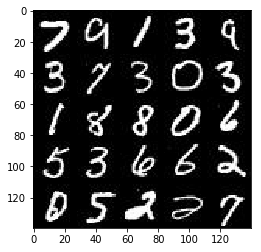

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

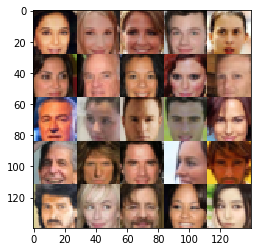

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_r = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, learn_r


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Hyperparameters

In [8]:
# leaky relu slope
alpha = 0.2

# print loss every
print_every = 10

# show image sample from G every
show_every = 100

# Smoothing 
smooth = 0.1

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Weights Initializer
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        
        ############# CONV BLOCK 1 ################
        # conv2d -> relu
        
        # Input layer is 28x28x3 (no batch norm here)
        conv1 = tf.layers.conv2d(images, 64, 5,
                              strides=1,
                              padding='valid',
                              kernel_initializer=xavier_init)
        relu1 = tf.maximum(alpha * conv1, conv1)
        #print(relu1)
        # 24x24x64
        
        ############# END CONV BLOCK 1 ############
        
        
        
        
        ############# CONV BLOCK 2 ################
        # conv2d -> batch_norm -> drop -> relu
        
        conv2 = tf.layers.conv2d(relu1, 128, 5,
                              strides=1,
                              padding='valid',
                              use_bias=False, 
                              kernel_initializer=xavier_init)
        
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        drop2 = tf.layers.dropout(bn2, training=True)
        relu2 = tf.maximum(alpha * drop2, drop2)
        #print(relu2)
        # 20x20x128
        
        ############# END CONV BLOCK 2 ############
        
        
        
        
        
        
        #############  CONV BLOCK 3 ##############
        # conv2d -> batch_norm -> drop -> relu
        
        conv3 = tf.layers.conv2d(relu2, 256, 5,
                                 strides=1,
                                 padding='valid',
                                 use_bias=False,
                                 kernel_initializer=xavier_init)
        
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        drop3 = tf.layers.dropout(bn3, training=True)
        relu3 = tf.maximum(alpha * drop3, drop3)
        #print(relu3)
        # 16x16x256
        
        #############  END CONV BLOCK 3 ##############
        
        
        
        
        
        

        
        #############  CONV BLOCK 4 ##################
        # conv2d -> batch_norm -> drop -> relu

        
        conv4 = tf.layers.conv2d(relu3, 512, 5,
                              strides=2,
                              padding='valid',
                              use_bias=False,
                              kernel_initializer=xavier_init)
        
        bn4 = tf.layers.batch_normalization(conv4, training=True)
        drop4 = tf.layers.dropout(bn4, training=True)        
        relu4 = tf.maximum(alpha * drop4, drop4)
        #print(relu4)
        # 6x6x512
        
        #############  END CONV BLOCK 4 ##############
        
        
        
        
        
        ############# Out Layer ##############

        # Flatten it
        flat = tf.reshape(relu4, (-1, 6*6*512))
        logits = tf.layers.dense(flat, 1, kernel_initializer=xavier_init)
        #print(flat)
        out = tf.sigmoid(logits)
        
        
        ############# End Out Layer ##############
       
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
 
    with tf.variable_scope('generator', reuse=not is_train):
      
    
        # Weights Initializer
        xavier_init = tf.contrib.layers.xavier_initializer()
    
        ############# Fully Connected  ################

        fc = tf.layers.dense(z, 7*7*1024, kernel_initializer=xavier_init)
        fc = tf.reshape(fc, (-1, 7, 7, 1024))
        drop = tf.layers.dropout(fc, training=is_train)
        relu = tf.maximum(alpha * drop, drop)
        #print(fc)
        # 7x7x1024 now
        
        ############# END Fully connected #############
        
        
        
        
        
        
        ############# DCONV BLOCK 1 ###################
        # conv2d_transpose -> batch_norm -> drop -> relu
        
        dconv1 = tf.layers.conv2d_transpose(relu, 512, 3,
                                            strides=2,
                                            padding='same',
                                            use_bias=False,
                                            kernel_initializer=xavier_init)
        
        bn1 = tf.layers.batch_normalization(dconv1, training=is_train)
        drop1 = tf.layers.dropout(bn1, training=is_train)
        relu1 = tf.maximum(alpha * drop1, drop1)
        #print(dconv1)
        # 14x14x512 now
        
        ############# END DCONV BLOCK 1 ################
        
        
        
        
         
            
        ############# DCONV BLOCK 2 ###################
        # conv2d_transpose -> batch_norm -> drop -> relu    
            
        
        dconv2 = tf.layers.conv2d_transpose(relu1, 256, 3,
                                            strides=2,
                                            padding='same',
                                            use_bias=False,
                                            kernel_initializer=xavier_init)
        
        bn2 = tf.layers.batch_normalization(dconv2, training=is_train)
        drop2 = tf.layers.dropout(bn2, training=is_train)
        relu2 = tf.maximum(alpha * drop2, drop2)
        #print(dconv2)
        # 28x28x256 now
        
        ############# END DCONV BLOCK 2 ###################
        
        
        
        
        
        
        
        
        ############# DCONV BLOCK 3 ###################
        # conv2d_transpose -> batch_norm -> drop -> relu
        
        dconv3 = tf.layers.conv2d_transpose(relu2, 128, 5,
                                            strides=1,
                                            padding='same',
                                            use_bias=False,
                                            kernel_initializer=xavier_init)
        
        bn3 = tf.layers.batch_normalization(dconv3, training=is_train)
        drop3 = tf.layers.dropout(bn3,training=is_train)
        relu3 = tf.maximum(alpha * drop3, drop3)
        #print(dconv3)
        # 28x28x128 now
        
        ############# END DCONV BLOCK 3 ###################
        
        
        
        
        
        
        
        ############# Out Layer ##############
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5,
                                            strides=1,
                                            padding='same',
                                            kernel_initializer=xavier_init)
        
        #print(logits)
        # 28x28x(channels) now
        
        out = tf.tanh(logits)
        
        ############# Out Layer ##############
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
from IPython.core.debugger import Tracer

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # create input placeholders
    #print(data_shape)
    image_shape = data_shape[1:]
    #print(image_shape)
    out_channel_dim = image_shape[-1]
    #print(out_channel_dim)
    
    inputs_real, inputs_z, lr_rate = model_inputs(*image_shape, z_dim)
    #print(inputs_real)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    #print(inputs_real)
    
    #t_vars = tf.trainable_variables()
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    #saver = tf.train.Saver(var_list=g_vars)
    
    def scale(x, target_range=(-1,1)):
        min, max = target_range
        
        # One liner, but too expensive 
        #x = (x - x.min()) * (max - min) / (x.max() - x.min()) + min
        
        # First scale to [0,1]
        x = ((x - x.min())/(x.max() - x.min()))
    
        # Then scale to target_range
        min, max = target_range
        x = x * (max - min) + min
        return x
    
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #print("Step {} ...".format(steps))
                
                #1 Scale real images to [-1,1] range since that is also the generator output scale
                batch_images = scale(batch_images, target_range=(-1,1))
                
                
                #3 Sample random noise for generator
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                
                #3 Run optimizers
                #print(batch_images.shape)
                            
                
                # Optimize discriminator
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images,
                                                     inputs_z: batch_z,
                                                     lr_rate: learning_rate})
                
                
                
                
                # Optimize generator (Run twice to avoid faster convergence of D)
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z,
                                                     inputs_real: batch_images,
                                                     lr_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z,
                                                     inputs_real: batch_images,
                                                     lr_rate: learning_rate})
                
                
                #Tracer()() #this one triggers the debugger
                if steps % print_every == 0:
                    
                    d_train_loss = d_loss.eval({inputs_real: batch_images,
                                                inputs_z: batch_z,
                                                lr_rate: learning_rate})
                
                    # Optimize generator
                    g_train_loss = g_loss.eval({inputs_z: batch_z,
                                                inputs_real: batch_images,
                                                lr_rate: learning_rate})
                    
                    #Tracer()() #this one triggers the debugger
                    print("Epoch {}/{}-Step {}...".format(epoch_i+1, epoch_count,steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))
                    
                if steps % show_every == 0:
                        show_generator_output(sess, 9, inputs_z, out_channel_dim, data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2-Step 10... Discriminator Loss: 2.3118... Generator Loss: 1.8300
Epoch 1/2-Step 20... Discriminator Loss: 3.3062... Generator Loss: 0.4146
Epoch 1/2-Step 30... Discriminator Loss: 5.4623... Generator Loss: 0.0596
Epoch 1/2-Step 40... Discriminator Loss: 3.8122... Generator Loss: 2.1554
Epoch 1/2-Step 50... Discriminator Loss: 2.1463... Generator Loss: 1.6847
Epoch 1/2-Step 60... Discriminator Loss: 1.8216... Generator Loss: 1.3277
Epoch 1/2-Step 70... Discriminator Loss: 3.0009... Generator Loss: 0.2086
Epoch 1/2-Step 80... Discriminator Loss: 2.1514... Generator Loss: 0.5999
Epoch 1/2-Step 90... Discriminator Loss: 2.6132... Generator Loss: 0.6457
Epoch 1/2-Step 100... Discriminator Loss: 1.3977... Generator Loss: 0.9171


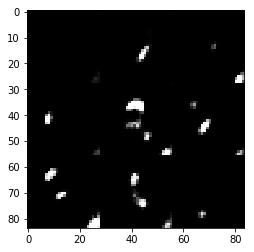

Epoch 1/2-Step 110... Discriminator Loss: 1.7667... Generator Loss: 1.2358
Epoch 1/2-Step 120... Discriminator Loss: 2.2311... Generator Loss: 1.1288
Epoch 1/2-Step 130... Discriminator Loss: 1.6081... Generator Loss: 1.1581
Epoch 1/2-Step 140... Discriminator Loss: 2.1011... Generator Loss: 0.8867
Epoch 1/2-Step 150... Discriminator Loss: 2.1195... Generator Loss: 0.4963
Epoch 1/2-Step 160... Discriminator Loss: 1.9894... Generator Loss: 0.6073
Epoch 1/2-Step 170... Discriminator Loss: 2.5766... Generator Loss: 0.3160
Epoch 1/2-Step 180... Discriminator Loss: 2.6919... Generator Loss: 0.3946
Epoch 1/2-Step 190... Discriminator Loss: 2.1254... Generator Loss: 0.9327
Epoch 1/2-Step 200... Discriminator Loss: 3.2503... Generator Loss: 0.2115


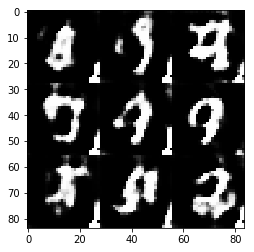

Epoch 1/2-Step 210... Discriminator Loss: 2.3345... Generator Loss: 1.4846
Epoch 1/2-Step 220... Discriminator Loss: 2.3870... Generator Loss: 0.3692
Epoch 1/2-Step 230... Discriminator Loss: 2.6547... Generator Loss: 0.7615
Epoch 1/2-Step 240... Discriminator Loss: 1.9027... Generator Loss: 1.3755
Epoch 1/2-Step 250... Discriminator Loss: 2.2588... Generator Loss: 1.6757
Epoch 1/2-Step 260... Discriminator Loss: 1.8497... Generator Loss: 0.4162
Epoch 1/2-Step 270... Discriminator Loss: 2.2802... Generator Loss: 0.8063
Epoch 1/2-Step 280... Discriminator Loss: 2.4021... Generator Loss: 1.9779
Epoch 1/2-Step 290... Discriminator Loss: 2.1448... Generator Loss: 0.5301
Epoch 1/2-Step 300... Discriminator Loss: 2.8183... Generator Loss: 2.2886


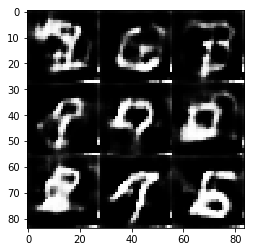

Epoch 1/2-Step 310... Discriminator Loss: 2.2783... Generator Loss: 0.7090
Epoch 1/2-Step 320... Discriminator Loss: 2.3461... Generator Loss: 1.9455
Epoch 1/2-Step 330... Discriminator Loss: 1.7101... Generator Loss: 0.7023
Epoch 1/2-Step 340... Discriminator Loss: 1.8282... Generator Loss: 0.4235
Epoch 1/2-Step 350... Discriminator Loss: 2.4861... Generator Loss: 0.4528
Epoch 1/2-Step 360... Discriminator Loss: 2.2659... Generator Loss: 0.7544
Epoch 1/2-Step 370... Discriminator Loss: 2.0567... Generator Loss: 0.5790
Epoch 1/2-Step 380... Discriminator Loss: 1.7823... Generator Loss: 0.9565
Epoch 1/2-Step 390... Discriminator Loss: 1.9036... Generator Loss: 0.7933
Epoch 1/2-Step 400... Discriminator Loss: 2.1564... Generator Loss: 0.4115


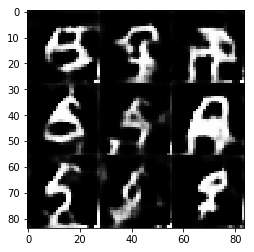

Epoch 1/2-Step 410... Discriminator Loss: 1.9079... Generator Loss: 0.7702
Epoch 1/2-Step 420... Discriminator Loss: 1.7968... Generator Loss: 0.7860
Epoch 1/2-Step 430... Discriminator Loss: 2.0565... Generator Loss: 0.5020
Epoch 1/2-Step 440... Discriminator Loss: 1.5293... Generator Loss: 1.2694
Epoch 1/2-Step 450... Discriminator Loss: 2.2105... Generator Loss: 0.1410
Epoch 1/2-Step 460... Discriminator Loss: 1.3486... Generator Loss: 1.1598
Epoch 1/2-Step 470... Discriminator Loss: 2.2251... Generator Loss: 1.4939
Epoch 1/2-Step 480... Discriminator Loss: 1.7503... Generator Loss: 0.6644
Epoch 1/2-Step 490... Discriminator Loss: 3.0195... Generator Loss: 0.3693
Epoch 1/2-Step 500... Discriminator Loss: 2.2151... Generator Loss: 0.9348


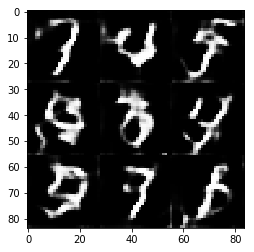

Epoch 1/2-Step 510... Discriminator Loss: 3.9171... Generator Loss: 0.0883
Epoch 1/2-Step 520... Discriminator Loss: 1.4402... Generator Loss: 1.4085
Epoch 1/2-Step 530... Discriminator Loss: 2.2724... Generator Loss: 0.7950
Epoch 1/2-Step 540... Discriminator Loss: 1.9018... Generator Loss: 0.8728
Epoch 1/2-Step 550... Discriminator Loss: 1.5139... Generator Loss: 0.9002
Epoch 1/2-Step 560... Discriminator Loss: 1.3713... Generator Loss: 0.9616
Epoch 1/2-Step 570... Discriminator Loss: 1.7664... Generator Loss: 1.1300
Epoch 1/2-Step 580... Discriminator Loss: 1.6943... Generator Loss: 1.7043
Epoch 1/2-Step 590... Discriminator Loss: 2.2566... Generator Loss: 0.3415
Epoch 1/2-Step 600... Discriminator Loss: 1.6204... Generator Loss: 0.8635


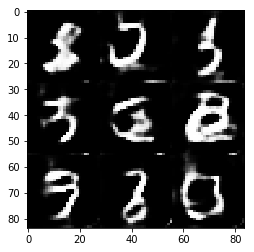

Epoch 1/2-Step 610... Discriminator Loss: 2.0628... Generator Loss: 0.6711
Epoch 1/2-Step 620... Discriminator Loss: 1.3906... Generator Loss: 1.0603
Epoch 1/2-Step 630... Discriminator Loss: 1.4823... Generator Loss: 0.6392
Epoch 1/2-Step 640... Discriminator Loss: 1.7678... Generator Loss: 0.7574
Epoch 1/2-Step 650... Discriminator Loss: 1.7096... Generator Loss: 1.1681
Epoch 1/2-Step 660... Discriminator Loss: 1.7436... Generator Loss: 0.9023
Epoch 1/2-Step 670... Discriminator Loss: 2.0634... Generator Loss: 0.6600
Epoch 1/2-Step 680... Discriminator Loss: 1.8377... Generator Loss: 2.0370
Epoch 1/2-Step 690... Discriminator Loss: 1.6467... Generator Loss: 0.7104
Epoch 1/2-Step 700... Discriminator Loss: 1.5969... Generator Loss: 0.5801


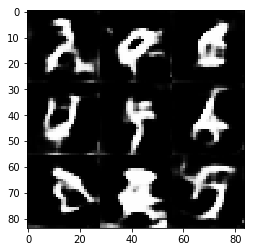

Epoch 1/2-Step 710... Discriminator Loss: 2.0489... Generator Loss: 0.4872
Epoch 1/2-Step 720... Discriminator Loss: 2.2425... Generator Loss: 0.4303
Epoch 1/2-Step 730... Discriminator Loss: 2.0173... Generator Loss: 0.8741
Epoch 1/2-Step 740... Discriminator Loss: 2.1449... Generator Loss: 0.5130
Epoch 1/2-Step 750... Discriminator Loss: 1.5261... Generator Loss: 0.8271
Epoch 1/2-Step 760... Discriminator Loss: 1.8701... Generator Loss: 0.3742
Epoch 1/2-Step 770... Discriminator Loss: 1.7754... Generator Loss: 0.6628
Epoch 1/2-Step 780... Discriminator Loss: 1.7760... Generator Loss: 0.5923
Epoch 1/2-Step 790... Discriminator Loss: 1.8626... Generator Loss: 0.6293
Epoch 1/2-Step 800... Discriminator Loss: 1.4426... Generator Loss: 1.4333


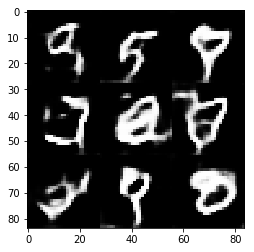

Epoch 1/2-Step 810... Discriminator Loss: 2.2480... Generator Loss: 0.2999
Epoch 1/2-Step 820... Discriminator Loss: 2.1555... Generator Loss: 1.3444
Epoch 1/2-Step 830... Discriminator Loss: 1.9879... Generator Loss: 0.9417
Epoch 1/2-Step 840... Discriminator Loss: 2.4632... Generator Loss: 0.3972
Epoch 1/2-Step 850... Discriminator Loss: 1.4709... Generator Loss: 0.5511
Epoch 1/2-Step 860... Discriminator Loss: 2.2099... Generator Loss: 2.0288
Epoch 1/2-Step 870... Discriminator Loss: 1.8572... Generator Loss: 1.4878
Epoch 1/2-Step 880... Discriminator Loss: 1.9986... Generator Loss: 1.5338
Epoch 1/2-Step 890... Discriminator Loss: 1.7793... Generator Loss: 0.7089
Epoch 1/2-Step 900... Discriminator Loss: 1.0658... Generator Loss: 1.5902


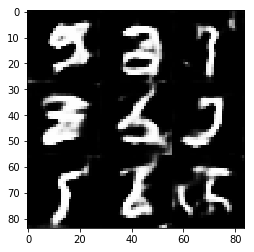

Epoch 1/2-Step 910... Discriminator Loss: 2.0082... Generator Loss: 0.6012
Epoch 1/2-Step 920... Discriminator Loss: 1.6025... Generator Loss: 0.5098
Epoch 1/2-Step 930... Discriminator Loss: 2.4625... Generator Loss: 0.2596
Epoch 1/2-Step 940... Discriminator Loss: 1.4311... Generator Loss: 1.0545
Epoch 1/2-Step 950... Discriminator Loss: 1.7271... Generator Loss: 0.7301
Epoch 1/2-Step 960... Discriminator Loss: 2.2494... Generator Loss: 1.4716
Epoch 1/2-Step 970... Discriminator Loss: 1.6490... Generator Loss: 0.9634
Epoch 1/2-Step 980... Discriminator Loss: 1.8123... Generator Loss: 2.0872
Epoch 1/2-Step 990... Discriminator Loss: 1.8791... Generator Loss: 1.1141
Epoch 1/2-Step 1000... Discriminator Loss: 2.2623... Generator Loss: 0.6271


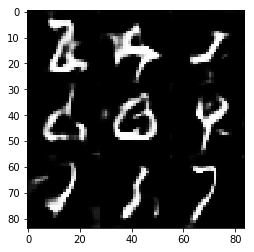

Epoch 1/2-Step 1010... Discriminator Loss: 1.5344... Generator Loss: 0.4333
Epoch 1/2-Step 1020... Discriminator Loss: 1.3361... Generator Loss: 1.1219
Epoch 1/2-Step 1030... Discriminator Loss: 2.0035... Generator Loss: 1.5471
Epoch 1/2-Step 1040... Discriminator Loss: 1.5246... Generator Loss: 0.7886
Epoch 1/2-Step 1050... Discriminator Loss: 2.2192... Generator Loss: 0.6574
Epoch 1/2-Step 1060... Discriminator Loss: 1.5182... Generator Loss: 1.3824
Epoch 1/2-Step 1070... Discriminator Loss: 2.7937... Generator Loss: 0.3068
Epoch 1/2-Step 1080... Discriminator Loss: 1.4752... Generator Loss: 0.8406
Epoch 1/2-Step 1090... Discriminator Loss: 1.8927... Generator Loss: 0.6407
Epoch 1/2-Step 1100... Discriminator Loss: 1.7118... Generator Loss: 0.6947


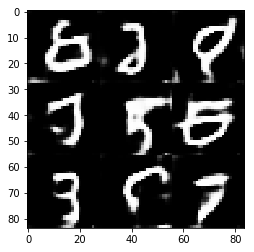

Epoch 1/2-Step 1110... Discriminator Loss: 1.8363... Generator Loss: 0.8679
Epoch 1/2-Step 1120... Discriminator Loss: 2.0464... Generator Loss: 0.4784
Epoch 1/2-Step 1130... Discriminator Loss: 1.6536... Generator Loss: 1.8249
Epoch 1/2-Step 1140... Discriminator Loss: 1.7578... Generator Loss: 0.5718
Epoch 1/2-Step 1150... Discriminator Loss: 2.8404... Generator Loss: 0.2328
Epoch 1/2-Step 1160... Discriminator Loss: 1.2185... Generator Loss: 1.2534
Epoch 1/2-Step 1170... Discriminator Loss: 1.5187... Generator Loss: 0.8082
Epoch 1/2-Step 1180... Discriminator Loss: 1.8224... Generator Loss: 0.7550
Epoch 1/2-Step 1190... Discriminator Loss: 1.5622... Generator Loss: 1.1450
Epoch 1/2-Step 1200... Discriminator Loss: 1.2265... Generator Loss: 1.1609


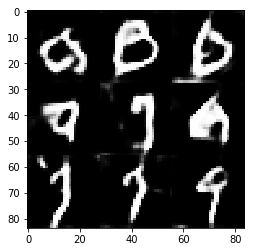

Epoch 1/2-Step 1210... Discriminator Loss: 1.4962... Generator Loss: 1.2880
Epoch 1/2-Step 1220... Discriminator Loss: 1.7215... Generator Loss: 0.9768
Epoch 1/2-Step 1230... Discriminator Loss: 1.8570... Generator Loss: 0.5593
Epoch 1/2-Step 1240... Discriminator Loss: 1.4478... Generator Loss: 1.3494
Epoch 1/2-Step 1250... Discriminator Loss: 2.1037... Generator Loss: 0.5527
Epoch 1/2-Step 1260... Discriminator Loss: 3.1092... Generator Loss: 0.1941
Epoch 1/2-Step 1270... Discriminator Loss: 1.6438... Generator Loss: 0.5245
Epoch 1/2-Step 1280... Discriminator Loss: 1.4956... Generator Loss: 0.9718
Epoch 1/2-Step 1290... Discriminator Loss: 2.0359... Generator Loss: 0.4613
Epoch 1/2-Step 1300... Discriminator Loss: 1.2851... Generator Loss: 2.5540


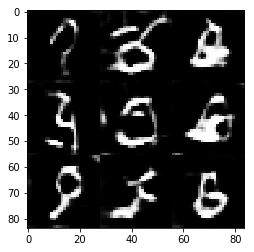

Epoch 1/2-Step 1310... Discriminator Loss: 1.9794... Generator Loss: 1.2672
Epoch 1/2-Step 1320... Discriminator Loss: 1.5431... Generator Loss: 0.8462
Epoch 1/2-Step 1330... Discriminator Loss: 2.6111... Generator Loss: 2.0525
Epoch 1/2-Step 1340... Discriminator Loss: 1.8478... Generator Loss: 0.6593
Epoch 1/2-Step 1350... Discriminator Loss: 1.5591... Generator Loss: 2.2388
Epoch 1/2-Step 1360... Discriminator Loss: 2.0985... Generator Loss: 0.4223
Epoch 1/2-Step 1370... Discriminator Loss: 1.3647... Generator Loss: 0.6367
Epoch 1/2-Step 1380... Discriminator Loss: 1.2238... Generator Loss: 1.0516
Epoch 1/2-Step 1390... Discriminator Loss: 1.5150... Generator Loss: 1.1102
Epoch 1/2-Step 1400... Discriminator Loss: 1.0320... Generator Loss: 1.1787


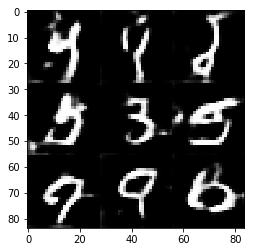

Epoch 1/2-Step 1410... Discriminator Loss: 2.0789... Generator Loss: 0.8383
Epoch 1/2-Step 1420... Discriminator Loss: 1.5342... Generator Loss: 0.8889
Epoch 1/2-Step 1430... Discriminator Loss: 2.1573... Generator Loss: 1.1052
Epoch 1/2-Step 1440... Discriminator Loss: 1.5579... Generator Loss: 0.6092
Epoch 1/2-Step 1450... Discriminator Loss: 2.5980... Generator Loss: 0.3473
Epoch 1/2-Step 1460... Discriminator Loss: 0.9412... Generator Loss: 1.3549
Epoch 1/2-Step 1470... Discriminator Loss: 1.5168... Generator Loss: 0.7796
Epoch 1/2-Step 1480... Discriminator Loss: 1.3101... Generator Loss: 1.2143
Epoch 1/2-Step 1490... Discriminator Loss: 1.7092... Generator Loss: 0.5636
Epoch 1/2-Step 1500... Discriminator Loss: 1.7458... Generator Loss: 0.9821


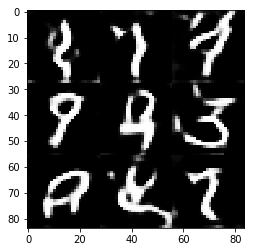

Epoch 1/2-Step 1510... Discriminator Loss: 2.2684... Generator Loss: 0.5608
Epoch 1/2-Step 1520... Discriminator Loss: 1.9566... Generator Loss: 1.3383
Epoch 1/2-Step 1530... Discriminator Loss: 1.3982... Generator Loss: 1.3955
Epoch 1/2-Step 1540... Discriminator Loss: 1.6526... Generator Loss: 2.5369
Epoch 1/2-Step 1550... Discriminator Loss: 0.7793... Generator Loss: 1.4792
Epoch 1/2-Step 1560... Discriminator Loss: 2.7674... Generator Loss: 0.6169
Epoch 1/2-Step 1570... Discriminator Loss: 2.0942... Generator Loss: 0.9290
Epoch 1/2-Step 1580... Discriminator Loss: 2.5194... Generator Loss: 0.2785
Epoch 1/2-Step 1590... Discriminator Loss: 0.9844... Generator Loss: 0.9368
Epoch 1/2-Step 1600... Discriminator Loss: 1.6432... Generator Loss: 1.0269


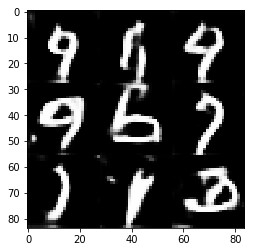

Epoch 1/2-Step 1610... Discriminator Loss: 1.9181... Generator Loss: 0.5161
Epoch 1/2-Step 1620... Discriminator Loss: 1.5031... Generator Loss: 2.0783
Epoch 1/2-Step 1630... Discriminator Loss: 0.6584... Generator Loss: 1.7617
Epoch 1/2-Step 1640... Discriminator Loss: 1.7910... Generator Loss: 1.2240
Epoch 1/2-Step 1650... Discriminator Loss: 1.6499... Generator Loss: 0.6987
Epoch 1/2-Step 1660... Discriminator Loss: 1.2733... Generator Loss: 0.7293
Epoch 1/2-Step 1670... Discriminator Loss: 1.4346... Generator Loss: 1.5883
Epoch 1/2-Step 1680... Discriminator Loss: 1.0651... Generator Loss: 0.8878
Epoch 1/2-Step 1690... Discriminator Loss: 2.7191... Generator Loss: 0.4455
Epoch 1/2-Step 1700... Discriminator Loss: 1.4566... Generator Loss: 0.8971


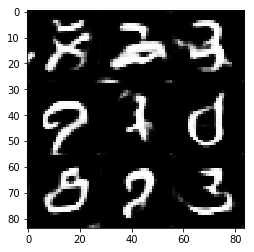

Epoch 1/2-Step 1710... Discriminator Loss: 0.9720... Generator Loss: 1.2247
Epoch 1/2-Step 1720... Discriminator Loss: 1.5625... Generator Loss: 1.0967
Epoch 1/2-Step 1730... Discriminator Loss: 1.3570... Generator Loss: 1.2406
Epoch 1/2-Step 1740... Discriminator Loss: 0.9930... Generator Loss: 1.0665
Epoch 1/2-Step 1750... Discriminator Loss: 1.2531... Generator Loss: 1.1553
Epoch 1/2-Step 1760... Discriminator Loss: 1.6308... Generator Loss: 2.6386
Epoch 1/2-Step 1770... Discriminator Loss: 1.5074... Generator Loss: 2.9194
Epoch 1/2-Step 1780... Discriminator Loss: 1.1102... Generator Loss: 0.9617
Epoch 1/2-Step 1790... Discriminator Loss: 1.5774... Generator Loss: 0.8478
Epoch 1/2-Step 1800... Discriminator Loss: 1.6303... Generator Loss: 0.7241


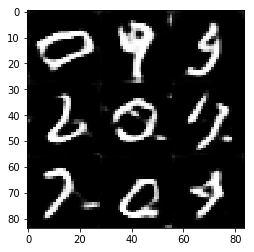

Epoch 1/2-Step 1810... Discriminator Loss: 1.4055... Generator Loss: 0.9881
Epoch 1/2-Step 1820... Discriminator Loss: 0.9379... Generator Loss: 1.4142
Epoch 1/2-Step 1830... Discriminator Loss: 1.2579... Generator Loss: 1.0808
Epoch 1/2-Step 1840... Discriminator Loss: 0.9951... Generator Loss: 1.7914
Epoch 1/2-Step 1850... Discriminator Loss: 1.2072... Generator Loss: 1.8785
Epoch 1/2-Step 1860... Discriminator Loss: 1.7810... Generator Loss: 0.9379
Epoch 1/2-Step 1870... Discriminator Loss: 1.6841... Generator Loss: 0.7043
Epoch 1/2-Step 1880... Discriminator Loss: 1.6064... Generator Loss: 0.4850
Epoch 1/2-Step 1890... Discriminator Loss: 1.9991... Generator Loss: 0.9446
Epoch 1/2-Step 1900... Discriminator Loss: 0.7067... Generator Loss: 2.2667


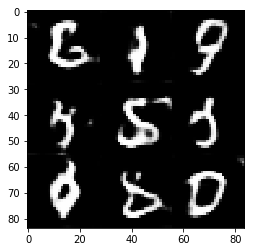

Epoch 1/2-Step 1910... Discriminator Loss: 1.0243... Generator Loss: 1.6444
Epoch 1/2-Step 1920... Discriminator Loss: 1.2215... Generator Loss: 1.3887
Epoch 1/2-Step 1930... Discriminator Loss: 1.6844... Generator Loss: 0.7205
Epoch 1/2-Step 1940... Discriminator Loss: 1.4666... Generator Loss: 0.9609
Epoch 1/2-Step 1950... Discriminator Loss: 2.2047... Generator Loss: 0.2255
Epoch 1/2-Step 1960... Discriminator Loss: 0.9293... Generator Loss: 1.8723
Epoch 1/2-Step 1970... Discriminator Loss: 1.9385... Generator Loss: 1.2363
Epoch 1/2-Step 1980... Discriminator Loss: 1.3688... Generator Loss: 1.4991
Epoch 1/2-Step 1990... Discriminator Loss: 1.4144... Generator Loss: 2.1793
Epoch 1/2-Step 2000... Discriminator Loss: 2.1385... Generator Loss: 1.0334


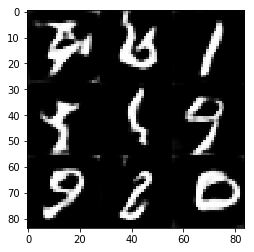

Epoch 1/2-Step 2010... Discriminator Loss: 1.8282... Generator Loss: 2.2538
Epoch 1/2-Step 2020... Discriminator Loss: 1.3680... Generator Loss: 1.4629
Epoch 1/2-Step 2030... Discriminator Loss: 1.2789... Generator Loss: 1.4095
Epoch 1/2-Step 2040... Discriminator Loss: 0.7795... Generator Loss: 1.7727
Epoch 1/2-Step 2050... Discriminator Loss: 1.8060... Generator Loss: 1.1282
Epoch 1/2-Step 2060... Discriminator Loss: 2.7817... Generator Loss: 0.3962
Epoch 1/2-Step 2070... Discriminator Loss: 1.3030... Generator Loss: 1.8516
Epoch 1/2-Step 2080... Discriminator Loss: 1.2551... Generator Loss: 2.0143
Epoch 1/2-Step 2090... Discriminator Loss: 1.1564... Generator Loss: 1.1777
Epoch 1/2-Step 2100... Discriminator Loss: 1.5885... Generator Loss: 0.5241


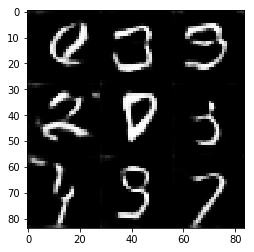

Epoch 1/2-Step 2110... Discriminator Loss: 1.3204... Generator Loss: 1.6334
Epoch 1/2-Step 2120... Discriminator Loss: 1.0556... Generator Loss: 1.4026
Epoch 1/2-Step 2130... Discriminator Loss: 1.1855... Generator Loss: 1.3955
Epoch 1/2-Step 2140... Discriminator Loss: 1.4678... Generator Loss: 2.5821
Epoch 1/2-Step 2150... Discriminator Loss: 1.8101... Generator Loss: 0.6262
Epoch 1/2-Step 2160... Discriminator Loss: 1.7871... Generator Loss: 1.3442
Epoch 1/2-Step 2170... Discriminator Loss: 1.3084... Generator Loss: 0.9783
Epoch 1/2-Step 2180... Discriminator Loss: 1.1878... Generator Loss: 1.0560
Epoch 1/2-Step 2190... Discriminator Loss: 1.4956... Generator Loss: 1.1276
Epoch 1/2-Step 2200... Discriminator Loss: 2.5187... Generator Loss: 0.3612


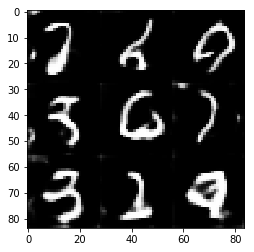

Epoch 1/2-Step 2210... Discriminator Loss: 1.3161... Generator Loss: 0.9862
Epoch 1/2-Step 2220... Discriminator Loss: 1.1794... Generator Loss: 1.5978
Epoch 1/2-Step 2230... Discriminator Loss: 1.7036... Generator Loss: 1.4239
Epoch 1/2-Step 2240... Discriminator Loss: 1.2739... Generator Loss: 1.7801
Epoch 1/2-Step 2250... Discriminator Loss: 1.1780... Generator Loss: 0.7900
Epoch 1/2-Step 2260... Discriminator Loss: 1.6259... Generator Loss: 0.6541
Epoch 1/2-Step 2270... Discriminator Loss: 1.0366... Generator Loss: 1.3761
Epoch 1/2-Step 2280... Discriminator Loss: 0.9188... Generator Loss: 1.4899
Epoch 1/2-Step 2290... Discriminator Loss: 1.3118... Generator Loss: 1.9320
Epoch 1/2-Step 2300... Discriminator Loss: 1.5558... Generator Loss: 1.8601


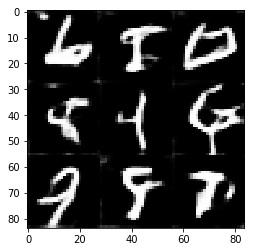

Epoch 1/2-Step 2310... Discriminator Loss: 1.3513... Generator Loss: 1.1792
Epoch 1/2-Step 2320... Discriminator Loss: 1.1276... Generator Loss: 1.6514
Epoch 1/2-Step 2330... Discriminator Loss: 1.0582... Generator Loss: 1.3400
Epoch 1/2-Step 2340... Discriminator Loss: 1.0007... Generator Loss: 1.2159
Epoch 1/2-Step 2350... Discriminator Loss: 1.3421... Generator Loss: 0.4202
Epoch 1/2-Step 2360... Discriminator Loss: 0.9796... Generator Loss: 3.7176
Epoch 1/2-Step 2370... Discriminator Loss: 1.4807... Generator Loss: 0.4350
Epoch 1/2-Step 2380... Discriminator Loss: 0.9803... Generator Loss: 2.3177
Epoch 1/2-Step 2390... Discriminator Loss: 1.9081... Generator Loss: 0.8476
Epoch 1/2-Step 2400... Discriminator Loss: 1.4687... Generator Loss: 0.9120


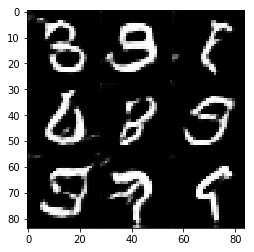

Epoch 1/2-Step 2410... Discriminator Loss: 1.1684... Generator Loss: 0.7956
Epoch 1/2-Step 2420... Discriminator Loss: 0.6919... Generator Loss: 1.3747
Epoch 1/2-Step 2430... Discriminator Loss: 0.8773... Generator Loss: 1.5710
Epoch 1/2-Step 2440... Discriminator Loss: 1.2435... Generator Loss: 2.3948
Epoch 1/2-Step 2450... Discriminator Loss: 0.8684... Generator Loss: 1.5118
Epoch 1/2-Step 2460... Discriminator Loss: 1.1518... Generator Loss: 0.8184
Epoch 1/2-Step 2470... Discriminator Loss: 0.7865... Generator Loss: 1.7250
Epoch 1/2-Step 2480... Discriminator Loss: 2.0862... Generator Loss: 0.6269
Epoch 1/2-Step 2490... Discriminator Loss: 0.7544... Generator Loss: 1.5364
Epoch 1/2-Step 2500... Discriminator Loss: 0.7736... Generator Loss: 2.7293


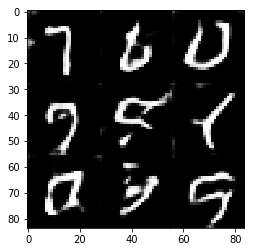

Epoch 1/2-Step 2510... Discriminator Loss: 1.6349... Generator Loss: 1.0930
Epoch 1/2-Step 2520... Discriminator Loss: 1.8854... Generator Loss: 0.6645
Epoch 1/2-Step 2530... Discriminator Loss: 1.5640... Generator Loss: 1.0977
Epoch 1/2-Step 2540... Discriminator Loss: 1.0245... Generator Loss: 1.7135
Epoch 1/2-Step 2550... Discriminator Loss: 0.8430... Generator Loss: 1.1761
Epoch 1/2-Step 2560... Discriminator Loss: 1.6688... Generator Loss: 0.8801
Epoch 1/2-Step 2570... Discriminator Loss: 0.8400... Generator Loss: 3.5527
Epoch 1/2-Step 2580... Discriminator Loss: 1.1897... Generator Loss: 2.6267
Epoch 1/2-Step 2590... Discriminator Loss: 1.3093... Generator Loss: 3.1767
Epoch 1/2-Step 2600... Discriminator Loss: 1.3642... Generator Loss: 1.4354


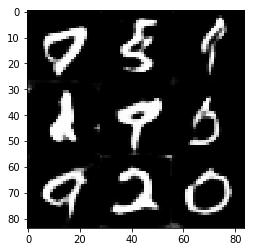

Epoch 1/2-Step 2610... Discriminator Loss: 0.9792... Generator Loss: 2.6876
Epoch 1/2-Step 2620... Discriminator Loss: 1.1148... Generator Loss: 1.1051
Epoch 1/2-Step 2630... Discriminator Loss: 0.9979... Generator Loss: 0.9700
Epoch 1/2-Step 2640... Discriminator Loss: 0.6082... Generator Loss: 1.9845
Epoch 1/2-Step 2650... Discriminator Loss: 1.0193... Generator Loss: 1.4141
Epoch 1/2-Step 2660... Discriminator Loss: 0.8010... Generator Loss: 1.6993
Epoch 1/2-Step 2670... Discriminator Loss: 0.9638... Generator Loss: 1.9727
Epoch 1/2-Step 2680... Discriminator Loss: 4.1851... Generator Loss: 5.9589
Epoch 1/2-Step 2690... Discriminator Loss: 1.0559... Generator Loss: 2.3036
Epoch 1/2-Step 2700... Discriminator Loss: 0.7456... Generator Loss: 3.0289


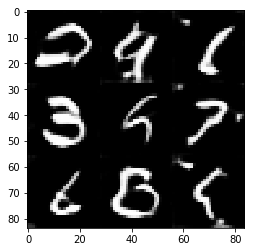

Epoch 1/2-Step 2710... Discriminator Loss: 1.6097... Generator Loss: 0.8380
Epoch 1/2-Step 2720... Discriminator Loss: 0.7764... Generator Loss: 1.9949
Epoch 1/2-Step 2730... Discriminator Loss: 1.9236... Generator Loss: 0.5473
Epoch 1/2-Step 2740... Discriminator Loss: 1.0212... Generator Loss: 2.1570
Epoch 1/2-Step 2750... Discriminator Loss: 1.3450... Generator Loss: 3.2112
Epoch 1/2-Step 2760... Discriminator Loss: 1.0912... Generator Loss: 0.5948
Epoch 1/2-Step 2770... Discriminator Loss: 1.8577... Generator Loss: 1.2803
Epoch 1/2-Step 2780... Discriminator Loss: 1.6736... Generator Loss: 0.4892
Epoch 1/2-Step 2790... Discriminator Loss: 1.8356... Generator Loss: 0.4581
Epoch 1/2-Step 2800... Discriminator Loss: 1.1618... Generator Loss: 2.8949


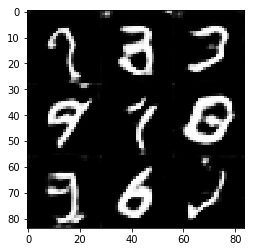

Epoch 1/2-Step 2810... Discriminator Loss: 0.8225... Generator Loss: 1.0229
Epoch 1/2-Step 2820... Discriminator Loss: 0.9250... Generator Loss: 2.2914
Epoch 1/2-Step 2830... Discriminator Loss: 0.7572... Generator Loss: 1.8686
Epoch 1/2-Step 2840... Discriminator Loss: 0.6191... Generator Loss: 1.5279
Epoch 1/2-Step 2850... Discriminator Loss: 1.2797... Generator Loss: 0.5229
Epoch 1/2-Step 2860... Discriminator Loss: 2.3627... Generator Loss: 0.4211
Epoch 1/2-Step 2870... Discriminator Loss: 2.2202... Generator Loss: 0.6415
Epoch 1/2-Step 2880... Discriminator Loss: 0.9318... Generator Loss: 2.2874
Epoch 1/2-Step 2890... Discriminator Loss: 1.1470... Generator Loss: 1.2436
Epoch 1/2-Step 2900... Discriminator Loss: 0.9684... Generator Loss: 1.6122


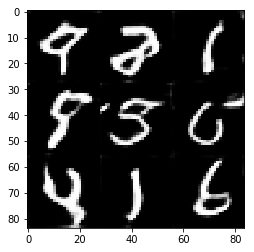

Epoch 1/2-Step 2910... Discriminator Loss: 0.9839... Generator Loss: 1.8861
Epoch 1/2-Step 2920... Discriminator Loss: 0.6033... Generator Loss: 2.6670
Epoch 1/2-Step 2930... Discriminator Loss: 1.0567... Generator Loss: 1.3305
Epoch 1/2-Step 2940... Discriminator Loss: 1.3203... Generator Loss: 0.8143
Epoch 1/2-Step 2950... Discriminator Loss: 0.9820... Generator Loss: 1.9188
Epoch 1/2-Step 2960... Discriminator Loss: 1.8473... Generator Loss: 0.5898
Epoch 1/2-Step 2970... Discriminator Loss: 0.8452... Generator Loss: 1.5901
Epoch 1/2-Step 2980... Discriminator Loss: 1.1733... Generator Loss: 1.6805
Epoch 1/2-Step 2990... Discriminator Loss: 1.4451... Generator Loss: 4.1489
Epoch 1/2-Step 3000... Discriminator Loss: 1.5283... Generator Loss: 0.9003


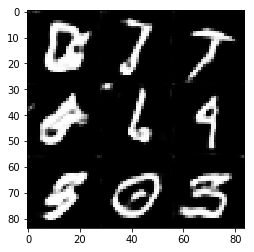

Epoch 1/2-Step 3010... Discriminator Loss: 1.0045... Generator Loss: 1.3305
Epoch 1/2-Step 3020... Discriminator Loss: 1.2027... Generator Loss: 0.6926
Epoch 1/2-Step 3030... Discriminator Loss: 1.4056... Generator Loss: 1.7993
Epoch 1/2-Step 3040... Discriminator Loss: 0.7977... Generator Loss: 2.2008
Epoch 1/2-Step 3050... Discriminator Loss: 0.9407... Generator Loss: 3.3201
Epoch 1/2-Step 3060... Discriminator Loss: 1.6828... Generator Loss: 1.4347
Epoch 1/2-Step 3070... Discriminator Loss: 0.9688... Generator Loss: 1.4361
Epoch 1/2-Step 3080... Discriminator Loss: 1.1253... Generator Loss: 1.6667
Epoch 1/2-Step 3090... Discriminator Loss: 1.3357... Generator Loss: 1.5047
Epoch 1/2-Step 3100... Discriminator Loss: 1.9671... Generator Loss: 1.1792


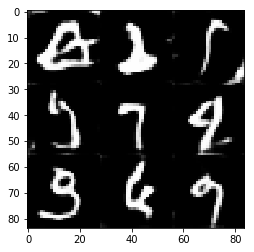

Epoch 1/2-Step 3110... Discriminator Loss: 0.7444... Generator Loss: 1.8457
Epoch 1/2-Step 3120... Discriminator Loss: 1.2955... Generator Loss: 1.3343
Epoch 1/2-Step 3130... Discriminator Loss: 1.9783... Generator Loss: 0.7650
Epoch 1/2-Step 3140... Discriminator Loss: 1.2794... Generator Loss: 1.7128
Epoch 1/2-Step 3150... Discriminator Loss: 0.9588... Generator Loss: 1.4020
Epoch 1/2-Step 3160... Discriminator Loss: 1.6277... Generator Loss: 0.9372
Epoch 1/2-Step 3170... Discriminator Loss: 0.7439... Generator Loss: 2.2052
Epoch 1/2-Step 3180... Discriminator Loss: 0.8528... Generator Loss: 1.7296
Epoch 1/2-Step 3190... Discriminator Loss: 0.9380... Generator Loss: 1.8576
Epoch 1/2-Step 3200... Discriminator Loss: 1.0516... Generator Loss: 1.7026


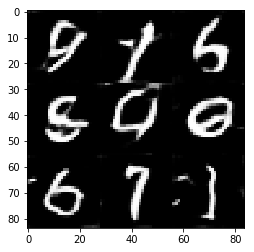

Epoch 1/2-Step 3210... Discriminator Loss: 1.1894... Generator Loss: 1.5121
Epoch 1/2-Step 3220... Discriminator Loss: 1.6376... Generator Loss: 0.7133
Epoch 1/2-Step 3230... Discriminator Loss: 0.9435... Generator Loss: 1.6021
Epoch 1/2-Step 3240... Discriminator Loss: 0.6321... Generator Loss: 1.9048
Epoch 1/2-Step 3250... Discriminator Loss: 1.5177... Generator Loss: 0.6432
Epoch 1/2-Step 3260... Discriminator Loss: 1.1988... Generator Loss: 1.5884
Epoch 1/2-Step 3270... Discriminator Loss: 0.8108... Generator Loss: 1.3113
Epoch 1/2-Step 3280... Discriminator Loss: 0.6272... Generator Loss: 2.3086
Epoch 1/2-Step 3290... Discriminator Loss: 0.8616... Generator Loss: 1.8550
Epoch 1/2-Step 3300... Discriminator Loss: 1.0116... Generator Loss: 2.2713


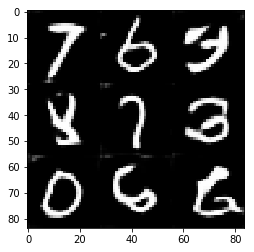

Epoch 1/2-Step 3310... Discriminator Loss: 0.9675... Generator Loss: 1.0892
Epoch 1/2-Step 3320... Discriminator Loss: 1.7879... Generator Loss: 3.6830
Epoch 1/2-Step 3330... Discriminator Loss: 0.9832... Generator Loss: 1.2708
Epoch 1/2-Step 3340... Discriminator Loss: 0.9825... Generator Loss: 1.6189
Epoch 1/2-Step 3350... Discriminator Loss: 1.2052... Generator Loss: 2.5176
Epoch 1/2-Step 3360... Discriminator Loss: 0.8736... Generator Loss: 1.6014
Epoch 1/2-Step 3370... Discriminator Loss: 1.3317... Generator Loss: 0.8679
Epoch 1/2-Step 3380... Discriminator Loss: 1.8753... Generator Loss: 0.8683
Epoch 1/2-Step 3390... Discriminator Loss: 1.3497... Generator Loss: 1.1751
Epoch 1/2-Step 3400... Discriminator Loss: 1.9078... Generator Loss: 1.0901


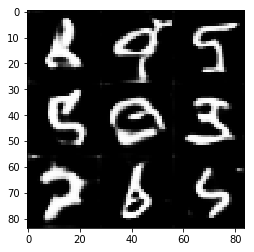

Epoch 1/2-Step 3410... Discriminator Loss: 0.8109... Generator Loss: 2.9047
Epoch 1/2-Step 3420... Discriminator Loss: 0.6065... Generator Loss: 2.0010
Epoch 1/2-Step 3430... Discriminator Loss: 0.5993... Generator Loss: 2.5057
Epoch 1/2-Step 3440... Discriminator Loss: 0.9897... Generator Loss: 1.7310
Epoch 1/2-Step 3450... Discriminator Loss: 0.9016... Generator Loss: 2.6209
Epoch 1/2-Step 3460... Discriminator Loss: 1.1423... Generator Loss: 1.5937
Epoch 1/2-Step 3470... Discriminator Loss: 0.5596... Generator Loss: 1.8234
Epoch 1/2-Step 3480... Discriminator Loss: 1.4996... Generator Loss: 0.9788
Epoch 1/2-Step 3490... Discriminator Loss: 0.9864... Generator Loss: 1.2390
Epoch 1/2-Step 3500... Discriminator Loss: 1.1743... Generator Loss: 1.9742


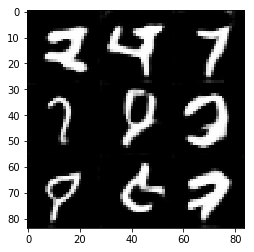

Epoch 1/2-Step 3510... Discriminator Loss: 1.5141... Generator Loss: 1.1573
Epoch 1/2-Step 3520... Discriminator Loss: 1.3913... Generator Loss: 0.3091
Epoch 1/2-Step 3530... Discriminator Loss: 1.5702... Generator Loss: 0.9008
Epoch 1/2-Step 3540... Discriminator Loss: 0.5940... Generator Loss: 2.6815
Epoch 1/2-Step 3550... Discriminator Loss: 0.9067... Generator Loss: 1.8273
Epoch 1/2-Step 3560... Discriminator Loss: 0.6312... Generator Loss: 2.2397
Epoch 1/2-Step 3570... Discriminator Loss: 0.9396... Generator Loss: 2.2278
Epoch 1/2-Step 3580... Discriminator Loss: 2.0399... Generator Loss: 0.5491
Epoch 1/2-Step 3590... Discriminator Loss: 0.9086... Generator Loss: 0.8842
Epoch 1/2-Step 3600... Discriminator Loss: 1.4444... Generator Loss: 1.0543


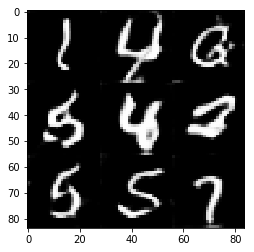

Epoch 1/2-Step 3610... Discriminator Loss: 0.5347... Generator Loss: 3.4708
Epoch 1/2-Step 3620... Discriminator Loss: 1.5718... Generator Loss: 0.7647
Epoch 1/2-Step 3630... Discriminator Loss: 0.8013... Generator Loss: 2.0245
Epoch 1/2-Step 3640... Discriminator Loss: 1.6968... Generator Loss: 2.3635
Epoch 1/2-Step 3650... Discriminator Loss: 0.6283... Generator Loss: 2.0152
Epoch 1/2-Step 3660... Discriminator Loss: 1.0592... Generator Loss: 1.0891
Epoch 1/2-Step 3670... Discriminator Loss: 0.5548... Generator Loss: 2.8192
Epoch 1/2-Step 3680... Discriminator Loss: 0.9127... Generator Loss: 1.8178
Epoch 1/2-Step 3690... Discriminator Loss: 2.0284... Generator Loss: 0.5596
Epoch 1/2-Step 3700... Discriminator Loss: 1.2324... Generator Loss: 1.1205


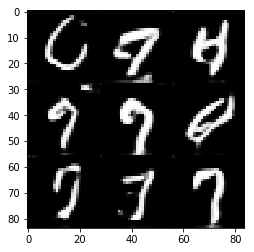

Epoch 1/2-Step 3710... Discriminator Loss: 1.1957... Generator Loss: 2.9403
Epoch 1/2-Step 3720... Discriminator Loss: 1.4918... Generator Loss: 0.9780
Epoch 1/2-Step 3730... Discriminator Loss: 0.8119... Generator Loss: 3.1082
Epoch 1/2-Step 3740... Discriminator Loss: 1.2655... Generator Loss: 1.1769
Epoch 1/2-Step 3750... Discriminator Loss: 1.7132... Generator Loss: 1.4216
Epoch 2/2-Step 3760... Discriminator Loss: 0.9273... Generator Loss: 1.4539
Epoch 2/2-Step 3770... Discriminator Loss: 0.6323... Generator Loss: 3.1133
Epoch 2/2-Step 3780... Discriminator Loss: 0.8319... Generator Loss: 2.0285
Epoch 2/2-Step 3790... Discriminator Loss: 1.2167... Generator Loss: 2.7195
Epoch 2/2-Step 3800... Discriminator Loss: 0.6840... Generator Loss: 2.4182


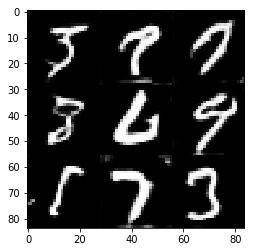

Epoch 2/2-Step 3810... Discriminator Loss: 0.8050... Generator Loss: 1.9574
Epoch 2/2-Step 3820... Discriminator Loss: 0.8091... Generator Loss: 1.1413
Epoch 2/2-Step 3830... Discriminator Loss: 1.0711... Generator Loss: 1.4569
Epoch 2/2-Step 3840... Discriminator Loss: 0.8343... Generator Loss: 2.4736
Epoch 2/2-Step 3850... Discriminator Loss: 0.9920... Generator Loss: 1.6217
Epoch 2/2-Step 3860... Discriminator Loss: 0.8220... Generator Loss: 2.2878
Epoch 2/2-Step 3870... Discriminator Loss: 1.2535... Generator Loss: 2.0134
Epoch 2/2-Step 3880... Discriminator Loss: 0.8582... Generator Loss: 2.1332
Epoch 2/2-Step 3890... Discriminator Loss: 2.4133... Generator Loss: 3.6196
Epoch 2/2-Step 3900... Discriminator Loss: 1.5483... Generator Loss: 0.9423


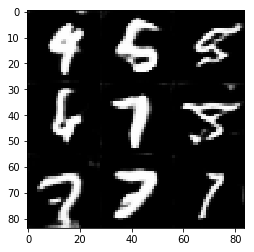

Epoch 2/2-Step 3910... Discriminator Loss: 0.7256... Generator Loss: 1.6172
Epoch 2/2-Step 3920... Discriminator Loss: 1.0606... Generator Loss: 1.3935
Epoch 2/2-Step 3930... Discriminator Loss: 0.6840... Generator Loss: 1.4029
Epoch 2/2-Step 3940... Discriminator Loss: 1.5648... Generator Loss: 0.4768
Epoch 2/2-Step 3950... Discriminator Loss: 1.8569... Generator Loss: 1.3834
Epoch 2/2-Step 3960... Discriminator Loss: 1.1159... Generator Loss: 3.2792
Epoch 2/2-Step 3970... Discriminator Loss: 0.6805... Generator Loss: 2.0604
Epoch 2/2-Step 3980... Discriminator Loss: 1.4394... Generator Loss: 0.6645
Epoch 2/2-Step 3990... Discriminator Loss: 0.6373... Generator Loss: 2.3259
Epoch 2/2-Step 4000... Discriminator Loss: 1.8258... Generator Loss: 1.6766


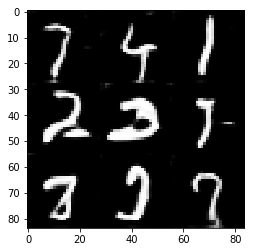

Epoch 2/2-Step 4010... Discriminator Loss: 2.5978... Generator Loss: 4.1080
Epoch 2/2-Step 4020... Discriminator Loss: 0.8558... Generator Loss: 1.7508
Epoch 2/2-Step 4030... Discriminator Loss: 1.1174... Generator Loss: 1.3364
Epoch 2/2-Step 4040... Discriminator Loss: 0.5710... Generator Loss: 2.5279
Epoch 2/2-Step 4050... Discriminator Loss: 0.5763... Generator Loss: 2.4129
Epoch 2/2-Step 4060... Discriminator Loss: 0.6498... Generator Loss: 3.9780
Epoch 2/2-Step 4070... Discriminator Loss: 0.8375... Generator Loss: 1.0327
Epoch 2/2-Step 4080... Discriminator Loss: 0.7236... Generator Loss: 2.0829
Epoch 2/2-Step 4090... Discriminator Loss: 1.0059... Generator Loss: 1.5619
Epoch 2/2-Step 4100... Discriminator Loss: 2.6371... Generator Loss: 0.4754


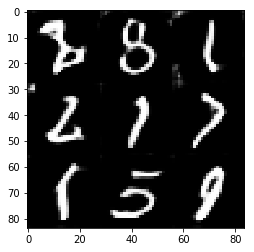

Epoch 2/2-Step 4110... Discriminator Loss: 0.8128... Generator Loss: 2.5129
Epoch 2/2-Step 4120... Discriminator Loss: 0.8923... Generator Loss: 1.5166
Epoch 2/2-Step 4130... Discriminator Loss: 0.8151... Generator Loss: 2.2795
Epoch 2/2-Step 4140... Discriminator Loss: 1.4754... Generator Loss: 4.0093
Epoch 2/2-Step 4150... Discriminator Loss: 0.8900... Generator Loss: 0.7977
Epoch 2/2-Step 4160... Discriminator Loss: 0.8838... Generator Loss: 2.2693
Epoch 2/2-Step 4170... Discriminator Loss: 1.5833... Generator Loss: 2.0589
Epoch 2/2-Step 4180... Discriminator Loss: 1.2953... Generator Loss: 2.0012
Epoch 2/2-Step 4190... Discriminator Loss: 1.0730... Generator Loss: 1.3989
Epoch 2/2-Step 4200... Discriminator Loss: 1.3883... Generator Loss: 2.0992


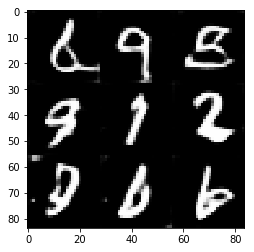

Epoch 2/2-Step 4210... Discriminator Loss: 1.0157... Generator Loss: 4.1873
Epoch 2/2-Step 4220... Discriminator Loss: 0.8365... Generator Loss: 1.9523
Epoch 2/2-Step 4230... Discriminator Loss: 0.6131... Generator Loss: 2.5284
Epoch 2/2-Step 4240... Discriminator Loss: 1.1748... Generator Loss: 1.3751
Epoch 2/2-Step 4250... Discriminator Loss: 0.6887... Generator Loss: 2.5840
Epoch 2/2-Step 4260... Discriminator Loss: 0.5632... Generator Loss: 3.1034
Epoch 2/2-Step 4270... Discriminator Loss: 0.7161... Generator Loss: 2.7014
Epoch 2/2-Step 4280... Discriminator Loss: 0.9079... Generator Loss: 3.0261
Epoch 2/2-Step 4290... Discriminator Loss: 0.8594... Generator Loss: 2.3147
Epoch 2/2-Step 4300... Discriminator Loss: 0.7226... Generator Loss: 2.9783


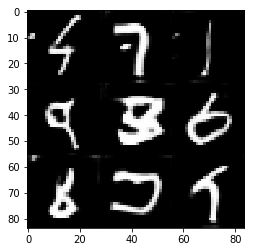

Epoch 2/2-Step 4310... Discriminator Loss: 0.7103... Generator Loss: 1.5627
Epoch 2/2-Step 4320... Discriminator Loss: 0.8324... Generator Loss: 1.3744
Epoch 2/2-Step 4330... Discriminator Loss: 1.1705... Generator Loss: 0.9826
Epoch 2/2-Step 4340... Discriminator Loss: 1.2036... Generator Loss: 3.3336
Epoch 2/2-Step 4350... Discriminator Loss: 0.5394... Generator Loss: 1.9205
Epoch 2/2-Step 4360... Discriminator Loss: 1.0280... Generator Loss: 1.7976
Epoch 2/2-Step 4370... Discriminator Loss: 1.0513... Generator Loss: 1.0484
Epoch 2/2-Step 4380... Discriminator Loss: 0.6092... Generator Loss: 1.4064
Epoch 2/2-Step 4390... Discriminator Loss: 0.7810... Generator Loss: 2.4568
Epoch 2/2-Step 4400... Discriminator Loss: 0.7146... Generator Loss: 1.3537


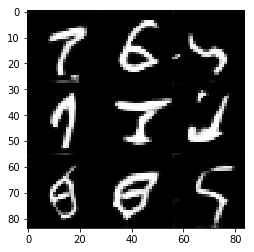

Epoch 2/2-Step 4410... Discriminator Loss: 1.7961... Generator Loss: 1.2303
Epoch 2/2-Step 4420... Discriminator Loss: 1.0087... Generator Loss: 2.6644
Epoch 2/2-Step 4430... Discriminator Loss: 1.1209... Generator Loss: 2.0010
Epoch 2/2-Step 4440... Discriminator Loss: 1.7087... Generator Loss: 3.2714
Epoch 2/2-Step 4450... Discriminator Loss: 0.8297... Generator Loss: 1.1483
Epoch 2/2-Step 4460... Discriminator Loss: 0.9406... Generator Loss: 3.2302
Epoch 2/2-Step 4470... Discriminator Loss: 1.4158... Generator Loss: 0.9934
Epoch 2/2-Step 4480... Discriminator Loss: 0.6997... Generator Loss: 2.7613
Epoch 2/2-Step 4490... Discriminator Loss: 1.0477... Generator Loss: 2.3829
Epoch 2/2-Step 4500... Discriminator Loss: 0.9892... Generator Loss: 1.7170


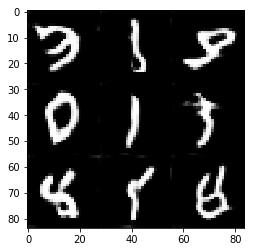

Epoch 2/2-Step 4510... Discriminator Loss: 1.6809... Generator Loss: 4.9071
Epoch 2/2-Step 4520... Discriminator Loss: 0.8174... Generator Loss: 1.7120
Epoch 2/2-Step 4530... Discriminator Loss: 0.5889... Generator Loss: 3.8659
Epoch 2/2-Step 4540... Discriminator Loss: 0.6366... Generator Loss: 1.8449
Epoch 2/2-Step 4550... Discriminator Loss: 0.6644... Generator Loss: 3.2493
Epoch 2/2-Step 4560... Discriminator Loss: 0.7319... Generator Loss: 3.4059
Epoch 2/2-Step 4570... Discriminator Loss: 1.6027... Generator Loss: 0.6539
Epoch 2/2-Step 4580... Discriminator Loss: 0.8634... Generator Loss: 1.0770
Epoch 2/2-Step 4590... Discriminator Loss: 0.8624... Generator Loss: 1.3737
Epoch 2/2-Step 4600... Discriminator Loss: 0.5867... Generator Loss: 1.8046


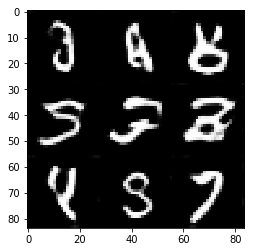

Epoch 2/2-Step 4610... Discriminator Loss: 1.1267... Generator Loss: 2.4996
Epoch 2/2-Step 4620... Discriminator Loss: 0.7398... Generator Loss: 3.9589
Epoch 2/2-Step 4630... Discriminator Loss: 1.1008... Generator Loss: 3.0764
Epoch 2/2-Step 4640... Discriminator Loss: 1.9842... Generator Loss: 0.8261
Epoch 2/2-Step 4650... Discriminator Loss: 0.6369... Generator Loss: 3.2500
Epoch 2/2-Step 4660... Discriminator Loss: 0.8727... Generator Loss: 1.3971
Epoch 2/2-Step 4670... Discriminator Loss: 0.5712... Generator Loss: 1.7606
Epoch 2/2-Step 4680... Discriminator Loss: 0.9897... Generator Loss: 1.4680
Epoch 2/2-Step 4690... Discriminator Loss: 0.7763... Generator Loss: 1.7340
Epoch 2/2-Step 4700... Discriminator Loss: 0.7342... Generator Loss: 2.0838


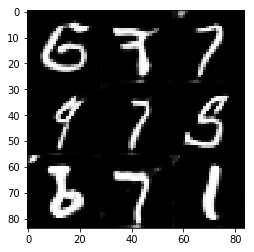

Epoch 2/2-Step 4710... Discriminator Loss: 1.3577... Generator Loss: 1.7229
Epoch 2/2-Step 4720... Discriminator Loss: 0.5806... Generator Loss: 3.3829
Epoch 2/2-Step 4730... Discriminator Loss: 0.8749... Generator Loss: 1.0274
Epoch 2/2-Step 4740... Discriminator Loss: 1.3508... Generator Loss: 2.4017
Epoch 2/2-Step 4750... Discriminator Loss: 0.7190... Generator Loss: 2.2952
Epoch 2/2-Step 4760... Discriminator Loss: 0.9876... Generator Loss: 3.0151
Epoch 2/2-Step 4770... Discriminator Loss: 2.9583... Generator Loss: 0.4921
Epoch 2/2-Step 4780... Discriminator Loss: 0.5907... Generator Loss: 1.9550
Epoch 2/2-Step 4790... Discriminator Loss: 0.5692... Generator Loss: 1.6081
Epoch 2/2-Step 4800... Discriminator Loss: 1.0259... Generator Loss: 0.6609


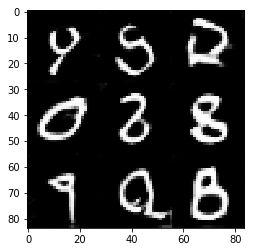

Epoch 2/2-Step 4810... Discriminator Loss: 2.0318... Generator Loss: 0.4954
Epoch 2/2-Step 4820... Discriminator Loss: 1.2075... Generator Loss: 1.6561
Epoch 2/2-Step 4830... Discriminator Loss: 0.6910... Generator Loss: 2.5186
Epoch 2/2-Step 4840... Discriminator Loss: 0.6184... Generator Loss: 2.7840
Epoch 2/2-Step 4850... Discriminator Loss: 0.8373... Generator Loss: 2.0886
Epoch 2/2-Step 4860... Discriminator Loss: 0.6483... Generator Loss: 1.9491
Epoch 2/2-Step 4870... Discriminator Loss: 0.7256... Generator Loss: 2.9973
Epoch 2/2-Step 4880... Discriminator Loss: 0.6956... Generator Loss: 2.6425
Epoch 2/2-Step 4890... Discriminator Loss: 1.1275... Generator Loss: 4.1734
Epoch 2/2-Step 4900... Discriminator Loss: 1.4497... Generator Loss: 1.6510


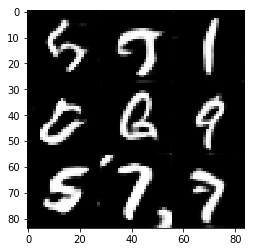

Epoch 2/2-Step 4910... Discriminator Loss: 1.2242... Generator Loss: 1.9881
Epoch 2/2-Step 4920... Discriminator Loss: 1.4209... Generator Loss: 1.2964
Epoch 2/2-Step 4930... Discriminator Loss: 1.1311... Generator Loss: 1.5902
Epoch 2/2-Step 4940... Discriminator Loss: 0.7357... Generator Loss: 3.3282
Epoch 2/2-Step 4950... Discriminator Loss: 0.6916... Generator Loss: 2.8701
Epoch 2/2-Step 4960... Discriminator Loss: 0.6660... Generator Loss: 3.8739
Epoch 2/2-Step 4970... Discriminator Loss: 0.6230... Generator Loss: 2.3669
Epoch 2/2-Step 4980... Discriminator Loss: 1.0523... Generator Loss: 2.5116
Epoch 2/2-Step 4990... Discriminator Loss: 0.9139... Generator Loss: 1.0435
Epoch 2/2-Step 5000... Discriminator Loss: 0.8021... Generator Loss: 3.0711


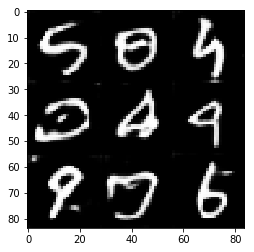

Epoch 2/2-Step 5010... Discriminator Loss: 0.6576... Generator Loss: 2.1492
Epoch 2/2-Step 5020... Discriminator Loss: 0.7555... Generator Loss: 2.1061
Epoch 2/2-Step 5030... Discriminator Loss: 1.2018... Generator Loss: 1.1961
Epoch 2/2-Step 5040... Discriminator Loss: 0.5098... Generator Loss: 2.7158
Epoch 2/2-Step 5050... Discriminator Loss: 0.8177... Generator Loss: 2.4968
Epoch 2/2-Step 5060... Discriminator Loss: 0.7574... Generator Loss: 3.0226
Epoch 2/2-Step 5070... Discriminator Loss: 0.6693... Generator Loss: 1.8254
Epoch 2/2-Step 5080... Discriminator Loss: 0.8775... Generator Loss: 1.7649
Epoch 2/2-Step 5090... Discriminator Loss: 1.0300... Generator Loss: 2.4597
Epoch 2/2-Step 5100... Discriminator Loss: 0.6733... Generator Loss: 2.5881


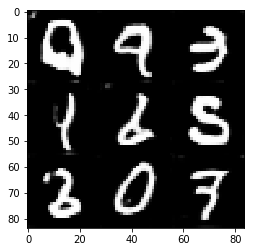

Epoch 2/2-Step 5110... Discriminator Loss: 0.7277... Generator Loss: 3.5191
Epoch 2/2-Step 5120... Discriminator Loss: 0.7121... Generator Loss: 2.9921
Epoch 2/2-Step 5130... Discriminator Loss: 0.6108... Generator Loss: 2.8381
Epoch 2/2-Step 5140... Discriminator Loss: 0.8490... Generator Loss: 2.5457
Epoch 2/2-Step 5150... Discriminator Loss: 0.5292... Generator Loss: 3.2059
Epoch 2/2-Step 5160... Discriminator Loss: 0.5909... Generator Loss: 1.5392
Epoch 2/2-Step 5170... Discriminator Loss: 0.8997... Generator Loss: 1.5416
Epoch 2/2-Step 5180... Discriminator Loss: 0.5973... Generator Loss: 2.8303
Epoch 2/2-Step 5190... Discriminator Loss: 1.2312... Generator Loss: 1.7203
Epoch 2/2-Step 5200... Discriminator Loss: 0.9359... Generator Loss: 1.5172


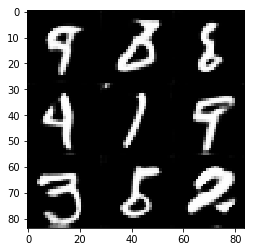

Epoch 2/2-Step 5210... Discriminator Loss: 0.6013... Generator Loss: 2.7446
Epoch 2/2-Step 5220... Discriminator Loss: 1.5900... Generator Loss: 1.7314
Epoch 2/2-Step 5230... Discriminator Loss: 1.3293... Generator Loss: 0.9577
Epoch 2/2-Step 5240... Discriminator Loss: 0.7651... Generator Loss: 4.5080
Epoch 2/2-Step 5250... Discriminator Loss: 0.8763... Generator Loss: 2.2820
Epoch 2/2-Step 5260... Discriminator Loss: 0.8644... Generator Loss: 1.7405
Epoch 2/2-Step 5270... Discriminator Loss: 1.2652... Generator Loss: 1.4441
Epoch 2/2-Step 5280... Discriminator Loss: 0.5929... Generator Loss: 1.8398
Epoch 2/2-Step 5290... Discriminator Loss: 0.5260... Generator Loss: 3.4115
Epoch 2/2-Step 5300... Discriminator Loss: 0.9375... Generator Loss: 1.7354


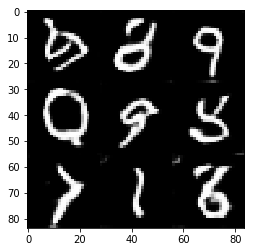

Epoch 2/2-Step 5310... Discriminator Loss: 0.9733... Generator Loss: 1.5390
Epoch 2/2-Step 5320... Discriminator Loss: 0.7806... Generator Loss: 2.0623
Epoch 2/2-Step 5330... Discriminator Loss: 0.4897... Generator Loss: 2.3890
Epoch 2/2-Step 5340... Discriminator Loss: 1.0056... Generator Loss: 2.0729
Epoch 2/2-Step 5350... Discriminator Loss: 0.6536... Generator Loss: 1.9443
Epoch 2/2-Step 5360... Discriminator Loss: 0.7212... Generator Loss: 2.3086
Epoch 2/2-Step 5370... Discriminator Loss: 0.7070... Generator Loss: 3.1036
Epoch 2/2-Step 5380... Discriminator Loss: 1.1220... Generator Loss: 1.6468
Epoch 2/2-Step 5390... Discriminator Loss: 0.5778... Generator Loss: 3.2888
Epoch 2/2-Step 5400... Discriminator Loss: 0.6168... Generator Loss: 2.5259


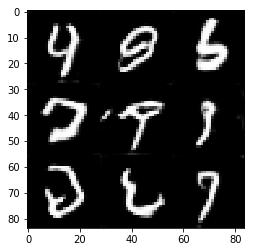

Epoch 2/2-Step 5410... Discriminator Loss: 0.5683... Generator Loss: 3.2456
Epoch 2/2-Step 5420... Discriminator Loss: 0.7777... Generator Loss: 1.4606
Epoch 2/2-Step 5430... Discriminator Loss: 0.6013... Generator Loss: 2.6161
Epoch 2/2-Step 5440... Discriminator Loss: 0.8191... Generator Loss: 2.7877
Epoch 2/2-Step 5450... Discriminator Loss: 0.6987... Generator Loss: 2.4595
Epoch 2/2-Step 5460... Discriminator Loss: 1.5040... Generator Loss: 0.6110
Epoch 2/2-Step 5470... Discriminator Loss: 0.8633... Generator Loss: 2.2098
Epoch 2/2-Step 5480... Discriminator Loss: 0.9388... Generator Loss: 1.8265
Epoch 2/2-Step 5490... Discriminator Loss: 0.7507... Generator Loss: 2.4642
Epoch 2/2-Step 5500... Discriminator Loss: 0.5585... Generator Loss: 3.2339


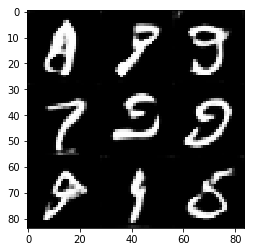

Epoch 2/2-Step 5510... Discriminator Loss: 0.6442... Generator Loss: 3.0003
Epoch 2/2-Step 5520... Discriminator Loss: 0.5520... Generator Loss: 2.7205
Epoch 2/2-Step 5530... Discriminator Loss: 0.8147... Generator Loss: 1.8698
Epoch 2/2-Step 5540... Discriminator Loss: 0.6854... Generator Loss: 1.3011
Epoch 2/2-Step 5550... Discriminator Loss: 0.5850... Generator Loss: 3.3359
Epoch 2/2-Step 5560... Discriminator Loss: 0.6005... Generator Loss: 2.6258
Epoch 2/2-Step 5570... Discriminator Loss: 0.6296... Generator Loss: 2.5284
Epoch 2/2-Step 5580... Discriminator Loss: 0.7324... Generator Loss: 4.1761
Epoch 2/2-Step 5590... Discriminator Loss: 0.7818... Generator Loss: 2.6275
Epoch 2/2-Step 5600... Discriminator Loss: 1.1629... Generator Loss: 0.8184


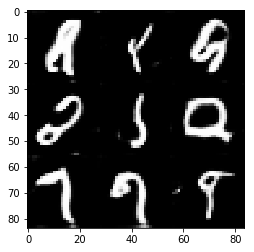

Epoch 2/2-Step 5610... Discriminator Loss: 0.8138... Generator Loss: 3.4572
Epoch 2/2-Step 5620... Discriminator Loss: 1.4815... Generator Loss: 1.7691
Epoch 2/2-Step 5630... Discriminator Loss: 0.4693... Generator Loss: 4.3668
Epoch 2/2-Step 5640... Discriminator Loss: 0.6629... Generator Loss: 1.5059
Epoch 2/2-Step 5650... Discriminator Loss: 0.8070... Generator Loss: 2.4559
Epoch 2/2-Step 5660... Discriminator Loss: 0.5123... Generator Loss: 2.6219
Epoch 2/2-Step 5670... Discriminator Loss: 1.4344... Generator Loss: 1.9084
Epoch 2/2-Step 5680... Discriminator Loss: 0.7615... Generator Loss: 3.0340
Epoch 2/2-Step 5690... Discriminator Loss: 1.0736... Generator Loss: 1.6895
Epoch 2/2-Step 5700... Discriminator Loss: 0.5061... Generator Loss: 3.1781


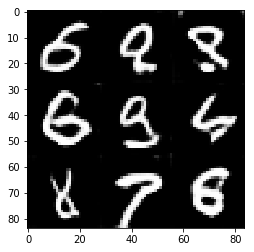

Epoch 2/2-Step 5710... Discriminator Loss: 0.5405... Generator Loss: 3.1697
Epoch 2/2-Step 5720... Discriminator Loss: 0.9135... Generator Loss: 3.4455
Epoch 2/2-Step 5730... Discriminator Loss: 0.7770... Generator Loss: 2.7214
Epoch 2/2-Step 5740... Discriminator Loss: 0.6653... Generator Loss: 1.8489
Epoch 2/2-Step 5750... Discriminator Loss: 1.6680... Generator Loss: 1.4212
Epoch 2/2-Step 5760... Discriminator Loss: 0.8880... Generator Loss: 1.8065
Epoch 2/2-Step 5770... Discriminator Loss: 0.5183... Generator Loss: 2.7174
Epoch 2/2-Step 5780... Discriminator Loss: 0.6663... Generator Loss: 3.2934
Epoch 2/2-Step 5790... Discriminator Loss: 0.7025... Generator Loss: 2.9029
Epoch 2/2-Step 5800... Discriminator Loss: 0.7466... Generator Loss: 2.9246


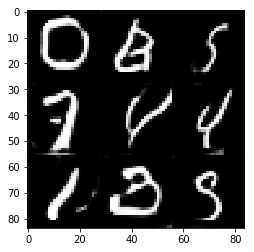

Epoch 2/2-Step 5810... Discriminator Loss: 0.6765... Generator Loss: 1.8345
Epoch 2/2-Step 5820... Discriminator Loss: 0.7103... Generator Loss: 1.7287
Epoch 2/2-Step 5830... Discriminator Loss: 0.5158... Generator Loss: 2.4167
Epoch 2/2-Step 5840... Discriminator Loss: 0.8594... Generator Loss: 4.9640
Epoch 2/2-Step 5850... Discriminator Loss: 0.6634... Generator Loss: 1.9108
Epoch 2/2-Step 5860... Discriminator Loss: 0.4578... Generator Loss: 2.7778
Epoch 2/2-Step 5870... Discriminator Loss: 0.8115... Generator Loss: 4.1891
Epoch 2/2-Step 5880... Discriminator Loss: 0.7035... Generator Loss: 2.7653
Epoch 2/2-Step 5890... Discriminator Loss: 0.9100... Generator Loss: 2.3595
Epoch 2/2-Step 5900... Discriminator Loss: 1.0375... Generator Loss: 2.1054


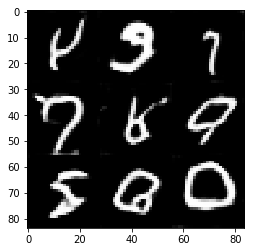

Epoch 2/2-Step 5910... Discriminator Loss: 0.7952... Generator Loss: 1.3918
Epoch 2/2-Step 5920... Discriminator Loss: 1.4054... Generator Loss: 1.2510
Epoch 2/2-Step 5930... Discriminator Loss: 0.7395... Generator Loss: 1.9064
Epoch 2/2-Step 5940... Discriminator Loss: 0.4409... Generator Loss: 2.9010
Epoch 2/2-Step 5950... Discriminator Loss: 0.9362... Generator Loss: 2.7503
Epoch 2/2-Step 5960... Discriminator Loss: 1.0228... Generator Loss: 1.4608
Epoch 2/2-Step 5970... Discriminator Loss: 2.3172... Generator Loss: 4.4076
Epoch 2/2-Step 5980... Discriminator Loss: 0.7294... Generator Loss: 3.3239
Epoch 2/2-Step 5990... Discriminator Loss: 1.6670... Generator Loss: 1.0813
Epoch 2/2-Step 6000... Discriminator Loss: 1.1560... Generator Loss: 1.4040


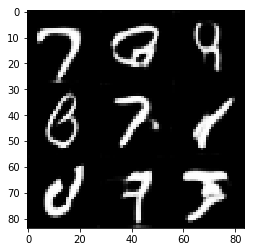

Epoch 2/2-Step 6010... Discriminator Loss: 1.0264... Generator Loss: 3.1394
Epoch 2/2-Step 6020... Discriminator Loss: 0.5920... Generator Loss: 1.7846
Epoch 2/2-Step 6030... Discriminator Loss: 0.4545... Generator Loss: 2.5640
Epoch 2/2-Step 6040... Discriminator Loss: 0.8280... Generator Loss: 1.3915
Epoch 2/2-Step 6050... Discriminator Loss: 0.5016... Generator Loss: 3.8219
Epoch 2/2-Step 6060... Discriminator Loss: 0.5244... Generator Loss: 3.0425
Epoch 2/2-Step 6070... Discriminator Loss: 0.6403... Generator Loss: 2.9120
Epoch 2/2-Step 6080... Discriminator Loss: 0.6300... Generator Loss: 2.6643
Epoch 2/2-Step 6090... Discriminator Loss: 0.6518... Generator Loss: 2.3819
Epoch 2/2-Step 6100... Discriminator Loss: 0.5038... Generator Loss: 2.9142


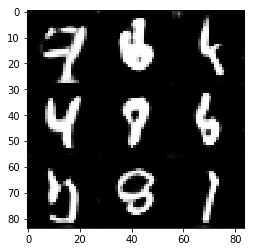

Epoch 2/2-Step 6110... Discriminator Loss: 3.3824... Generator Loss: 6.2745
Epoch 2/2-Step 6120... Discriminator Loss: 0.5492... Generator Loss: 2.6041
Epoch 2/2-Step 6130... Discriminator Loss: 1.5129... Generator Loss: 1.1538
Epoch 2/2-Step 6140... Discriminator Loss: 0.5757... Generator Loss: 2.4481
Epoch 2/2-Step 6150... Discriminator Loss: 0.7124... Generator Loss: 2.7547
Epoch 2/2-Step 6160... Discriminator Loss: 0.9600... Generator Loss: 2.4202
Epoch 2/2-Step 6170... Discriminator Loss: 0.5159... Generator Loss: 3.2544
Epoch 2/2-Step 6180... Discriminator Loss: 0.5769... Generator Loss: 2.4911
Epoch 2/2-Step 6190... Discriminator Loss: 0.7478... Generator Loss: 2.0725
Epoch 2/2-Step 6200... Discriminator Loss: 0.8396... Generator Loss: 2.0547


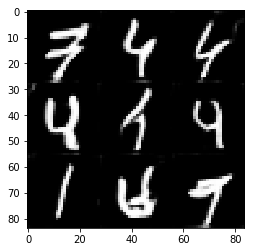

Epoch 2/2-Step 6210... Discriminator Loss: 0.5053... Generator Loss: 2.2907
Epoch 2/2-Step 6220... Discriminator Loss: 0.9117... Generator Loss: 1.2082
Epoch 2/2-Step 6230... Discriminator Loss: 0.8933... Generator Loss: 1.6245
Epoch 2/2-Step 6240... Discriminator Loss: 0.7024... Generator Loss: 2.7995
Epoch 2/2-Step 6250... Discriminator Loss: 0.6028... Generator Loss: 2.9859
Epoch 2/2-Step 6260... Discriminator Loss: 1.4206... Generator Loss: 1.4163
Epoch 2/2-Step 6270... Discriminator Loss: 0.7542... Generator Loss: 2.7978
Epoch 2/2-Step 6280... Discriminator Loss: 0.6178... Generator Loss: 3.6148
Epoch 2/2-Step 6290... Discriminator Loss: 0.7727... Generator Loss: 2.8502
Epoch 2/2-Step 6300... Discriminator Loss: 0.7728... Generator Loss: 1.8395


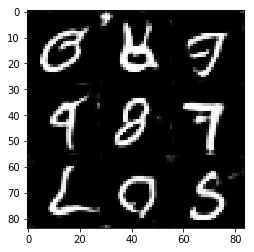

Epoch 2/2-Step 6310... Discriminator Loss: 0.8769... Generator Loss: 1.6217
Epoch 2/2-Step 6320... Discriminator Loss: 0.5226... Generator Loss: 2.1985
Epoch 2/2-Step 6330... Discriminator Loss: 1.0925... Generator Loss: 3.7481
Epoch 2/2-Step 6340... Discriminator Loss: 1.1286... Generator Loss: 2.2092
Epoch 2/2-Step 6350... Discriminator Loss: 0.5047... Generator Loss: 2.7746
Epoch 2/2-Step 6360... Discriminator Loss: 0.4286... Generator Loss: 4.3793
Epoch 2/2-Step 6370... Discriminator Loss: 0.7580... Generator Loss: 2.8480
Epoch 2/2-Step 6380... Discriminator Loss: 1.2151... Generator Loss: 1.8627
Epoch 2/2-Step 6390... Discriminator Loss: 0.6954... Generator Loss: 4.3327
Epoch 2/2-Step 6400... Discriminator Loss: 0.6671... Generator Loss: 2.2565


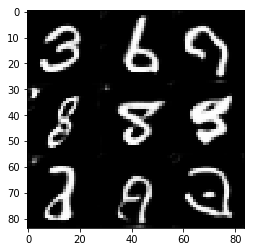

Epoch 2/2-Step 6410... Discriminator Loss: 1.0369... Generator Loss: 3.2546
Epoch 2/2-Step 6420... Discriminator Loss: 0.4658... Generator Loss: 2.5425
Epoch 2/2-Step 6430... Discriminator Loss: 0.6799... Generator Loss: 2.8313
Epoch 2/2-Step 6440... Discriminator Loss: 0.7715... Generator Loss: 2.1997
Epoch 2/2-Step 6450... Discriminator Loss: 0.5598... Generator Loss: 3.1018
Epoch 2/2-Step 6460... Discriminator Loss: 2.4926... Generator Loss: 0.2657
Epoch 2/2-Step 6470... Discriminator Loss: 0.5483... Generator Loss: 2.5166
Epoch 2/2-Step 6480... Discriminator Loss: 0.8568... Generator Loss: 1.0284
Epoch 2/2-Step 6490... Discriminator Loss: 0.9080... Generator Loss: 1.8248
Epoch 2/2-Step 6500... Discriminator Loss: 0.7513... Generator Loss: 1.2208


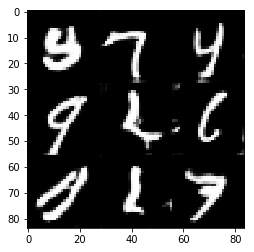

Epoch 2/2-Step 6510... Discriminator Loss: 0.8845... Generator Loss: 1.4787
Epoch 2/2-Step 6520... Discriminator Loss: 0.6351... Generator Loss: 2.3245
Epoch 2/2-Step 6530... Discriminator Loss: 0.6925... Generator Loss: 2.7838
Epoch 2/2-Step 6540... Discriminator Loss: 1.0024... Generator Loss: 1.8678
Epoch 2/2-Step 6550... Discriminator Loss: 0.4503... Generator Loss: 3.6231
Epoch 2/2-Step 6560... Discriminator Loss: 0.5370... Generator Loss: 1.9547
Epoch 2/2-Step 6570... Discriminator Loss: 0.8754... Generator Loss: 2.7954
Epoch 2/2-Step 6580... Discriminator Loss: 0.5483... Generator Loss: 1.0366
Epoch 2/2-Step 6590... Discriminator Loss: 0.8964... Generator Loss: 2.2711
Epoch 2/2-Step 6600... Discriminator Loss: 1.4574... Generator Loss: 1.0392


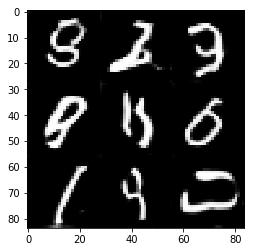

Epoch 2/2-Step 6610... Discriminator Loss: 0.7733... Generator Loss: 2.3364
Epoch 2/2-Step 6620... Discriminator Loss: 0.6323... Generator Loss: 2.2168
Epoch 2/2-Step 6630... Discriminator Loss: 0.7862... Generator Loss: 3.1674
Epoch 2/2-Step 6640... Discriminator Loss: 0.6309... Generator Loss: 2.5274
Epoch 2/2-Step 6650... Discriminator Loss: 0.4759... Generator Loss: 3.2742
Epoch 2/2-Step 6660... Discriminator Loss: 0.8597... Generator Loss: 2.6065
Epoch 2/2-Step 6670... Discriminator Loss: 0.4565... Generator Loss: 5.1126
Epoch 2/2-Step 6680... Discriminator Loss: 0.7354... Generator Loss: 2.6744
Epoch 2/2-Step 6690... Discriminator Loss: 1.1391... Generator Loss: 1.2024
Epoch 2/2-Step 6700... Discriminator Loss: 0.4862... Generator Loss: 2.8869


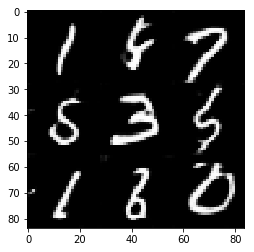

Epoch 2/2-Step 6710... Discriminator Loss: 1.7944... Generator Loss: 0.7128
Epoch 2/2-Step 6720... Discriminator Loss: 1.2603... Generator Loss: 1.0764
Epoch 2/2-Step 6730... Discriminator Loss: 0.7676... Generator Loss: 2.2555
Epoch 2/2-Step 6740... Discriminator Loss: 0.4053... Generator Loss: 3.8977
Epoch 2/2-Step 6750... Discriminator Loss: 0.5686... Generator Loss: 2.4416
Epoch 2/2-Step 6760... Discriminator Loss: 1.4201... Generator Loss: 0.9679
Epoch 2/2-Step 6770... Discriminator Loss: 1.9880... Generator Loss: 1.1824
Epoch 2/2-Step 6780... Discriminator Loss: 0.7021... Generator Loss: 3.8395
Epoch 2/2-Step 6790... Discriminator Loss: 0.5372... Generator Loss: 2.7730
Epoch 2/2-Step 6800... Discriminator Loss: 0.6950... Generator Loss: 2.6168


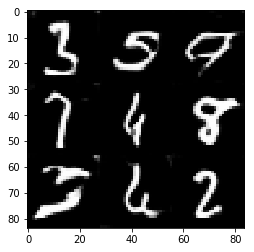

Epoch 2/2-Step 6810... Discriminator Loss: 0.6412... Generator Loss: 3.2091
Epoch 2/2-Step 6820... Discriminator Loss: 1.2548... Generator Loss: 1.8086
Epoch 2/2-Step 6830... Discriminator Loss: 0.5971... Generator Loss: 2.0719
Epoch 2/2-Step 6840... Discriminator Loss: 0.8948... Generator Loss: 3.3392
Epoch 2/2-Step 6850... Discriminator Loss: 0.7414... Generator Loss: 2.0902
Epoch 2/2-Step 6860... Discriminator Loss: 1.1879... Generator Loss: 1.7849
Epoch 2/2-Step 6870... Discriminator Loss: 0.6110... Generator Loss: 2.6223
Epoch 2/2-Step 6880... Discriminator Loss: 0.8266... Generator Loss: 1.6606
Epoch 2/2-Step 6890... Discriminator Loss: 0.7198... Generator Loss: 2.5820
Epoch 2/2-Step 6900... Discriminator Loss: 0.8805... Generator Loss: 3.3767


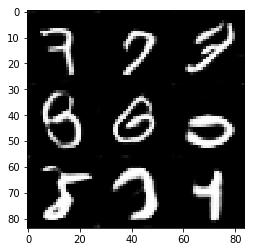

Epoch 2/2-Step 6910... Discriminator Loss: 0.7295... Generator Loss: 2.8159
Epoch 2/2-Step 6920... Discriminator Loss: 0.4606... Generator Loss: 3.3780
Epoch 2/2-Step 6930... Discriminator Loss: 0.4996... Generator Loss: 3.2139
Epoch 2/2-Step 6940... Discriminator Loss: 0.7106... Generator Loss: 2.6001
Epoch 2/2-Step 6950... Discriminator Loss: 0.5668... Generator Loss: 3.2564
Epoch 2/2-Step 6960... Discriminator Loss: 0.5170... Generator Loss: 1.9829
Epoch 2/2-Step 6970... Discriminator Loss: 0.7273... Generator Loss: 2.1486
Epoch 2/2-Step 6980... Discriminator Loss: 1.0883... Generator Loss: 0.9216
Epoch 2/2-Step 6990... Discriminator Loss: 0.6871... Generator Loss: 1.9921
Epoch 2/2-Step 7000... Discriminator Loss: 0.9391... Generator Loss: 1.9562


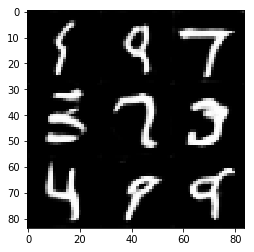

Epoch 2/2-Step 7010... Discriminator Loss: 1.3753... Generator Loss: 2.6379
Epoch 2/2-Step 7020... Discriminator Loss: 1.4447... Generator Loss: 2.1549
Epoch 2/2-Step 7030... Discriminator Loss: 0.6425... Generator Loss: 5.0186
Epoch 2/2-Step 7040... Discriminator Loss: 0.6218... Generator Loss: 2.4475
Epoch 2/2-Step 7050... Discriminator Loss: 0.4471... Generator Loss: 2.5640
Epoch 2/2-Step 7060... Discriminator Loss: 1.1542... Generator Loss: 2.3678
Epoch 2/2-Step 7070... Discriminator Loss: 0.9305... Generator Loss: 1.9455
Epoch 2/2-Step 7080... Discriminator Loss: 0.9533... Generator Loss: 2.5780
Epoch 2/2-Step 7090... Discriminator Loss: 0.6289... Generator Loss: 2.9755
Epoch 2/2-Step 7100... Discriminator Loss: 0.5540... Generator Loss: 2.8860


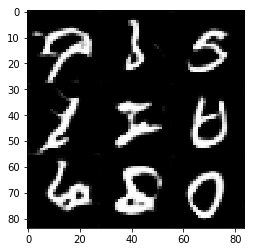

Epoch 2/2-Step 7110... Discriminator Loss: 1.1568... Generator Loss: 0.4607
Epoch 2/2-Step 7120... Discriminator Loss: 0.5529... Generator Loss: 2.9060
Epoch 2/2-Step 7130... Discriminator Loss: 0.5750... Generator Loss: 1.9021
Epoch 2/2-Step 7140... Discriminator Loss: 0.5779... Generator Loss: 3.6781
Epoch 2/2-Step 7150... Discriminator Loss: 2.8000... Generator Loss: 0.6050
Epoch 2/2-Step 7160... Discriminator Loss: 0.6821... Generator Loss: 1.6332
Epoch 2/2-Step 7170... Discriminator Loss: 0.5249... Generator Loss: 4.1212
Epoch 2/2-Step 7180... Discriminator Loss: 0.7032... Generator Loss: 2.5562
Epoch 2/2-Step 7190... Discriminator Loss: 1.2260... Generator Loss: 2.8265
Epoch 2/2-Step 7200... Discriminator Loss: 0.5276... Generator Loss: 3.0845


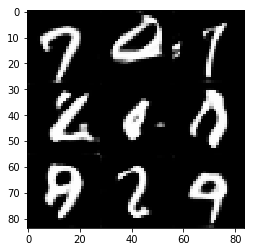

Epoch 2/2-Step 7210... Discriminator Loss: 0.5545... Generator Loss: 5.3410
Epoch 2/2-Step 7220... Discriminator Loss: 0.6709... Generator Loss: 1.7314
Epoch 2/2-Step 7230... Discriminator Loss: 0.9212... Generator Loss: 1.9842
Epoch 2/2-Step 7240... Discriminator Loss: 1.1896... Generator Loss: 1.3528
Epoch 2/2-Step 7250... Discriminator Loss: 1.8491... Generator Loss: 1.0279
Epoch 2/2-Step 7260... Discriminator Loss: 1.1249... Generator Loss: 1.9241
Epoch 2/2-Step 7270... Discriminator Loss: 0.6457... Generator Loss: 1.8654
Epoch 2/2-Step 7280... Discriminator Loss: 1.0057... Generator Loss: 1.0534
Epoch 2/2-Step 7290... Discriminator Loss: 0.5613... Generator Loss: 2.1446
Epoch 2/2-Step 7300... Discriminator Loss: 1.4272... Generator Loss: 4.6810


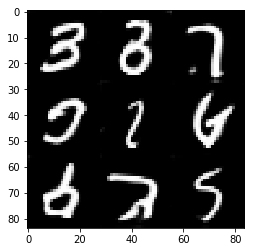

Epoch 2/2-Step 7310... Discriminator Loss: 0.4885... Generator Loss: 3.5997
Epoch 2/2-Step 7320... Discriminator Loss: 0.5702... Generator Loss: 3.4760
Epoch 2/2-Step 7330... Discriminator Loss: 0.4456... Generator Loss: 2.9317
Epoch 2/2-Step 7340... Discriminator Loss: 0.6239... Generator Loss: 4.1287
Epoch 2/2-Step 7350... Discriminator Loss: 0.6633... Generator Loss: 1.7932
Epoch 2/2-Step 7360... Discriminator Loss: 0.7431... Generator Loss: 2.4085
Epoch 2/2-Step 7370... Discriminator Loss: 1.0659... Generator Loss: 1.5433
Epoch 2/2-Step 7380... Discriminator Loss: 0.5794... Generator Loss: 3.3885
Epoch 2/2-Step 7390... Discriminator Loss: 0.8348... Generator Loss: 2.1125
Epoch 2/2-Step 7400... Discriminator Loss: 0.6078... Generator Loss: 2.4070


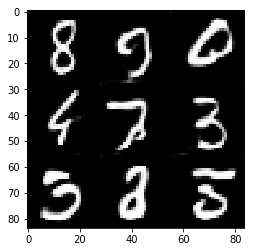

Epoch 2/2-Step 7410... Discriminator Loss: 0.5395... Generator Loss: 2.3707
Epoch 2/2-Step 7420... Discriminator Loss: 0.5152... Generator Loss: 2.2250
Epoch 2/2-Step 7430... Discriminator Loss: 0.6904... Generator Loss: 2.1426
Epoch 2/2-Step 7440... Discriminator Loss: 2.0568... Generator Loss: 1.2556
Epoch 2/2-Step 7450... Discriminator Loss: 0.5332... Generator Loss: 3.8167
Epoch 2/2-Step 7460... Discriminator Loss: 1.0589... Generator Loss: 1.5023
Epoch 2/2-Step 7470... Discriminator Loss: 0.5698... Generator Loss: 2.2062
Epoch 2/2-Step 7480... Discriminator Loss: 0.8149... Generator Loss: 2.4610
Epoch 2/2-Step 7490... Discriminator Loss: 0.6703... Generator Loss: 2.3635
Epoch 2/2-Step 7500... Discriminator Loss: 0.4998... Generator Loss: 3.8136


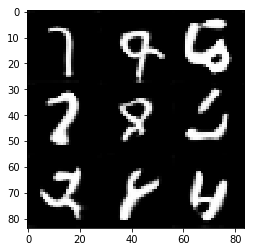

In [17]:
batch_size = 16
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1-Step 10... Discriminator Loss: 0.6948... Generator Loss: 3.3452
Epoch 1/1-Step 20... Discriminator Loss: 0.5769... Generator Loss: 2.6424
Epoch 1/1-Step 30... Discriminator Loss: 3.4842... Generator Loss: 0.3680
Epoch 1/1-Step 40... Discriminator Loss: 2.2605... Generator Loss: 1.0264
Epoch 1/1-Step 50... Discriminator Loss: 2.2086... Generator Loss: 1.0365
Epoch 1/1-Step 60... Discriminator Loss: 1.3705... Generator Loss: 1.3561
Epoch 1/1-Step 70... Discriminator Loss: 0.8398... Generator Loss: 3.7831
Epoch 1/1-Step 80... Discriminator Loss: 0.9082... Generator Loss: 3.3262
Epoch 1/1-Step 90... Discriminator Loss: 0.6524... Generator Loss: 4.4925
Epoch 1/1-Step 100... Discriminator Loss: 0.8634... Generator Loss: 2.0833


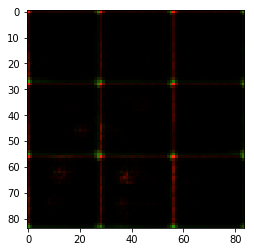

Epoch 1/1-Step 110... Discriminator Loss: 0.5612... Generator Loss: 6.2238
Epoch 1/1-Step 120... Discriminator Loss: 0.4266... Generator Loss: 4.6407
Epoch 1/1-Step 130... Discriminator Loss: 0.5806... Generator Loss: 3.8676
Epoch 1/1-Step 140... Discriminator Loss: 0.6074... Generator Loss: 3.3198
Epoch 1/1-Step 150... Discriminator Loss: 0.6334... Generator Loss: 3.1457
Epoch 1/1-Step 160... Discriminator Loss: 1.4266... Generator Loss: 1.7842
Epoch 1/1-Step 170... Discriminator Loss: 0.6803... Generator Loss: 4.0512
Epoch 1/1-Step 180... Discriminator Loss: 0.5272... Generator Loss: 5.1044
Epoch 1/1-Step 190... Discriminator Loss: 0.8611... Generator Loss: 3.0120
Epoch 1/1-Step 200... Discriminator Loss: 0.5037... Generator Loss: 3.2993


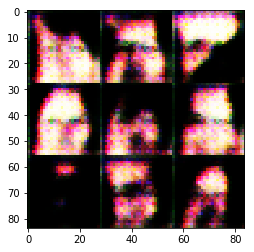

Epoch 1/1-Step 210... Discriminator Loss: 2.2002... Generator Loss: 0.6803
Epoch 1/1-Step 220... Discriminator Loss: 2.9776... Generator Loss: 7.8913
Epoch 1/1-Step 230... Discriminator Loss: 0.9352... Generator Loss: 3.2061
Epoch 1/1-Step 240... Discriminator Loss: 1.5503... Generator Loss: 0.8233
Epoch 1/1-Step 250... Discriminator Loss: 2.4947... Generator Loss: 5.8038
Epoch 1/1-Step 260... Discriminator Loss: 1.3574... Generator Loss: 3.7615
Epoch 1/1-Step 270... Discriminator Loss: 0.9844... Generator Loss: 1.6795
Epoch 1/1-Step 280... Discriminator Loss: 1.3204... Generator Loss: 1.8406
Epoch 1/1-Step 290... Discriminator Loss: 1.5406... Generator Loss: 1.4763
Epoch 1/1-Step 300... Discriminator Loss: 1.6007... Generator Loss: 0.9111


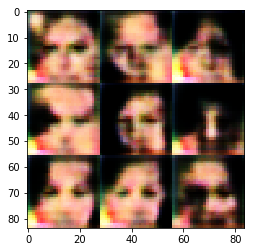

Epoch 1/1-Step 310... Discriminator Loss: 1.4419... Generator Loss: 0.5854
Epoch 1/1-Step 320... Discriminator Loss: 1.4496... Generator Loss: 1.6651
Epoch 1/1-Step 330... Discriminator Loss: 1.5146... Generator Loss: 2.6899
Epoch 1/1-Step 340... Discriminator Loss: 1.1532... Generator Loss: 1.6639
Epoch 1/1-Step 350... Discriminator Loss: 1.6224... Generator Loss: 4.0044
Epoch 1/1-Step 360... Discriminator Loss: 1.8819... Generator Loss: 0.6789
Epoch 1/1-Step 370... Discriminator Loss: 2.3529... Generator Loss: 0.6585
Epoch 1/1-Step 380... Discriminator Loss: 1.6916... Generator Loss: 1.7879
Epoch 1/1-Step 390... Discriminator Loss: 1.1988... Generator Loss: 1.9067
Epoch 1/1-Step 400... Discriminator Loss: 1.2352... Generator Loss: 2.3775


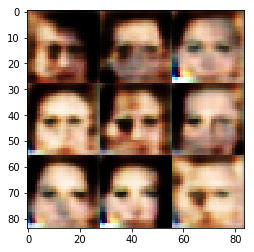

Epoch 1/1-Step 410... Discriminator Loss: 1.3067... Generator Loss: 0.9307
Epoch 1/1-Step 420... Discriminator Loss: 1.7364... Generator Loss: 1.5132
Epoch 1/1-Step 430... Discriminator Loss: 1.5336... Generator Loss: 0.5122
Epoch 1/1-Step 440... Discriminator Loss: 1.1227... Generator Loss: 1.1711
Epoch 1/1-Step 450... Discriminator Loss: 1.4362... Generator Loss: 0.8495
Epoch 1/1-Step 460... Discriminator Loss: 1.5072... Generator Loss: 1.4957
Epoch 1/1-Step 470... Discriminator Loss: 1.5810... Generator Loss: 0.6281
Epoch 1/1-Step 480... Discriminator Loss: 1.5124... Generator Loss: 1.3238
Epoch 1/1-Step 490... Discriminator Loss: 1.3301... Generator Loss: 1.0135
Epoch 1/1-Step 500... Discriminator Loss: 1.2923... Generator Loss: 1.4120


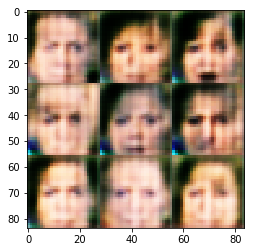

Epoch 1/1-Step 510... Discriminator Loss: 1.2858... Generator Loss: 1.0359
Epoch 1/1-Step 520... Discriminator Loss: 1.2062... Generator Loss: 0.6443
Epoch 1/1-Step 530... Discriminator Loss: 2.0740... Generator Loss: 0.6347
Epoch 1/1-Step 540... Discriminator Loss: 2.0029... Generator Loss: 0.9360
Epoch 1/1-Step 550... Discriminator Loss: 1.6063... Generator Loss: 1.0159
Epoch 1/1-Step 560... Discriminator Loss: 1.8288... Generator Loss: 1.1525
Epoch 1/1-Step 570... Discriminator Loss: 1.4487... Generator Loss: 0.8964
Epoch 1/1-Step 580... Discriminator Loss: 1.6944... Generator Loss: 0.6237
Epoch 1/1-Step 590... Discriminator Loss: 1.6855... Generator Loss: 0.6829
Epoch 1/1-Step 600... Discriminator Loss: 2.1247... Generator Loss: 0.6535


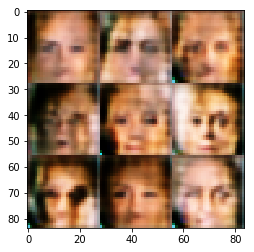

Epoch 1/1-Step 610... Discriminator Loss: 1.6402... Generator Loss: 0.8048
Epoch 1/1-Step 620... Discriminator Loss: 1.1703... Generator Loss: 0.9652
Epoch 1/1-Step 630... Discriminator Loss: 1.3092... Generator Loss: 1.4569
Epoch 1/1-Step 640... Discriminator Loss: 1.6696... Generator Loss: 1.1008
Epoch 1/1-Step 650... Discriminator Loss: 1.5877... Generator Loss: 0.7111
Epoch 1/1-Step 660... Discriminator Loss: 1.8134... Generator Loss: 0.7386
Epoch 1/1-Step 670... Discriminator Loss: 2.1744... Generator Loss: 0.7673
Epoch 1/1-Step 680... Discriminator Loss: 2.2540... Generator Loss: 0.3870
Epoch 1/1-Step 690... Discriminator Loss: 1.6325... Generator Loss: 0.7615
Epoch 1/1-Step 700... Discriminator Loss: 1.6979... Generator Loss: 1.1176


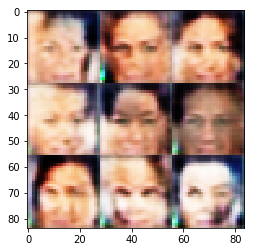

Epoch 1/1-Step 710... Discriminator Loss: 1.9598... Generator Loss: 0.8296
Epoch 1/1-Step 720... Discriminator Loss: 1.7752... Generator Loss: 0.7731
Epoch 1/1-Step 730... Discriminator Loss: 1.5313... Generator Loss: 0.7340
Epoch 1/1-Step 740... Discriminator Loss: 1.1701... Generator Loss: 1.2715
Epoch 1/1-Step 750... Discriminator Loss: 1.2427... Generator Loss: 0.8173
Epoch 1/1-Step 760... Discriminator Loss: 1.0936... Generator Loss: 1.4787
Epoch 1/1-Step 770... Discriminator Loss: 2.0332... Generator Loss: 0.8092
Epoch 1/1-Step 780... Discriminator Loss: 1.2748... Generator Loss: 1.9173
Epoch 1/1-Step 790... Discriminator Loss: 1.3099... Generator Loss: 1.0320
Epoch 1/1-Step 800... Discriminator Loss: 1.5100... Generator Loss: 0.8716


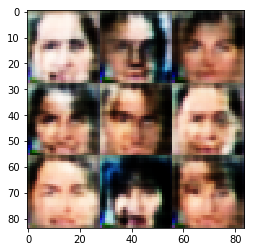

Epoch 1/1-Step 810... Discriminator Loss: 1.6640... Generator Loss: 0.7023
Epoch 1/1-Step 820... Discriminator Loss: 1.9084... Generator Loss: 0.7063
Epoch 1/1-Step 830... Discriminator Loss: 2.1551... Generator Loss: 0.5465
Epoch 1/1-Step 840... Discriminator Loss: 1.4073... Generator Loss: 0.9880
Epoch 1/1-Step 850... Discriminator Loss: 1.7260... Generator Loss: 1.0925
Epoch 1/1-Step 860... Discriminator Loss: 1.6906... Generator Loss: 1.1531
Epoch 1/1-Step 870... Discriminator Loss: 1.6929... Generator Loss: 1.0397
Epoch 1/1-Step 880... Discriminator Loss: 1.7217... Generator Loss: 0.6234
Epoch 1/1-Step 890... Discriminator Loss: 1.5626... Generator Loss: 0.8849
Epoch 1/1-Step 900... Discriminator Loss: 1.6365... Generator Loss: 0.7064


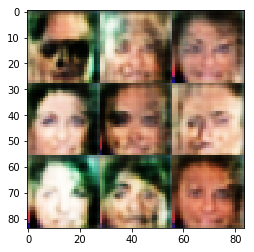

Epoch 1/1-Step 910... Discriminator Loss: 1.9951... Generator Loss: 0.8262
Epoch 1/1-Step 920... Discriminator Loss: 1.7126... Generator Loss: 0.7016
Epoch 1/1-Step 930... Discriminator Loss: 1.5343... Generator Loss: 0.8135
Epoch 1/1-Step 940... Discriminator Loss: 1.7239... Generator Loss: 0.6900
Epoch 1/1-Step 950... Discriminator Loss: 2.1409... Generator Loss: 0.4529
Epoch 1/1-Step 960... Discriminator Loss: 1.6916... Generator Loss: 1.2056
Epoch 1/1-Step 970... Discriminator Loss: 1.5968... Generator Loss: 1.1107
Epoch 1/1-Step 980... Discriminator Loss: 1.7231... Generator Loss: 0.7267
Epoch 1/1-Step 990... Discriminator Loss: 1.6630... Generator Loss: 1.0557
Epoch 1/1-Step 1000... Discriminator Loss: 1.8460... Generator Loss: 0.5424


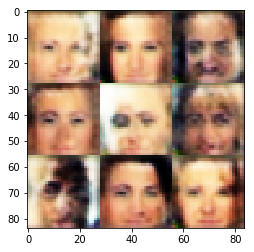

Epoch 1/1-Step 1010... Discriminator Loss: 1.5158... Generator Loss: 1.2338
Epoch 1/1-Step 1020... Discriminator Loss: 1.5908... Generator Loss: 0.7055
Epoch 1/1-Step 1030... Discriminator Loss: 1.8326... Generator Loss: 0.4710
Epoch 1/1-Step 1040... Discriminator Loss: 1.7935... Generator Loss: 0.8422
Epoch 1/1-Step 1050... Discriminator Loss: 2.0195... Generator Loss: 1.3330
Epoch 1/1-Step 1060... Discriminator Loss: 1.3615... Generator Loss: 1.0103
Epoch 1/1-Step 1070... Discriminator Loss: 1.7121... Generator Loss: 0.9841
Epoch 1/1-Step 1080... Discriminator Loss: 1.3754... Generator Loss: 0.8956
Epoch 1/1-Step 1090... Discriminator Loss: 1.7888... Generator Loss: 0.5945
Epoch 1/1-Step 1100... Discriminator Loss: 1.5493... Generator Loss: 0.8137


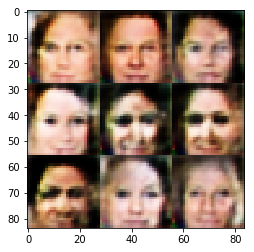

Epoch 1/1-Step 1110... Discriminator Loss: 1.7020... Generator Loss: 1.1219
Epoch 1/1-Step 1120... Discriminator Loss: 1.4937... Generator Loss: 0.7029
Epoch 1/1-Step 1130... Discriminator Loss: 1.7009... Generator Loss: 0.7746
Epoch 1/1-Step 1140... Discriminator Loss: 1.2564... Generator Loss: 0.6284
Epoch 1/1-Step 1150... Discriminator Loss: 1.7295... Generator Loss: 0.9546
Epoch 1/1-Step 1160... Discriminator Loss: 1.8282... Generator Loss: 0.8065
Epoch 1/1-Step 1170... Discriminator Loss: 1.3862... Generator Loss: 0.8113
Epoch 1/1-Step 1180... Discriminator Loss: 1.5680... Generator Loss: 0.7849
Epoch 1/1-Step 1190... Discriminator Loss: 1.6002... Generator Loss: 1.1626
Epoch 1/1-Step 1200... Discriminator Loss: 2.1050... Generator Loss: 0.7167


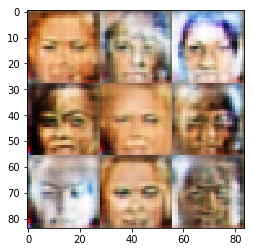

Epoch 1/1-Step 1210... Discriminator Loss: 1.3510... Generator Loss: 0.8378
Epoch 1/1-Step 1220... Discriminator Loss: 1.6236... Generator Loss: 0.9097
Epoch 1/1-Step 1230... Discriminator Loss: 1.8415... Generator Loss: 0.8852
Epoch 1/1-Step 1240... Discriminator Loss: 1.7693... Generator Loss: 0.7753
Epoch 1/1-Step 1250... Discriminator Loss: 1.2858... Generator Loss: 0.8492
Epoch 1/1-Step 1260... Discriminator Loss: 1.6172... Generator Loss: 1.2246
Epoch 1/1-Step 1270... Discriminator Loss: 1.7066... Generator Loss: 1.0093
Epoch 1/1-Step 1280... Discriminator Loss: 1.5132... Generator Loss: 0.5467
Epoch 1/1-Step 1290... Discriminator Loss: 1.7384... Generator Loss: 1.1565
Epoch 1/1-Step 1300... Discriminator Loss: 1.5952... Generator Loss: 0.9479


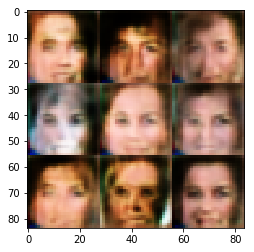

Epoch 1/1-Step 1310... Discriminator Loss: 1.5791... Generator Loss: 0.7702
Epoch 1/1-Step 1320... Discriminator Loss: 1.5233... Generator Loss: 0.9316
Epoch 1/1-Step 1330... Discriminator Loss: 1.6127... Generator Loss: 0.7162
Epoch 1/1-Step 1340... Discriminator Loss: 1.3950... Generator Loss: 1.0200
Epoch 1/1-Step 1350... Discriminator Loss: 1.6048... Generator Loss: 0.9939
Epoch 1/1-Step 1360... Discriminator Loss: 1.5611... Generator Loss: 0.7043
Epoch 1/1-Step 1370... Discriminator Loss: 1.2425... Generator Loss: 0.6983
Epoch 1/1-Step 1380... Discriminator Loss: 1.4157... Generator Loss: 0.8952
Epoch 1/1-Step 1390... Discriminator Loss: 1.5383... Generator Loss: 0.7594
Epoch 1/1-Step 1400... Discriminator Loss: 1.3918... Generator Loss: 0.7269


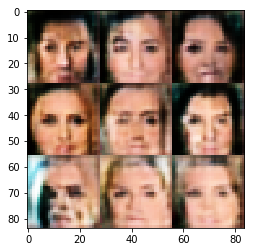

Epoch 1/1-Step 1410... Discriminator Loss: 1.5596... Generator Loss: 0.8909
Epoch 1/1-Step 1420... Discriminator Loss: 1.2898... Generator Loss: 0.8900
Epoch 1/1-Step 1430... Discriminator Loss: 1.2925... Generator Loss: 0.8084
Epoch 1/1-Step 1440... Discriminator Loss: 1.5554... Generator Loss: 0.8446
Epoch 1/1-Step 1450... Discriminator Loss: 1.5379... Generator Loss: 0.7816
Epoch 1/1-Step 1460... Discriminator Loss: 1.5530... Generator Loss: 0.6510
Epoch 1/1-Step 1470... Discriminator Loss: 1.4320... Generator Loss: 0.9174
Epoch 1/1-Step 1480... Discriminator Loss: 1.2774... Generator Loss: 0.9591
Epoch 1/1-Step 1490... Discriminator Loss: 1.5630... Generator Loss: 0.9092
Epoch 1/1-Step 1500... Discriminator Loss: 1.3316... Generator Loss: 0.9412


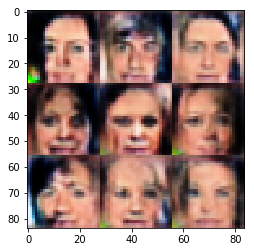

Epoch 1/1-Step 1510... Discriminator Loss: 1.5263... Generator Loss: 1.1853
Epoch 1/1-Step 1520... Discriminator Loss: 1.4308... Generator Loss: 0.7497
Epoch 1/1-Step 1530... Discriminator Loss: 1.2168... Generator Loss: 0.8292
Epoch 1/1-Step 1540... Discriminator Loss: 1.7063... Generator Loss: 0.8995
Epoch 1/1-Step 1550... Discriminator Loss: 1.4971... Generator Loss: 0.7941
Epoch 1/1-Step 1560... Discriminator Loss: 1.3980... Generator Loss: 0.8901
Epoch 1/1-Step 1570... Discriminator Loss: 1.5415... Generator Loss: 0.7382
Epoch 1/1-Step 1580... Discriminator Loss: 1.7079... Generator Loss: 0.7632
Epoch 1/1-Step 1590... Discriminator Loss: 1.7465... Generator Loss: 0.9167
Epoch 1/1-Step 1600... Discriminator Loss: 1.5987... Generator Loss: 0.7269


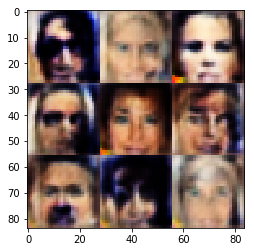

Epoch 1/1-Step 1610... Discriminator Loss: 1.7159... Generator Loss: 0.5133
Epoch 1/1-Step 1620... Discriminator Loss: 1.6374... Generator Loss: 1.0111
Epoch 1/1-Step 1630... Discriminator Loss: 1.7641... Generator Loss: 0.6404
Epoch 1/1-Step 1640... Discriminator Loss: 1.2147... Generator Loss: 0.8429
Epoch 1/1-Step 1650... Discriminator Loss: 1.3339... Generator Loss: 0.8591
Epoch 1/1-Step 1660... Discriminator Loss: 1.8727... Generator Loss: 0.6742
Epoch 1/1-Step 1670... Discriminator Loss: 1.5134... Generator Loss: 0.7987
Epoch 1/1-Step 1680... Discriminator Loss: 1.4782... Generator Loss: 0.7062
Epoch 1/1-Step 1690... Discriminator Loss: 1.6095... Generator Loss: 0.7445
Epoch 1/1-Step 1700... Discriminator Loss: 1.7461... Generator Loss: 0.9126


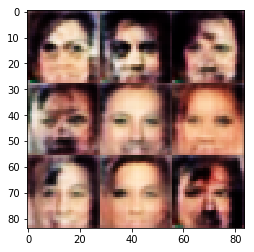

Epoch 1/1-Step 1710... Discriminator Loss: 2.0156... Generator Loss: 0.3896
Epoch 1/1-Step 1720... Discriminator Loss: 1.7540... Generator Loss: 0.6926
Epoch 1/1-Step 1730... Discriminator Loss: 1.7513... Generator Loss: 0.6261
Epoch 1/1-Step 1740... Discriminator Loss: 1.6404... Generator Loss: 0.7288
Epoch 1/1-Step 1750... Discriminator Loss: 1.5012... Generator Loss: 0.8576
Epoch 1/1-Step 1760... Discriminator Loss: 1.6337... Generator Loss: 0.8478
Epoch 1/1-Step 1770... Discriminator Loss: 1.2683... Generator Loss: 0.8922
Epoch 1/1-Step 1780... Discriminator Loss: 1.5020... Generator Loss: 0.9028
Epoch 1/1-Step 1790... Discriminator Loss: 1.4300... Generator Loss: 0.8794
Epoch 1/1-Step 1800... Discriminator Loss: 1.4853... Generator Loss: 0.7850


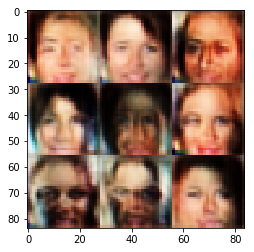

Epoch 1/1-Step 1810... Discriminator Loss: 1.4165... Generator Loss: 0.8949
Epoch 1/1-Step 1820... Discriminator Loss: 1.5920... Generator Loss: 0.8032
Epoch 1/1-Step 1830... Discriminator Loss: 1.4096... Generator Loss: 0.7035
Epoch 1/1-Step 1840... Discriminator Loss: 1.5037... Generator Loss: 0.7921
Epoch 1/1-Step 1850... Discriminator Loss: 2.2428... Generator Loss: 0.6911
Epoch 1/1-Step 1860... Discriminator Loss: 1.6131... Generator Loss: 0.7686
Epoch 1/1-Step 1870... Discriminator Loss: 1.5115... Generator Loss: 0.8898
Epoch 1/1-Step 1880... Discriminator Loss: 1.4410... Generator Loss: 0.8098
Epoch 1/1-Step 1890... Discriminator Loss: 1.4782... Generator Loss: 0.7205
Epoch 1/1-Step 1900... Discriminator Loss: 1.5556... Generator Loss: 0.9096


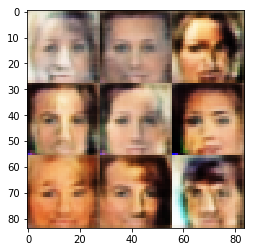

Epoch 1/1-Step 1910... Discriminator Loss: 1.5507... Generator Loss: 0.7454
Epoch 1/1-Step 1920... Discriminator Loss: 1.4829... Generator Loss: 0.9165
Epoch 1/1-Step 1930... Discriminator Loss: 1.4526... Generator Loss: 0.9627
Epoch 1/1-Step 1940... Discriminator Loss: 1.6984... Generator Loss: 0.8435
Epoch 1/1-Step 1950... Discriminator Loss: 1.2613... Generator Loss: 0.7659
Epoch 1/1-Step 1960... Discriminator Loss: 1.6145... Generator Loss: 0.5836
Epoch 1/1-Step 1970... Discriminator Loss: 1.7177... Generator Loss: 0.8831
Epoch 1/1-Step 1980... Discriminator Loss: 1.5243... Generator Loss: 0.8181
Epoch 1/1-Step 1990... Discriminator Loss: 1.4158... Generator Loss: 0.7466
Epoch 1/1-Step 2000... Discriminator Loss: 1.4195... Generator Loss: 0.6145


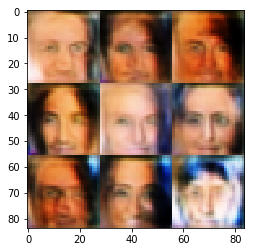

Epoch 1/1-Step 2010... Discriminator Loss: 1.2077... Generator Loss: 0.8097
Epoch 1/1-Step 2020... Discriminator Loss: 1.6748... Generator Loss: 0.6769
Epoch 1/1-Step 2030... Discriminator Loss: 1.2325... Generator Loss: 1.1092
Epoch 1/1-Step 2040... Discriminator Loss: 1.6127... Generator Loss: 0.6180
Epoch 1/1-Step 2050... Discriminator Loss: 1.9700... Generator Loss: 0.4623
Epoch 1/1-Step 2060... Discriminator Loss: 1.7036... Generator Loss: 0.7239
Epoch 1/1-Step 2070... Discriminator Loss: 1.7783... Generator Loss: 0.7530
Epoch 1/1-Step 2080... Discriminator Loss: 1.6162... Generator Loss: 0.6914
Epoch 1/1-Step 2090... Discriminator Loss: 1.3737... Generator Loss: 0.8860
Epoch 1/1-Step 2100... Discriminator Loss: 1.6765... Generator Loss: 0.8732


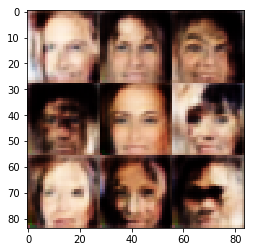

Epoch 1/1-Step 2110... Discriminator Loss: 1.5207... Generator Loss: 0.9026
Epoch 1/1-Step 2120... Discriminator Loss: 1.5098... Generator Loss: 0.8168
Epoch 1/1-Step 2130... Discriminator Loss: 1.8388... Generator Loss: 0.3753
Epoch 1/1-Step 2140... Discriminator Loss: 1.7838... Generator Loss: 0.6771
Epoch 1/1-Step 2150... Discriminator Loss: 1.6525... Generator Loss: 0.9387
Epoch 1/1-Step 2160... Discriminator Loss: 1.4477... Generator Loss: 0.7868
Epoch 1/1-Step 2170... Discriminator Loss: 1.5385... Generator Loss: 0.5039
Epoch 1/1-Step 2180... Discriminator Loss: 1.2671... Generator Loss: 1.0103
Epoch 1/1-Step 2190... Discriminator Loss: 1.3645... Generator Loss: 0.7141
Epoch 1/1-Step 2200... Discriminator Loss: 1.4519... Generator Loss: 0.7778


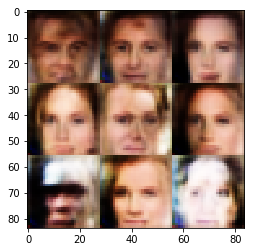

Epoch 1/1-Step 2210... Discriminator Loss: 1.6324... Generator Loss: 0.6715
Epoch 1/1-Step 2220... Discriminator Loss: 1.6588... Generator Loss: 0.6475
Epoch 1/1-Step 2230... Discriminator Loss: 1.6004... Generator Loss: 0.6738
Epoch 1/1-Step 2240... Discriminator Loss: 1.7856... Generator Loss: 0.4941
Epoch 1/1-Step 2250... Discriminator Loss: 2.0594... Generator Loss: 0.8119
Epoch 1/1-Step 2260... Discriminator Loss: 1.5741... Generator Loss: 0.6967
Epoch 1/1-Step 2270... Discriminator Loss: 1.5061... Generator Loss: 0.7997
Epoch 1/1-Step 2280... Discriminator Loss: 1.6878... Generator Loss: 0.5264
Epoch 1/1-Step 2290... Discriminator Loss: 1.5639... Generator Loss: 0.9190
Epoch 1/1-Step 2300... Discriminator Loss: 1.4255... Generator Loss: 1.0749


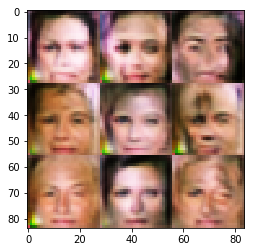

Epoch 1/1-Step 2310... Discriminator Loss: 1.4793... Generator Loss: 0.7750
Epoch 1/1-Step 2320... Discriminator Loss: 1.4188... Generator Loss: 0.7339
Epoch 1/1-Step 2330... Discriminator Loss: 1.5441... Generator Loss: 0.6852
Epoch 1/1-Step 2340... Discriminator Loss: 1.7626... Generator Loss: 0.8259
Epoch 1/1-Step 2350... Discriminator Loss: 1.4334... Generator Loss: 1.2131
Epoch 1/1-Step 2360... Discriminator Loss: 1.4948... Generator Loss: 0.8043
Epoch 1/1-Step 2370... Discriminator Loss: 1.3628... Generator Loss: 0.9632
Epoch 1/1-Step 2380... Discriminator Loss: 1.3724... Generator Loss: 0.7632
Epoch 1/1-Step 2390... Discriminator Loss: 1.4073... Generator Loss: 1.0515
Epoch 1/1-Step 2400... Discriminator Loss: 1.6425... Generator Loss: 1.0943


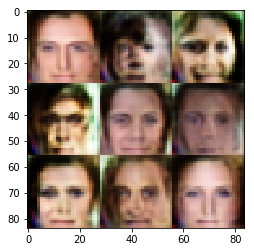

Epoch 1/1-Step 2410... Discriminator Loss: 1.2448... Generator Loss: 0.8053
Epoch 1/1-Step 2420... Discriminator Loss: 1.5791... Generator Loss: 0.8825
Epoch 1/1-Step 2430... Discriminator Loss: 1.4721... Generator Loss: 0.7852
Epoch 1/1-Step 2440... Discriminator Loss: 1.1960... Generator Loss: 0.6903
Epoch 1/1-Step 2450... Discriminator Loss: 1.6489... Generator Loss: 0.7352
Epoch 1/1-Step 2460... Discriminator Loss: 1.6383... Generator Loss: 0.5401
Epoch 1/1-Step 2470... Discriminator Loss: 1.7272... Generator Loss: 0.7256
Epoch 1/1-Step 2480... Discriminator Loss: 1.5266... Generator Loss: 0.6885
Epoch 1/1-Step 2490... Discriminator Loss: 1.3964... Generator Loss: 0.8389
Epoch 1/1-Step 2500... Discriminator Loss: 1.6126... Generator Loss: 1.0305


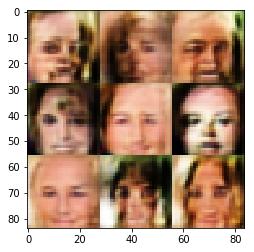

Epoch 1/1-Step 2510... Discriminator Loss: 1.4988... Generator Loss: 0.8729
Epoch 1/1-Step 2520... Discriminator Loss: 1.7505... Generator Loss: 0.9465
Epoch 1/1-Step 2530... Discriminator Loss: 1.6174... Generator Loss: 0.5799
Epoch 1/1-Step 2540... Discriminator Loss: 1.5262... Generator Loss: 0.7723
Epoch 1/1-Step 2550... Discriminator Loss: 1.3262... Generator Loss: 0.9153
Epoch 1/1-Step 2560... Discriminator Loss: 1.5274... Generator Loss: 0.6387
Epoch 1/1-Step 2570... Discriminator Loss: 1.6057... Generator Loss: 0.7459
Epoch 1/1-Step 2580... Discriminator Loss: 1.3637... Generator Loss: 0.9186
Epoch 1/1-Step 2590... Discriminator Loss: 1.9831... Generator Loss: 0.5967
Epoch 1/1-Step 2600... Discriminator Loss: 1.4500... Generator Loss: 0.7985


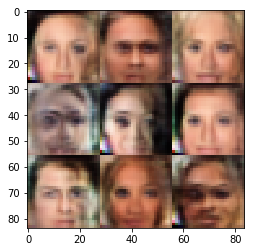

Epoch 1/1-Step 2610... Discriminator Loss: 1.6789... Generator Loss: 0.6164
Epoch 1/1-Step 2620... Discriminator Loss: 1.6104... Generator Loss: 0.7157
Epoch 1/1-Step 2630... Discriminator Loss: 1.6175... Generator Loss: 0.6879
Epoch 1/1-Step 2640... Discriminator Loss: 1.4824... Generator Loss: 0.7394
Epoch 1/1-Step 2650... Discriminator Loss: 1.5183... Generator Loss: 0.7989
Epoch 1/1-Step 2660... Discriminator Loss: 1.4074... Generator Loss: 0.8263
Epoch 1/1-Step 2670... Discriminator Loss: 1.7016... Generator Loss: 1.0771
Epoch 1/1-Step 2680... Discriminator Loss: 1.3518... Generator Loss: 0.9976
Epoch 1/1-Step 2690... Discriminator Loss: 1.7289... Generator Loss: 0.8812
Epoch 1/1-Step 2700... Discriminator Loss: 1.4264... Generator Loss: 0.7199


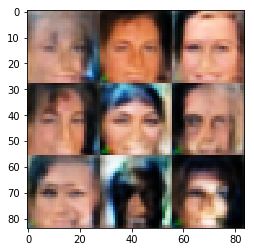

Epoch 1/1-Step 2710... Discriminator Loss: 1.9444... Generator Loss: 0.5275
Epoch 1/1-Step 2720... Discriminator Loss: 1.5196... Generator Loss: 0.5546
Epoch 1/1-Step 2730... Discriminator Loss: 1.5974... Generator Loss: 0.6296
Epoch 1/1-Step 2740... Discriminator Loss: 1.3963... Generator Loss: 0.8431
Epoch 1/1-Step 2750... Discriminator Loss: 1.4813... Generator Loss: 0.7904
Epoch 1/1-Step 2760... Discriminator Loss: 1.6590... Generator Loss: 0.5457
Epoch 1/1-Step 2770... Discriminator Loss: 1.4524... Generator Loss: 0.8106
Epoch 1/1-Step 2780... Discriminator Loss: 1.8156... Generator Loss: 0.7884
Epoch 1/1-Step 2790... Discriminator Loss: 1.4598... Generator Loss: 0.8142
Epoch 1/1-Step 2800... Discriminator Loss: 1.4186... Generator Loss: 0.6926


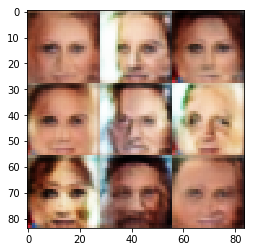

Epoch 1/1-Step 2810... Discriminator Loss: 1.7492... Generator Loss: 0.5969
Epoch 1/1-Step 2820... Discriminator Loss: 1.3586... Generator Loss: 0.6138
Epoch 1/1-Step 2830... Discriminator Loss: 1.4274... Generator Loss: 0.8394
Epoch 1/1-Step 2840... Discriminator Loss: 1.4150... Generator Loss: 1.0987
Epoch 1/1-Step 2850... Discriminator Loss: 1.3768... Generator Loss: 0.9213
Epoch 1/1-Step 2860... Discriminator Loss: 1.5966... Generator Loss: 0.9126
Epoch 1/1-Step 2870... Discriminator Loss: 1.4296... Generator Loss: 0.7678
Epoch 1/1-Step 2880... Discriminator Loss: 1.3032... Generator Loss: 0.7903
Epoch 1/1-Step 2890... Discriminator Loss: 1.7742... Generator Loss: 0.7110
Epoch 1/1-Step 2900... Discriminator Loss: 1.6297... Generator Loss: 0.7091


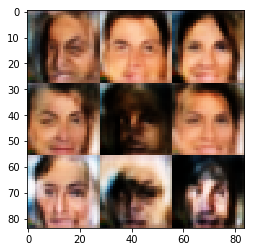

Epoch 1/1-Step 2910... Discriminator Loss: 1.7591... Generator Loss: 0.9087
Epoch 1/1-Step 2920... Discriminator Loss: 1.5827... Generator Loss: 0.6977
Epoch 1/1-Step 2930... Discriminator Loss: 1.4514... Generator Loss: 0.8571
Epoch 1/1-Step 2940... Discriminator Loss: 1.4127... Generator Loss: 0.7843
Epoch 1/1-Step 2950... Discriminator Loss: 1.6538... Generator Loss: 0.5601
Epoch 1/1-Step 2960... Discriminator Loss: 1.4198... Generator Loss: 0.7983
Epoch 1/1-Step 2970... Discriminator Loss: 1.2191... Generator Loss: 0.6956
Epoch 1/1-Step 2980... Discriminator Loss: 1.3358... Generator Loss: 0.7731
Epoch 1/1-Step 2990... Discriminator Loss: 1.5513... Generator Loss: 0.8735
Epoch 1/1-Step 3000... Discriminator Loss: 1.3683... Generator Loss: 0.9643


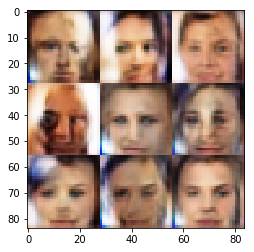

Epoch 1/1-Step 3010... Discriminator Loss: 1.7157... Generator Loss: 0.8457
Epoch 1/1-Step 3020... Discriminator Loss: 1.5131... Generator Loss: 0.9042
Epoch 1/1-Step 3030... Discriminator Loss: 1.6572... Generator Loss: 0.7466
Epoch 1/1-Step 3040... Discriminator Loss: 1.4736... Generator Loss: 0.9716
Epoch 1/1-Step 3050... Discriminator Loss: 1.4429... Generator Loss: 0.7000
Epoch 1/1-Step 3060... Discriminator Loss: 1.5794... Generator Loss: 0.6830
Epoch 1/1-Step 3070... Discriminator Loss: 1.2576... Generator Loss: 0.8349
Epoch 1/1-Step 3080... Discriminator Loss: 1.5124... Generator Loss: 0.9520
Epoch 1/1-Step 3090... Discriminator Loss: 1.2616... Generator Loss: 0.7677
Epoch 1/1-Step 3100... Discriminator Loss: 1.4092... Generator Loss: 0.8760


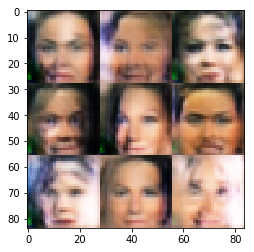

Epoch 1/1-Step 3110... Discriminator Loss: 1.5141... Generator Loss: 0.7706
Epoch 1/1-Step 3120... Discriminator Loss: 1.5931... Generator Loss: 0.8096
Epoch 1/1-Step 3130... Discriminator Loss: 1.3764... Generator Loss: 0.7593
Epoch 1/1-Step 3140... Discriminator Loss: 1.5350... Generator Loss: 0.8338
Epoch 1/1-Step 3150... Discriminator Loss: 1.4308... Generator Loss: 0.7347
Epoch 1/1-Step 3160... Discriminator Loss: 1.9351... Generator Loss: 0.8502
Epoch 1/1-Step 3170... Discriminator Loss: 1.4762... Generator Loss: 0.6605
Epoch 1/1-Step 3180... Discriminator Loss: 1.2701... Generator Loss: 0.6483
Epoch 1/1-Step 3190... Discriminator Loss: 1.6003... Generator Loss: 0.4033
Epoch 1/1-Step 3200... Discriminator Loss: 1.4458... Generator Loss: 0.8985


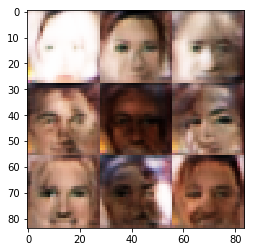

Epoch 1/1-Step 3210... Discriminator Loss: 1.5244... Generator Loss: 0.7205
Epoch 1/1-Step 3220... Discriminator Loss: 1.4948... Generator Loss: 0.7835
Epoch 1/1-Step 3230... Discriminator Loss: 1.7276... Generator Loss: 0.6534
Epoch 1/1-Step 3240... Discriminator Loss: 1.7726... Generator Loss: 0.7834
Epoch 1/1-Step 3250... Discriminator Loss: 1.4260... Generator Loss: 0.8314
Epoch 1/1-Step 3260... Discriminator Loss: 1.3410... Generator Loss: 0.8914
Epoch 1/1-Step 3270... Discriminator Loss: 1.3016... Generator Loss: 0.5628
Epoch 1/1-Step 3280... Discriminator Loss: 1.1748... Generator Loss: 0.7641
Epoch 1/1-Step 3290... Discriminator Loss: 1.5931... Generator Loss: 0.6746
Epoch 1/1-Step 3300... Discriminator Loss: 1.4556... Generator Loss: 0.6975


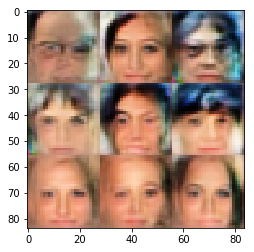

Epoch 1/1-Step 3310... Discriminator Loss: 1.6819... Generator Loss: 0.7399
Epoch 1/1-Step 3320... Discriminator Loss: 1.5214... Generator Loss: 0.6296
Epoch 1/1-Step 3330... Discriminator Loss: 1.6875... Generator Loss: 0.5568
Epoch 1/1-Step 3340... Discriminator Loss: 1.4709... Generator Loss: 0.7251
Epoch 1/1-Step 3350... Discriminator Loss: 1.3091... Generator Loss: 0.9523
Epoch 1/1-Step 3360... Discriminator Loss: 1.8484... Generator Loss: 0.5126
Epoch 1/1-Step 3370... Discriminator Loss: 1.4600... Generator Loss: 0.7444
Epoch 1/1-Step 3380... Discriminator Loss: 1.4035... Generator Loss: 0.7333
Epoch 1/1-Step 3390... Discriminator Loss: 1.3388... Generator Loss: 0.6791
Epoch 1/1-Step 3400... Discriminator Loss: 1.6287... Generator Loss: 0.7695


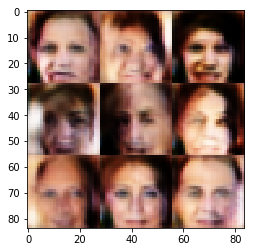

Epoch 1/1-Step 3410... Discriminator Loss: 1.6047... Generator Loss: 0.9408
Epoch 1/1-Step 3420... Discriminator Loss: 1.6477... Generator Loss: 0.6902
Epoch 1/1-Step 3430... Discriminator Loss: 1.6805... Generator Loss: 0.7269
Epoch 1/1-Step 3440... Discriminator Loss: 1.3426... Generator Loss: 0.7700
Epoch 1/1-Step 3450... Discriminator Loss: 1.3337... Generator Loss: 0.9089
Epoch 1/1-Step 3460... Discriminator Loss: 1.7269... Generator Loss: 0.4634
Epoch 1/1-Step 3470... Discriminator Loss: 1.5530... Generator Loss: 0.6510
Epoch 1/1-Step 3480... Discriminator Loss: 1.4688... Generator Loss: 0.5716
Epoch 1/1-Step 3490... Discriminator Loss: 1.8038... Generator Loss: 0.7882
Epoch 1/1-Step 3500... Discriminator Loss: 1.4409... Generator Loss: 0.9086


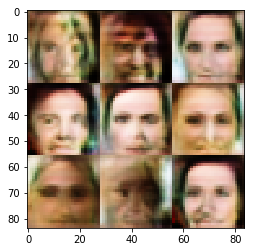

Epoch 1/1-Step 3510... Discriminator Loss: 1.4427... Generator Loss: 1.1050
Epoch 1/1-Step 3520... Discriminator Loss: 1.4272... Generator Loss: 0.7727
Epoch 1/1-Step 3530... Discriminator Loss: 1.4006... Generator Loss: 0.8221
Epoch 1/1-Step 3540... Discriminator Loss: 1.6652... Generator Loss: 0.5984
Epoch 1/1-Step 3550... Discriminator Loss: 1.6726... Generator Loss: 1.0027
Epoch 1/1-Step 3560... Discriminator Loss: 1.5106... Generator Loss: 0.5861
Epoch 1/1-Step 3570... Discriminator Loss: 1.4999... Generator Loss: 0.6522
Epoch 1/1-Step 3580... Discriminator Loss: 1.5615... Generator Loss: 0.6770
Epoch 1/1-Step 3590... Discriminator Loss: 1.8390... Generator Loss: 0.6999
Epoch 1/1-Step 3600... Discriminator Loss: 1.7242... Generator Loss: 0.9474


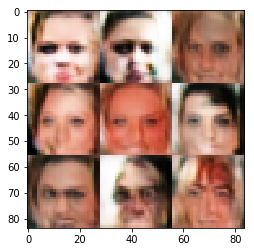

Epoch 1/1-Step 3610... Discriminator Loss: 1.7396... Generator Loss: 0.7128
Epoch 1/1-Step 3620... Discriminator Loss: 1.3929... Generator Loss: 0.9645
Epoch 1/1-Step 3630... Discriminator Loss: 1.4905... Generator Loss: 0.6534
Epoch 1/1-Step 3640... Discriminator Loss: 1.5167... Generator Loss: 0.7207
Epoch 1/1-Step 3650... Discriminator Loss: 1.7349... Generator Loss: 0.6661
Epoch 1/1-Step 3660... Discriminator Loss: 1.7091... Generator Loss: 0.8844
Epoch 1/1-Step 3670... Discriminator Loss: 1.5579... Generator Loss: 0.8142
Epoch 1/1-Step 3680... Discriminator Loss: 1.4968... Generator Loss: 0.6100
Epoch 1/1-Step 3690... Discriminator Loss: 1.6704... Generator Loss: 0.6108
Epoch 1/1-Step 3700... Discriminator Loss: 1.4823... Generator Loss: 0.8318


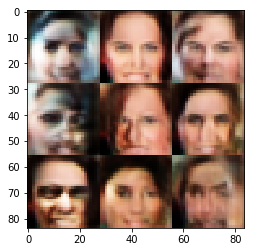

Epoch 1/1-Step 3710... Discriminator Loss: 1.4687... Generator Loss: 0.8287
Epoch 1/1-Step 3720... Discriminator Loss: 1.3611... Generator Loss: 0.7837
Epoch 1/1-Step 3730... Discriminator Loss: 1.5581... Generator Loss: 0.7379
Epoch 1/1-Step 3740... Discriminator Loss: 1.2695... Generator Loss: 0.7258
Epoch 1/1-Step 3750... Discriminator Loss: 1.6435... Generator Loss: 0.6423
Epoch 1/1-Step 3760... Discriminator Loss: 1.4146... Generator Loss: 0.7574
Epoch 1/1-Step 3770... Discriminator Loss: 1.3162... Generator Loss: 0.9410
Epoch 1/1-Step 3780... Discriminator Loss: 1.5345... Generator Loss: 0.7912
Epoch 1/1-Step 3790... Discriminator Loss: 1.5952... Generator Loss: 0.8790
Epoch 1/1-Step 3800... Discriminator Loss: 1.3599... Generator Loss: 0.9576


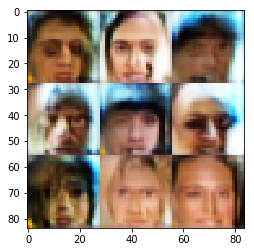

Epoch 1/1-Step 3810... Discriminator Loss: 1.2795... Generator Loss: 0.7788
Epoch 1/1-Step 3820... Discriminator Loss: 1.6969... Generator Loss: 0.8338
Epoch 1/1-Step 3830... Discriminator Loss: 1.4994... Generator Loss: 0.8638
Epoch 1/1-Step 3840... Discriminator Loss: 1.6924... Generator Loss: 0.7830
Epoch 1/1-Step 3850... Discriminator Loss: 1.5655... Generator Loss: 0.7393
Epoch 1/1-Step 3860... Discriminator Loss: 1.3982... Generator Loss: 0.8017
Epoch 1/1-Step 3870... Discriminator Loss: 1.6797... Generator Loss: 0.6754
Epoch 1/1-Step 3880... Discriminator Loss: 1.6183... Generator Loss: 0.7672
Epoch 1/1-Step 3890... Discriminator Loss: 1.4654... Generator Loss: 0.7202
Epoch 1/1-Step 3900... Discriminator Loss: 1.5022... Generator Loss: 0.7759


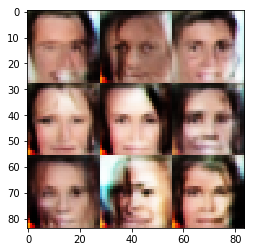

Epoch 1/1-Step 3910... Discriminator Loss: 1.2944... Generator Loss: 0.8291
Epoch 1/1-Step 3920... Discriminator Loss: 1.3820... Generator Loss: 0.8784
Epoch 1/1-Step 3930... Discriminator Loss: 1.5773... Generator Loss: 0.7978
Epoch 1/1-Step 3940... Discriminator Loss: 1.6380... Generator Loss: 0.6990
Epoch 1/1-Step 3950... Discriminator Loss: 1.2866... Generator Loss: 0.8188
Epoch 1/1-Step 3960... Discriminator Loss: 1.5176... Generator Loss: 0.8348
Epoch 1/1-Step 3970... Discriminator Loss: 1.3513... Generator Loss: 0.7374
Epoch 1/1-Step 3980... Discriminator Loss: 1.3328... Generator Loss: 0.7456
Epoch 1/1-Step 3990... Discriminator Loss: 1.4493... Generator Loss: 0.7595
Epoch 1/1-Step 4000... Discriminator Loss: 1.7063... Generator Loss: 0.5705


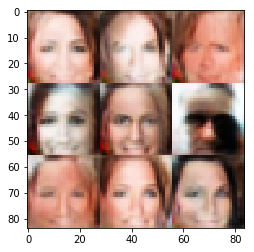

Epoch 1/1-Step 4010... Discriminator Loss: 1.4494... Generator Loss: 0.5850
Epoch 1/1-Step 4020... Discriminator Loss: 1.1800... Generator Loss: 0.5784
Epoch 1/1-Step 4030... Discriminator Loss: 1.5047... Generator Loss: 0.7578
Epoch 1/1-Step 4040... Discriminator Loss: 1.4166... Generator Loss: 0.9235
Epoch 1/1-Step 4050... Discriminator Loss: 1.3354... Generator Loss: 0.5722
Epoch 1/1-Step 4060... Discriminator Loss: 1.3027... Generator Loss: 0.8640
Epoch 1/1-Step 4070... Discriminator Loss: 1.4077... Generator Loss: 0.7505
Epoch 1/1-Step 4080... Discriminator Loss: 1.6606... Generator Loss: 0.5598
Epoch 1/1-Step 4090... Discriminator Loss: 1.6864... Generator Loss: 0.8527
Epoch 1/1-Step 4100... Discriminator Loss: 1.4432... Generator Loss: 0.6975


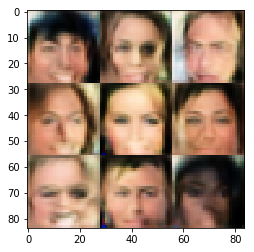

Epoch 1/1-Step 4110... Discriminator Loss: 1.4610... Generator Loss: 0.5814
Epoch 1/1-Step 4120... Discriminator Loss: 1.3286... Generator Loss: 0.9355
Epoch 1/1-Step 4130... Discriminator Loss: 1.3846... Generator Loss: 0.7204
Epoch 1/1-Step 4140... Discriminator Loss: 1.6672... Generator Loss: 0.9865
Epoch 1/1-Step 4150... Discriminator Loss: 1.1974... Generator Loss: 0.9359
Epoch 1/1-Step 4160... Discriminator Loss: 1.4319... Generator Loss: 0.5810
Epoch 1/1-Step 4170... Discriminator Loss: 1.4379... Generator Loss: 0.8376
Epoch 1/1-Step 4180... Discriminator Loss: 1.6290... Generator Loss: 0.6633
Epoch 1/1-Step 4190... Discriminator Loss: 1.4695... Generator Loss: 0.9870
Epoch 1/1-Step 4200... Discriminator Loss: 1.3221... Generator Loss: 0.7868


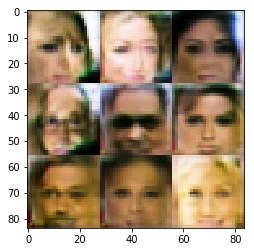

Epoch 1/1-Step 4210... Discriminator Loss: 1.5551... Generator Loss: 0.8544
Epoch 1/1-Step 4220... Discriminator Loss: 1.7906... Generator Loss: 0.5292
Epoch 1/1-Step 4230... Discriminator Loss: 1.6138... Generator Loss: 0.8525
Epoch 1/1-Step 4240... Discriminator Loss: 1.3783... Generator Loss: 0.9272
Epoch 1/1-Step 4250... Discriminator Loss: 1.3710... Generator Loss: 0.7193
Epoch 1/1-Step 4260... Discriminator Loss: 1.4316... Generator Loss: 0.7570
Epoch 1/1-Step 4270... Discriminator Loss: 1.4212... Generator Loss: 0.9779
Epoch 1/1-Step 4280... Discriminator Loss: 1.5912... Generator Loss: 0.7956
Epoch 1/1-Step 4290... Discriminator Loss: 1.5320... Generator Loss: 0.7611
Epoch 1/1-Step 4300... Discriminator Loss: 1.5352... Generator Loss: 0.7894


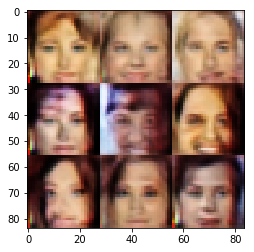

Epoch 1/1-Step 4310... Discriminator Loss: 1.2916... Generator Loss: 0.7880
Epoch 1/1-Step 4320... Discriminator Loss: 1.4958... Generator Loss: 0.8778
Epoch 1/1-Step 4330... Discriminator Loss: 1.4708... Generator Loss: 1.0361
Epoch 1/1-Step 4340... Discriminator Loss: 1.5519... Generator Loss: 0.7345
Epoch 1/1-Step 4350... Discriminator Loss: 1.4025... Generator Loss: 0.8023
Epoch 1/1-Step 4360... Discriminator Loss: 1.5092... Generator Loss: 0.8394
Epoch 1/1-Step 4370... Discriminator Loss: 1.4229... Generator Loss: 0.8124
Epoch 1/1-Step 4380... Discriminator Loss: 1.5185... Generator Loss: 0.5909
Epoch 1/1-Step 4390... Discriminator Loss: 1.3466... Generator Loss: 0.7556
Epoch 1/1-Step 4400... Discriminator Loss: 1.4597... Generator Loss: 1.0690


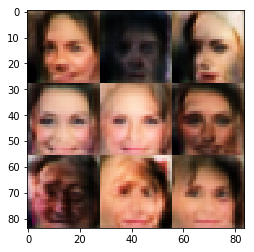

Epoch 1/1-Step 4410... Discriminator Loss: 1.7616... Generator Loss: 0.9580
Epoch 1/1-Step 4420... Discriminator Loss: 1.4738... Generator Loss: 0.6393
Epoch 1/1-Step 4430... Discriminator Loss: 1.2484... Generator Loss: 0.5620
Epoch 1/1-Step 4440... Discriminator Loss: 1.2880... Generator Loss: 0.7840
Epoch 1/1-Step 4450... Discriminator Loss: 1.4303... Generator Loss: 0.9152
Epoch 1/1-Step 4460... Discriminator Loss: 1.3044... Generator Loss: 1.0829
Epoch 1/1-Step 4470... Discriminator Loss: 1.6106... Generator Loss: 0.5933
Epoch 1/1-Step 4480... Discriminator Loss: 1.4947... Generator Loss: 0.8435
Epoch 1/1-Step 4490... Discriminator Loss: 1.3264... Generator Loss: 0.8331
Epoch 1/1-Step 4500... Discriminator Loss: 1.4577... Generator Loss: 0.7298


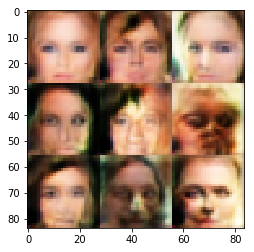

Epoch 1/1-Step 4510... Discriminator Loss: 1.4926... Generator Loss: 0.6693
Epoch 1/1-Step 4520... Discriminator Loss: 1.5976... Generator Loss: 0.6750
Epoch 1/1-Step 4530... Discriminator Loss: 1.6050... Generator Loss: 0.5765
Epoch 1/1-Step 4540... Discriminator Loss: 1.5485... Generator Loss: 1.0729
Epoch 1/1-Step 4550... Discriminator Loss: 1.5785... Generator Loss: 0.8145
Epoch 1/1-Step 4560... Discriminator Loss: 1.3578... Generator Loss: 0.8214
Epoch 1/1-Step 4570... Discriminator Loss: 1.4673... Generator Loss: 0.7480
Epoch 1/1-Step 4580... Discriminator Loss: 1.5683... Generator Loss: 0.9356
Epoch 1/1-Step 4590... Discriminator Loss: 1.5348... Generator Loss: 0.9295
Epoch 1/1-Step 4600... Discriminator Loss: 1.4560... Generator Loss: 0.8204


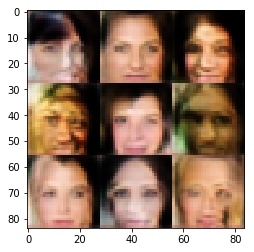

Epoch 1/1-Step 4610... Discriminator Loss: 1.3437... Generator Loss: 0.8714
Epoch 1/1-Step 4620... Discriminator Loss: 1.2796... Generator Loss: 0.6942
Epoch 1/1-Step 4630... Discriminator Loss: 1.6742... Generator Loss: 0.8542
Epoch 1/1-Step 4640... Discriminator Loss: 1.5383... Generator Loss: 0.8454
Epoch 1/1-Step 4650... Discriminator Loss: 1.8187... Generator Loss: 0.6208
Epoch 1/1-Step 4660... Discriminator Loss: 2.4415... Generator Loss: 0.7599
Epoch 1/1-Step 4670... Discriminator Loss: 1.9543... Generator Loss: 0.7565
Epoch 1/1-Step 4680... Discriminator Loss: 1.8191... Generator Loss: 0.5288
Epoch 1/1-Step 4690... Discriminator Loss: 1.4574... Generator Loss: 0.6674
Epoch 1/1-Step 4700... Discriminator Loss: 1.2855... Generator Loss: 0.9943


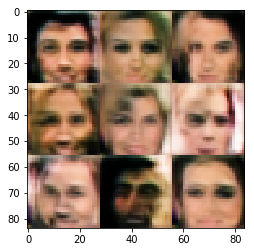

Epoch 1/1-Step 4710... Discriminator Loss: 1.3984... Generator Loss: 0.7302
Epoch 1/1-Step 4720... Discriminator Loss: 1.6908... Generator Loss: 0.6329
Epoch 1/1-Step 4730... Discriminator Loss: 1.3791... Generator Loss: 1.0040
Epoch 1/1-Step 4740... Discriminator Loss: 1.7028... Generator Loss: 0.7184
Epoch 1/1-Step 4750... Discriminator Loss: 1.4108... Generator Loss: 0.7537
Epoch 1/1-Step 4760... Discriminator Loss: 1.3353... Generator Loss: 0.7356
Epoch 1/1-Step 4770... Discriminator Loss: 1.4164... Generator Loss: 1.1678
Epoch 1/1-Step 4780... Discriminator Loss: 1.4975... Generator Loss: 0.8875
Epoch 1/1-Step 4790... Discriminator Loss: 1.4364... Generator Loss: 0.7185
Epoch 1/1-Step 4800... Discriminator Loss: 1.4725... Generator Loss: 0.8623


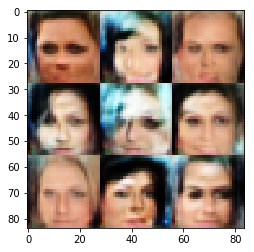

Epoch 1/1-Step 4810... Discriminator Loss: 1.5693... Generator Loss: 0.6796
Epoch 1/1-Step 4820... Discriminator Loss: 1.4496... Generator Loss: 0.7525
Epoch 1/1-Step 4830... Discriminator Loss: 1.4801... Generator Loss: 0.5545
Epoch 1/1-Step 4840... Discriminator Loss: 1.4186... Generator Loss: 0.7224
Epoch 1/1-Step 4850... Discriminator Loss: 1.4451... Generator Loss: 0.7199
Epoch 1/1-Step 4860... Discriminator Loss: 1.3019... Generator Loss: 0.8858
Epoch 1/1-Step 4870... Discriminator Loss: 1.4198... Generator Loss: 0.9096
Epoch 1/1-Step 4880... Discriminator Loss: 1.2658... Generator Loss: 0.8868
Epoch 1/1-Step 4890... Discriminator Loss: 1.6038... Generator Loss: 0.6470
Epoch 1/1-Step 4900... Discriminator Loss: 1.4718... Generator Loss: 0.6067


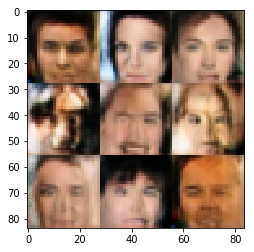

Epoch 1/1-Step 4910... Discriminator Loss: 1.2905... Generator Loss: 0.9631
Epoch 1/1-Step 4920... Discriminator Loss: 1.5757... Generator Loss: 0.8546
Epoch 1/1-Step 4930... Discriminator Loss: 1.5008... Generator Loss: 0.8035
Epoch 1/1-Step 4940... Discriminator Loss: 1.5255... Generator Loss: 0.7468
Epoch 1/1-Step 4950... Discriminator Loss: 1.6217... Generator Loss: 0.5873
Epoch 1/1-Step 4960... Discriminator Loss: 1.3852... Generator Loss: 0.6521
Epoch 1/1-Step 4970... Discriminator Loss: 1.6474... Generator Loss: 0.6915
Epoch 1/1-Step 4980... Discriminator Loss: 1.3931... Generator Loss: 0.7564
Epoch 1/1-Step 4990... Discriminator Loss: 1.1192... Generator Loss: 0.7424
Epoch 1/1-Step 5000... Discriminator Loss: 1.4956... Generator Loss: 1.0168


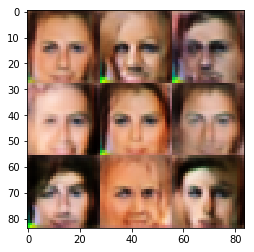

Epoch 1/1-Step 5010... Discriminator Loss: 1.5876... Generator Loss: 0.8955
Epoch 1/1-Step 5020... Discriminator Loss: 1.5652... Generator Loss: 0.6562
Epoch 1/1-Step 5030... Discriminator Loss: 1.3265... Generator Loss: 0.8291
Epoch 1/1-Step 5040... Discriminator Loss: 1.6025... Generator Loss: 0.6956
Epoch 1/1-Step 5050... Discriminator Loss: 1.5548... Generator Loss: 0.7266
Epoch 1/1-Step 5060... Discriminator Loss: 1.2764... Generator Loss: 0.7391
Epoch 1/1-Step 5070... Discriminator Loss: 1.3527... Generator Loss: 0.8363
Epoch 1/1-Step 5080... Discriminator Loss: 1.5493... Generator Loss: 0.6342
Epoch 1/1-Step 5090... Discriminator Loss: 1.4803... Generator Loss: 0.7554
Epoch 1/1-Step 5100... Discriminator Loss: 1.6153... Generator Loss: 0.7942


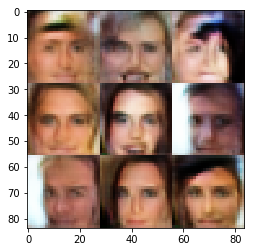

Epoch 1/1-Step 5110... Discriminator Loss: 1.6088... Generator Loss: 0.8132
Epoch 1/1-Step 5120... Discriminator Loss: 1.5672... Generator Loss: 0.9925
Epoch 1/1-Step 5130... Discriminator Loss: 1.3305... Generator Loss: 0.8971
Epoch 1/1-Step 5140... Discriminator Loss: 1.4021... Generator Loss: 0.7788
Epoch 1/1-Step 5150... Discriminator Loss: 1.3778... Generator Loss: 0.8807
Epoch 1/1-Step 5160... Discriminator Loss: 1.3363... Generator Loss: 0.9228
Epoch 1/1-Step 5170... Discriminator Loss: 1.6637... Generator Loss: 0.7810
Epoch 1/1-Step 5180... Discriminator Loss: 1.3825... Generator Loss: 0.7041
Epoch 1/1-Step 5190... Discriminator Loss: 1.2808... Generator Loss: 0.9957
Epoch 1/1-Step 5200... Discriminator Loss: 1.5101... Generator Loss: 0.7931


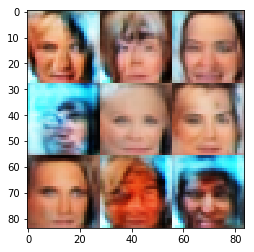

Epoch 1/1-Step 5210... Discriminator Loss: 1.5796... Generator Loss: 0.6868
Epoch 1/1-Step 5220... Discriminator Loss: 1.4450... Generator Loss: 0.5678
Epoch 1/1-Step 5230... Discriminator Loss: 1.7324... Generator Loss: 0.7932
Epoch 1/1-Step 5240... Discriminator Loss: 1.6043... Generator Loss: 0.9452
Epoch 1/1-Step 5250... Discriminator Loss: 1.5204... Generator Loss: 0.7910
Epoch 1/1-Step 5260... Discriminator Loss: 1.4736... Generator Loss: 0.7656
Epoch 1/1-Step 5270... Discriminator Loss: 1.3685... Generator Loss: 0.6641
Epoch 1/1-Step 5280... Discriminator Loss: 1.3507... Generator Loss: 0.6822
Epoch 1/1-Step 5290... Discriminator Loss: 1.4663... Generator Loss: 0.8238
Epoch 1/1-Step 5300... Discriminator Loss: 1.2868... Generator Loss: 0.8053


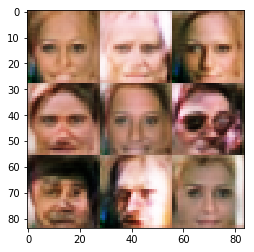

Epoch 1/1-Step 5310... Discriminator Loss: 1.4377... Generator Loss: 0.6657
Epoch 1/1-Step 5320... Discriminator Loss: 1.2514... Generator Loss: 0.8370
Epoch 1/1-Step 5330... Discriminator Loss: 1.3734... Generator Loss: 0.7236
Epoch 1/1-Step 5340... Discriminator Loss: 1.5389... Generator Loss: 0.6186
Epoch 1/1-Step 5350... Discriminator Loss: 1.4716... Generator Loss: 0.7952
Epoch 1/1-Step 5360... Discriminator Loss: 1.4496... Generator Loss: 0.8589
Epoch 1/1-Step 5370... Discriminator Loss: 1.2425... Generator Loss: 0.9591
Epoch 1/1-Step 5380... Discriminator Loss: 1.4800... Generator Loss: 1.0139
Epoch 1/1-Step 5390... Discriminator Loss: 1.3756... Generator Loss: 0.7858
Epoch 1/1-Step 5400... Discriminator Loss: 1.5945... Generator Loss: 1.2073


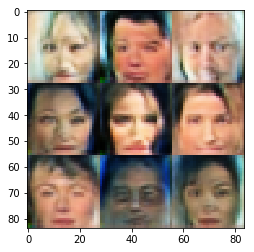

Epoch 1/1-Step 5410... Discriminator Loss: 1.5085... Generator Loss: 1.1527
Epoch 1/1-Step 5420... Discriminator Loss: 1.3853... Generator Loss: 0.6506
Epoch 1/1-Step 5430... Discriminator Loss: 1.2997... Generator Loss: 0.6286
Epoch 1/1-Step 5440... Discriminator Loss: 1.4468... Generator Loss: 0.8861
Epoch 1/1-Step 5450... Discriminator Loss: 1.3339... Generator Loss: 0.6909
Epoch 1/1-Step 5460... Discriminator Loss: 1.3680... Generator Loss: 0.8333
Epoch 1/1-Step 5470... Discriminator Loss: 1.6801... Generator Loss: 0.7344
Epoch 1/1-Step 5480... Discriminator Loss: 1.4616... Generator Loss: 0.6459
Epoch 1/1-Step 5490... Discriminator Loss: 1.4658... Generator Loss: 0.6166
Epoch 1/1-Step 5500... Discriminator Loss: 1.3914... Generator Loss: 0.6666


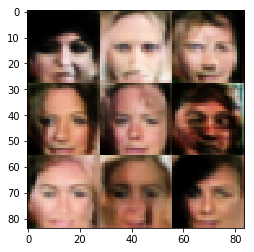

Epoch 1/1-Step 5510... Discriminator Loss: 1.5045... Generator Loss: 0.7602
Epoch 1/1-Step 5520... Discriminator Loss: 1.5775... Generator Loss: 0.7188
Epoch 1/1-Step 5530... Discriminator Loss: 1.4987... Generator Loss: 0.6459
Epoch 1/1-Step 5540... Discriminator Loss: 1.5860... Generator Loss: 0.6320
Epoch 1/1-Step 5550... Discriminator Loss: 1.3267... Generator Loss: 0.7290
Epoch 1/1-Step 5560... Discriminator Loss: 1.4017... Generator Loss: 0.8656
Epoch 1/1-Step 5570... Discriminator Loss: 1.4532... Generator Loss: 0.9305
Epoch 1/1-Step 5580... Discriminator Loss: 1.3911... Generator Loss: 0.8586
Epoch 1/1-Step 5590... Discriminator Loss: 1.4204... Generator Loss: 0.8865
Epoch 1/1-Step 5600... Discriminator Loss: 1.5059... Generator Loss: 0.8704


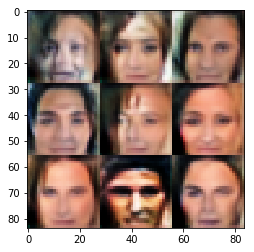

Epoch 1/1-Step 5610... Discriminator Loss: 1.3622... Generator Loss: 0.8729
Epoch 1/1-Step 5620... Discriminator Loss: 1.6957... Generator Loss: 0.6604
Epoch 1/1-Step 5630... Discriminator Loss: 1.6844... Generator Loss: 0.7867
Epoch 1/1-Step 5640... Discriminator Loss: 1.5988... Generator Loss: 0.8483
Epoch 1/1-Step 5650... Discriminator Loss: 1.6001... Generator Loss: 0.8210
Epoch 1/1-Step 5660... Discriminator Loss: 1.3692... Generator Loss: 0.6221
Epoch 1/1-Step 5670... Discriminator Loss: 1.2333... Generator Loss: 0.7121
Epoch 1/1-Step 5680... Discriminator Loss: 1.4341... Generator Loss: 0.8165
Epoch 1/1-Step 5690... Discriminator Loss: 1.4222... Generator Loss: 1.0732
Epoch 1/1-Step 5700... Discriminator Loss: 1.5038... Generator Loss: 0.6557


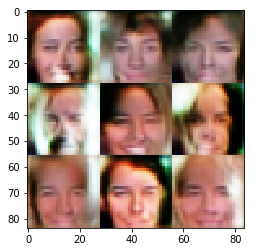

Epoch 1/1-Step 5710... Discriminator Loss: 1.5134... Generator Loss: 0.5332
Epoch 1/1-Step 5720... Discriminator Loss: 1.6874... Generator Loss: 0.5323
Epoch 1/1-Step 5730... Discriminator Loss: 1.6629... Generator Loss: 0.6543
Epoch 1/1-Step 5740... Discriminator Loss: 1.1474... Generator Loss: 0.9340
Epoch 1/1-Step 5750... Discriminator Loss: 1.3726... Generator Loss: 0.8105
Epoch 1/1-Step 5760... Discriminator Loss: 1.6248... Generator Loss: 0.5390
Epoch 1/1-Step 5770... Discriminator Loss: 1.3388... Generator Loss: 1.0406
Epoch 1/1-Step 5780... Discriminator Loss: 1.4832... Generator Loss: 0.8520
Epoch 1/1-Step 5790... Discriminator Loss: 1.4594... Generator Loss: 0.6703
Epoch 1/1-Step 5800... Discriminator Loss: 1.5462... Generator Loss: 0.5732


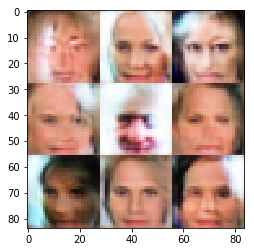

Epoch 1/1-Step 5810... Discriminator Loss: 1.4532... Generator Loss: 0.7959
Epoch 1/1-Step 5820... Discriminator Loss: 1.3183... Generator Loss: 0.7068
Epoch 1/1-Step 5830... Discriminator Loss: 1.5936... Generator Loss: 0.6918
Epoch 1/1-Step 5840... Discriminator Loss: 1.5260... Generator Loss: 0.8292
Epoch 1/1-Step 5850... Discriminator Loss: 1.3679... Generator Loss: 0.8010
Epoch 1/1-Step 5860... Discriminator Loss: 1.3761... Generator Loss: 0.8645
Epoch 1/1-Step 5870... Discriminator Loss: 1.2885... Generator Loss: 0.8227
Epoch 1/1-Step 5880... Discriminator Loss: 1.5387... Generator Loss: 0.7631
Epoch 1/1-Step 5890... Discriminator Loss: 1.5974... Generator Loss: 0.8087
Epoch 1/1-Step 5900... Discriminator Loss: 1.6992... Generator Loss: 0.7804


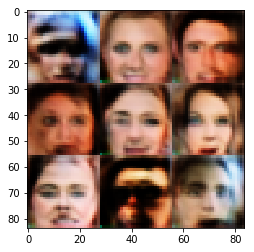

Epoch 1/1-Step 5910... Discriminator Loss: 1.7040... Generator Loss: 0.6521
Epoch 1/1-Step 5920... Discriminator Loss: 1.5462... Generator Loss: 0.7267
Epoch 1/1-Step 5930... Discriminator Loss: 1.5583... Generator Loss: 0.9569
Epoch 1/1-Step 5940... Discriminator Loss: 1.4782... Generator Loss: 0.6528
Epoch 1/1-Step 5950... Discriminator Loss: 1.3296... Generator Loss: 0.8029
Epoch 1/1-Step 5960... Discriminator Loss: 1.5989... Generator Loss: 1.2280
Epoch 1/1-Step 5970... Discriminator Loss: 1.2882... Generator Loss: 0.9308
Epoch 1/1-Step 5980... Discriminator Loss: 1.3564... Generator Loss: 0.7141
Epoch 1/1-Step 5990... Discriminator Loss: 1.6733... Generator Loss: 0.9728
Epoch 1/1-Step 6000... Discriminator Loss: 1.4325... Generator Loss: 0.7974


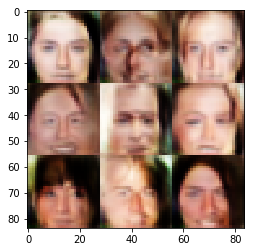

Epoch 1/1-Step 6010... Discriminator Loss: 1.3203... Generator Loss: 0.7839
Epoch 1/1-Step 6020... Discriminator Loss: 1.4128... Generator Loss: 0.7078
Epoch 1/1-Step 6030... Discriminator Loss: 1.5910... Generator Loss: 0.6148
Epoch 1/1-Step 6040... Discriminator Loss: 1.4653... Generator Loss: 0.8717
Epoch 1/1-Step 6050... Discriminator Loss: 1.7522... Generator Loss: 0.9054
Epoch 1/1-Step 6060... Discriminator Loss: 1.3762... Generator Loss: 1.0431
Epoch 1/1-Step 6070... Discriminator Loss: 1.5753... Generator Loss: 0.7253
Epoch 1/1-Step 6080... Discriminator Loss: 1.4033... Generator Loss: 0.9338
Epoch 1/1-Step 6090... Discriminator Loss: 1.2361... Generator Loss: 0.8381
Epoch 1/1-Step 6100... Discriminator Loss: 1.6563... Generator Loss: 0.6171


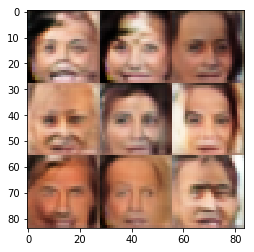

Epoch 1/1-Step 6110... Discriminator Loss: 1.3800... Generator Loss: 0.9543
Epoch 1/1-Step 6120... Discriminator Loss: 1.4016... Generator Loss: 0.6586
Epoch 1/1-Step 6130... Discriminator Loss: 1.4016... Generator Loss: 0.7899
Epoch 1/1-Step 6140... Discriminator Loss: 1.4648... Generator Loss: 0.7876
Epoch 1/1-Step 6150... Discriminator Loss: 1.2822... Generator Loss: 0.7874
Epoch 1/1-Step 6160... Discriminator Loss: 1.4370... Generator Loss: 0.8804
Epoch 1/1-Step 6170... Discriminator Loss: 1.5832... Generator Loss: 0.7170
Epoch 1/1-Step 6180... Discriminator Loss: 1.6901... Generator Loss: 0.7309
Epoch 1/1-Step 6190... Discriminator Loss: 1.4601... Generator Loss: 0.7070
Epoch 1/1-Step 6200... Discriminator Loss: 1.5494... Generator Loss: 0.8740


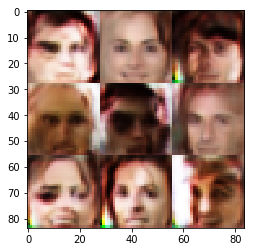

Epoch 1/1-Step 6210... Discriminator Loss: 1.5020... Generator Loss: 0.7783
Epoch 1/1-Step 6220... Discriminator Loss: 1.3836... Generator Loss: 0.8767
Epoch 1/1-Step 6230... Discriminator Loss: 1.2711... Generator Loss: 0.7823
Epoch 1/1-Step 6240... Discriminator Loss: 1.3631... Generator Loss: 0.7754
Epoch 1/1-Step 6250... Discriminator Loss: 1.2764... Generator Loss: 0.7984
Epoch 1/1-Step 6260... Discriminator Loss: 1.4023... Generator Loss: 0.8042
Epoch 1/1-Step 6270... Discriminator Loss: 1.4534... Generator Loss: 0.7786
Epoch 1/1-Step 6280... Discriminator Loss: 1.4395... Generator Loss: 0.9211
Epoch 1/1-Step 6290... Discriminator Loss: 1.7293... Generator Loss: 0.7617
Epoch 1/1-Step 6300... Discriminator Loss: 1.4211... Generator Loss: 0.7980


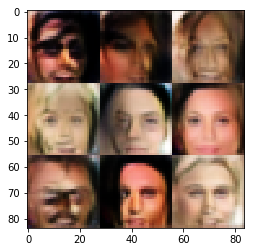

Epoch 1/1-Step 6310... Discriminator Loss: 1.3222... Generator Loss: 0.7418
Epoch 1/1-Step 6320... Discriminator Loss: 1.5442... Generator Loss: 0.7134
Epoch 1/1-Step 6330... Discriminator Loss: 1.3139... Generator Loss: 0.9803
Epoch 1/1-Step 6340... Discriminator Loss: 1.6821... Generator Loss: 0.5913
Epoch 1/1-Step 6350... Discriminator Loss: 1.4928... Generator Loss: 0.7019
Epoch 1/1-Step 6360... Discriminator Loss: 1.7137... Generator Loss: 0.7491
Epoch 1/1-Step 6370... Discriminator Loss: 1.2787... Generator Loss: 0.9492
Epoch 1/1-Step 6380... Discriminator Loss: 1.3087... Generator Loss: 0.7035
Epoch 1/1-Step 6390... Discriminator Loss: 1.5177... Generator Loss: 0.6452
Epoch 1/1-Step 6400... Discriminator Loss: 1.5534... Generator Loss: 0.7097


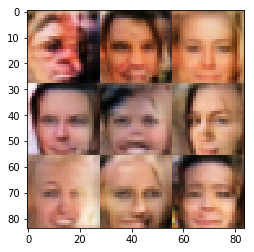

Epoch 1/1-Step 6410... Discriminator Loss: 1.4230... Generator Loss: 0.8357
Epoch 1/1-Step 6420... Discriminator Loss: 1.5231... Generator Loss: 0.8468
Epoch 1/1-Step 6430... Discriminator Loss: 1.2886... Generator Loss: 0.9715
Epoch 1/1-Step 6440... Discriminator Loss: 1.5898... Generator Loss: 0.7024
Epoch 1/1-Step 6450... Discriminator Loss: 1.4828... Generator Loss: 0.6253
Epoch 1/1-Step 6460... Discriminator Loss: 1.4022... Generator Loss: 0.7826
Epoch 1/1-Step 6470... Discriminator Loss: 1.4482... Generator Loss: 0.8871
Epoch 1/1-Step 6480... Discriminator Loss: 1.2896... Generator Loss: 0.8432
Epoch 1/1-Step 6490... Discriminator Loss: 1.3794... Generator Loss: 0.6385
Epoch 1/1-Step 6500... Discriminator Loss: 1.3448... Generator Loss: 0.8719


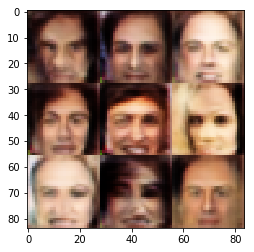

Epoch 1/1-Step 6510... Discriminator Loss: 1.5633... Generator Loss: 0.7200
Epoch 1/1-Step 6520... Discriminator Loss: 1.2998... Generator Loss: 0.7419
Epoch 1/1-Step 6530... Discriminator Loss: 1.2107... Generator Loss: 0.8752
Epoch 1/1-Step 6540... Discriminator Loss: 1.6673... Generator Loss: 0.9346
Epoch 1/1-Step 6550... Discriminator Loss: 1.4481... Generator Loss: 0.8061
Epoch 1/1-Step 6560... Discriminator Loss: 1.1742... Generator Loss: 0.7871
Epoch 1/1-Step 6570... Discriminator Loss: 1.4755... Generator Loss: 0.9317
Epoch 1/1-Step 6580... Discriminator Loss: 1.4640... Generator Loss: 0.9636
Epoch 1/1-Step 6590... Discriminator Loss: 1.3566... Generator Loss: 0.7615
Epoch 1/1-Step 6600... Discriminator Loss: 1.2830... Generator Loss: 0.7147


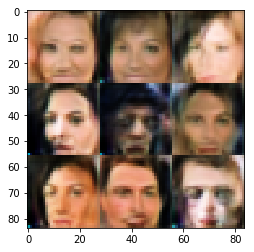

Epoch 1/1-Step 6610... Discriminator Loss: 1.6832... Generator Loss: 0.6913
Epoch 1/1-Step 6620... Discriminator Loss: 1.5239... Generator Loss: 0.8743
Epoch 1/1-Step 6630... Discriminator Loss: 1.4028... Generator Loss: 0.6859
Epoch 1/1-Step 6640... Discriminator Loss: 1.4776... Generator Loss: 0.8069
Epoch 1/1-Step 6650... Discriminator Loss: 1.6406... Generator Loss: 0.7486
Epoch 1/1-Step 6660... Discriminator Loss: 1.3582... Generator Loss: 0.9390
Epoch 1/1-Step 6670... Discriminator Loss: 1.6321... Generator Loss: 0.6592
Epoch 1/1-Step 6680... Discriminator Loss: 1.5398... Generator Loss: 0.9347
Epoch 1/1-Step 6690... Discriminator Loss: 1.6167... Generator Loss: 1.0672
Epoch 1/1-Step 6700... Discriminator Loss: 1.4168... Generator Loss: 0.7212


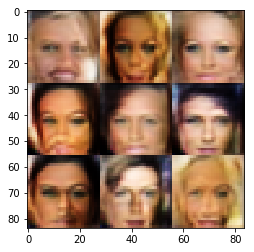

Epoch 1/1-Step 6710... Discriminator Loss: 1.5981... Generator Loss: 0.4664
Epoch 1/1-Step 6720... Discriminator Loss: 1.5008... Generator Loss: 0.7696
Epoch 1/1-Step 6730... Discriminator Loss: 1.8466... Generator Loss: 0.6465
Epoch 1/1-Step 6740... Discriminator Loss: 1.4396... Generator Loss: 0.7880
Epoch 1/1-Step 6750... Discriminator Loss: 1.5017... Generator Loss: 0.7424
Epoch 1/1-Step 6760... Discriminator Loss: 1.5507... Generator Loss: 0.6303
Epoch 1/1-Step 6770... Discriminator Loss: 1.3082... Generator Loss: 0.8959
Epoch 1/1-Step 6780... Discriminator Loss: 1.7568... Generator Loss: 0.5531
Epoch 1/1-Step 6790... Discriminator Loss: 1.2920... Generator Loss: 0.6762
Epoch 1/1-Step 6800... Discriminator Loss: 1.5200... Generator Loss: 0.7450


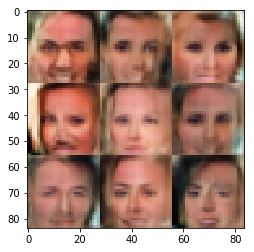

Epoch 1/1-Step 6810... Discriminator Loss: 1.3104... Generator Loss: 0.9882
Epoch 1/1-Step 6820... Discriminator Loss: 1.3435... Generator Loss: 1.2353
Epoch 1/1-Step 6830... Discriminator Loss: 1.1359... Generator Loss: 0.7902
Epoch 1/1-Step 6840... Discriminator Loss: 1.4087... Generator Loss: 0.6343
Epoch 1/1-Step 6850... Discriminator Loss: 1.3144... Generator Loss: 0.7056
Epoch 1/1-Step 6860... Discriminator Loss: 1.4977... Generator Loss: 0.8563
Epoch 1/1-Step 6870... Discriminator Loss: 1.4116... Generator Loss: 1.0645
Epoch 1/1-Step 6880... Discriminator Loss: 1.4191... Generator Loss: 1.0519
Epoch 1/1-Step 6890... Discriminator Loss: 1.5543... Generator Loss: 0.5972
Epoch 1/1-Step 6900... Discriminator Loss: 1.3013... Generator Loss: 0.9223


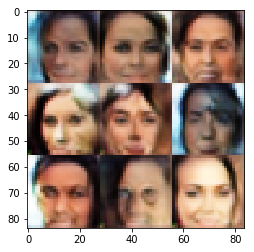

Epoch 1/1-Step 6910... Discriminator Loss: 1.4314... Generator Loss: 0.9101
Epoch 1/1-Step 6920... Discriminator Loss: 1.3602... Generator Loss: 0.7910
Epoch 1/1-Step 6930... Discriminator Loss: 1.4245... Generator Loss: 0.8057
Epoch 1/1-Step 6940... Discriminator Loss: 1.3132... Generator Loss: 0.8169
Epoch 1/1-Step 6950... Discriminator Loss: 1.4812... Generator Loss: 0.5608
Epoch 1/1-Step 6960... Discriminator Loss: 1.3330... Generator Loss: 0.7081
Epoch 1/1-Step 6970... Discriminator Loss: 1.7487... Generator Loss: 0.7917
Epoch 1/1-Step 6980... Discriminator Loss: 1.3499... Generator Loss: 0.7759
Epoch 1/1-Step 6990... Discriminator Loss: 1.3482... Generator Loss: 0.9711
Epoch 1/1-Step 7000... Discriminator Loss: 1.2888... Generator Loss: 0.9719


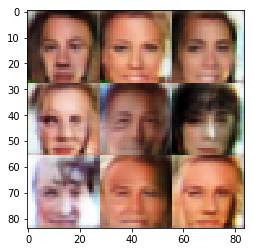

Epoch 1/1-Step 7010... Discriminator Loss: 1.5234... Generator Loss: 0.5683
Epoch 1/1-Step 7020... Discriminator Loss: 1.4594... Generator Loss: 0.8179
Epoch 1/1-Step 7030... Discriminator Loss: 1.2845... Generator Loss: 0.7871
Epoch 1/1-Step 7040... Discriminator Loss: 1.7051... Generator Loss: 0.4298
Epoch 1/1-Step 7050... Discriminator Loss: 1.8542... Generator Loss: 0.4715
Epoch 1/1-Step 7060... Discriminator Loss: 1.3809... Generator Loss: 0.8507
Epoch 1/1-Step 7070... Discriminator Loss: 1.3072... Generator Loss: 0.7898
Epoch 1/1-Step 7080... Discriminator Loss: 1.4766... Generator Loss: 0.8204
Epoch 1/1-Step 7090... Discriminator Loss: 1.3707... Generator Loss: 0.6629
Epoch 1/1-Step 7100... Discriminator Loss: 1.4636... Generator Loss: 0.8876


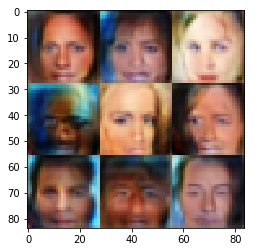

Epoch 1/1-Step 7110... Discriminator Loss: 1.3131... Generator Loss: 0.7485
Epoch 1/1-Step 7120... Discriminator Loss: 1.2582... Generator Loss: 0.9262
Epoch 1/1-Step 7130... Discriminator Loss: 1.3768... Generator Loss: 0.9119
Epoch 1/1-Step 7140... Discriminator Loss: 1.7029... Generator Loss: 0.7280
Epoch 1/1-Step 7150... Discriminator Loss: 1.2092... Generator Loss: 0.7597
Epoch 1/1-Step 7160... Discriminator Loss: 1.3700... Generator Loss: 0.7609
Epoch 1/1-Step 7170... Discriminator Loss: 1.4676... Generator Loss: 0.7798
Epoch 1/1-Step 7180... Discriminator Loss: 1.3671... Generator Loss: 0.9741
Epoch 1/1-Step 7190... Discriminator Loss: 1.2731... Generator Loss: 0.6481
Epoch 1/1-Step 7200... Discriminator Loss: 1.3359... Generator Loss: 0.7306


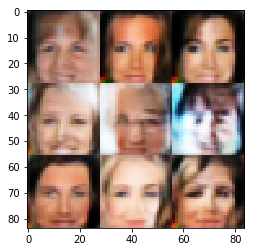

Epoch 1/1-Step 7210... Discriminator Loss: 1.5297... Generator Loss: 0.8224
Epoch 1/1-Step 7220... Discriminator Loss: 1.3420... Generator Loss: 0.7128
Epoch 1/1-Step 7230... Discriminator Loss: 1.4625... Generator Loss: 0.6799
Epoch 1/1-Step 7240... Discriminator Loss: 1.1714... Generator Loss: 0.8914
Epoch 1/1-Step 7250... Discriminator Loss: 1.5818... Generator Loss: 0.7320
Epoch 1/1-Step 7260... Discriminator Loss: 1.3664... Generator Loss: 0.7976
Epoch 1/1-Step 7270... Discriminator Loss: 1.5032... Generator Loss: 0.4953
Epoch 1/1-Step 7280... Discriminator Loss: 1.5580... Generator Loss: 0.9459
Epoch 1/1-Step 7290... Discriminator Loss: 1.3796... Generator Loss: 0.7077
Epoch 1/1-Step 7300... Discriminator Loss: 1.4201... Generator Loss: 0.8195


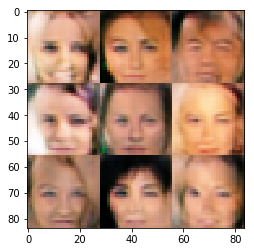

Epoch 1/1-Step 7310... Discriminator Loss: 1.4778... Generator Loss: 1.0325
Epoch 1/1-Step 7320... Discriminator Loss: 1.4020... Generator Loss: 0.8997
Epoch 1/1-Step 7330... Discriminator Loss: 1.3293... Generator Loss: 0.7710
Epoch 1/1-Step 7340... Discriminator Loss: 1.4421... Generator Loss: 0.7427
Epoch 1/1-Step 7350... Discriminator Loss: 1.3939... Generator Loss: 0.7963
Epoch 1/1-Step 7360... Discriminator Loss: 1.3132... Generator Loss: 1.0574
Epoch 1/1-Step 7370... Discriminator Loss: 1.4085... Generator Loss: 0.7144
Epoch 1/1-Step 7380... Discriminator Loss: 1.6673... Generator Loss: 0.7668
Epoch 1/1-Step 7390... Discriminator Loss: 1.7228... Generator Loss: 0.6862
Epoch 1/1-Step 7400... Discriminator Loss: 1.3159... Generator Loss: 0.8038


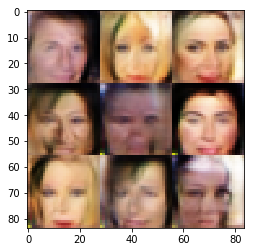

Epoch 1/1-Step 7410... Discriminator Loss: 1.2452... Generator Loss: 0.9329
Epoch 1/1-Step 7420... Discriminator Loss: 1.3113... Generator Loss: 1.0131
Epoch 1/1-Step 7430... Discriminator Loss: 1.3944... Generator Loss: 0.8405
Epoch 1/1-Step 7440... Discriminator Loss: 1.5701... Generator Loss: 0.6464
Epoch 1/1-Step 7450... Discriminator Loss: 1.5497... Generator Loss: 0.6989
Epoch 1/1-Step 7460... Discriminator Loss: 1.3282... Generator Loss: 0.8715
Epoch 1/1-Step 7470... Discriminator Loss: 1.3463... Generator Loss: 0.9407
Epoch 1/1-Step 7480... Discriminator Loss: 1.3872... Generator Loss: 0.8756
Epoch 1/1-Step 7490... Discriminator Loss: 1.4650... Generator Loss: 0.7903
Epoch 1/1-Step 7500... Discriminator Loss: 1.6060... Generator Loss: 0.7171


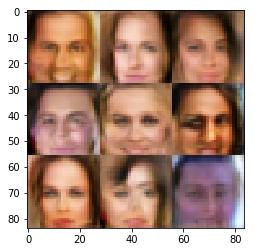

Epoch 1/1-Step 7510... Discriminator Loss: 1.5941... Generator Loss: 0.9093
Epoch 1/1-Step 7520... Discriminator Loss: 1.4365... Generator Loss: 0.8351
Epoch 1/1-Step 7530... Discriminator Loss: 1.2449... Generator Loss: 0.9179
Epoch 1/1-Step 7540... Discriminator Loss: 1.2767... Generator Loss: 0.7730
Epoch 1/1-Step 7550... Discriminator Loss: 1.3225... Generator Loss: 1.0675
Epoch 1/1-Step 7560... Discriminator Loss: 1.4835... Generator Loss: 0.6993
Epoch 1/1-Step 7570... Discriminator Loss: 1.5442... Generator Loss: 0.7474
Epoch 1/1-Step 7580... Discriminator Loss: 1.2541... Generator Loss: 0.8181
Epoch 1/1-Step 7590... Discriminator Loss: 1.5195... Generator Loss: 0.8365
Epoch 1/1-Step 7600... Discriminator Loss: 1.3852... Generator Loss: 0.8290


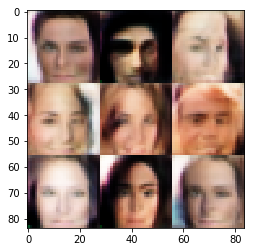

Epoch 1/1-Step 7610... Discriminator Loss: 1.4413... Generator Loss: 0.6986
Epoch 1/1-Step 7620... Discriminator Loss: 1.1399... Generator Loss: 1.0401
Epoch 1/1-Step 7630... Discriminator Loss: 1.6043... Generator Loss: 0.8657
Epoch 1/1-Step 7640... Discriminator Loss: 1.2415... Generator Loss: 0.7136
Epoch 1/1-Step 7650... Discriminator Loss: 1.4320... Generator Loss: 0.8120
Epoch 1/1-Step 7660... Discriminator Loss: 1.4469... Generator Loss: 0.7746
Epoch 1/1-Step 7670... Discriminator Loss: 1.5370... Generator Loss: 0.4515
Epoch 1/1-Step 7680... Discriminator Loss: 1.4170... Generator Loss: 0.7300
Epoch 1/1-Step 7690... Discriminator Loss: 1.3316... Generator Loss: 0.7466
Epoch 1/1-Step 7700... Discriminator Loss: 1.3313... Generator Loss: 0.7142


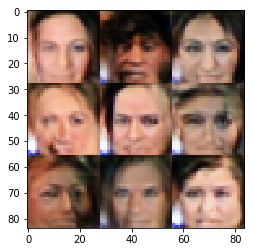

Epoch 1/1-Step 7710... Discriminator Loss: 1.3184... Generator Loss: 0.9367
Epoch 1/1-Step 7720... Discriminator Loss: 1.3341... Generator Loss: 0.7573
Epoch 1/1-Step 7730... Discriminator Loss: 1.1874... Generator Loss: 0.8370
Epoch 1/1-Step 7740... Discriminator Loss: 1.4749... Generator Loss: 0.7949
Epoch 1/1-Step 7750... Discriminator Loss: 1.4547... Generator Loss: 0.8975
Epoch 1/1-Step 7760... Discriminator Loss: 1.3196... Generator Loss: 0.8681
Epoch 1/1-Step 7770... Discriminator Loss: 1.1391... Generator Loss: 0.8448
Epoch 1/1-Step 7780... Discriminator Loss: 1.5548... Generator Loss: 0.8652
Epoch 1/1-Step 7790... Discriminator Loss: 1.3386... Generator Loss: 0.5819
Epoch 1/1-Step 7800... Discriminator Loss: 1.3970... Generator Loss: 0.8801


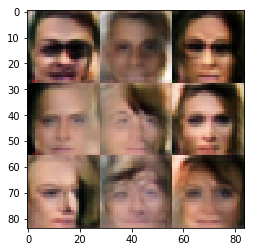

Epoch 1/1-Step 7810... Discriminator Loss: 1.2564... Generator Loss: 0.8303
Epoch 1/1-Step 7820... Discriminator Loss: 1.5232... Generator Loss: 0.7860
Epoch 1/1-Step 7830... Discriminator Loss: 1.4922... Generator Loss: 0.8832
Epoch 1/1-Step 7840... Discriminator Loss: 1.1502... Generator Loss: 0.7599
Epoch 1/1-Step 7850... Discriminator Loss: 1.3228... Generator Loss: 0.7369
Epoch 1/1-Step 7860... Discriminator Loss: 1.4072... Generator Loss: 0.9205
Epoch 1/1-Step 7870... Discriminator Loss: 1.5092... Generator Loss: 0.7181
Epoch 1/1-Step 7880... Discriminator Loss: 1.2182... Generator Loss: 0.8111
Epoch 1/1-Step 7890... Discriminator Loss: 1.4104... Generator Loss: 0.8939
Epoch 1/1-Step 7900... Discriminator Loss: 1.2429... Generator Loss: 0.7198


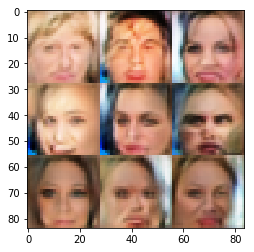

Epoch 1/1-Step 7910... Discriminator Loss: 1.4885... Generator Loss: 0.7308
Epoch 1/1-Step 7920... Discriminator Loss: 1.5290... Generator Loss: 1.0555
Epoch 1/1-Step 7930... Discriminator Loss: 1.2758... Generator Loss: 0.9313
Epoch 1/1-Step 7940... Discriminator Loss: 1.3991... Generator Loss: 0.7532
Epoch 1/1-Step 7950... Discriminator Loss: 1.3558... Generator Loss: 0.7273
Epoch 1/1-Step 7960... Discriminator Loss: 1.2681... Generator Loss: 0.8287
Epoch 1/1-Step 7970... Discriminator Loss: 1.4279... Generator Loss: 0.8256
Epoch 1/1-Step 7980... Discriminator Loss: 1.4797... Generator Loss: 0.9346
Epoch 1/1-Step 7990... Discriminator Loss: 1.4607... Generator Loss: 0.7711
Epoch 1/1-Step 8000... Discriminator Loss: 1.4272... Generator Loss: 0.7907


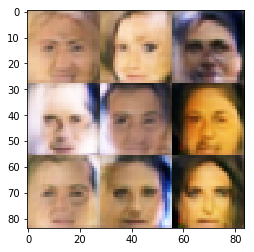

Epoch 1/1-Step 8010... Discriminator Loss: 1.2898... Generator Loss: 0.7857
Epoch 1/1-Step 8020... Discriminator Loss: 1.4224... Generator Loss: 0.6170
Epoch 1/1-Step 8030... Discriminator Loss: 1.3454... Generator Loss: 0.7413
Epoch 1/1-Step 8040... Discriminator Loss: 1.3122... Generator Loss: 0.7526
Epoch 1/1-Step 8050... Discriminator Loss: 1.4496... Generator Loss: 0.8310
Epoch 1/1-Step 8060... Discriminator Loss: 1.2493... Generator Loss: 0.7688
Epoch 1/1-Step 8070... Discriminator Loss: 1.3621... Generator Loss: 0.6786
Epoch 1/1-Step 8080... Discriminator Loss: 1.5462... Generator Loss: 0.7908
Epoch 1/1-Step 8090... Discriminator Loss: 1.4604... Generator Loss: 0.7219
Epoch 1/1-Step 8100... Discriminator Loss: 1.4296... Generator Loss: 1.0000


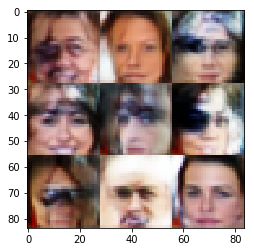

Epoch 1/1-Step 8110... Discriminator Loss: 1.4757... Generator Loss: 0.8027
Epoch 1/1-Step 8120... Discriminator Loss: 1.4487... Generator Loss: 0.6392
Epoch 1/1-Step 8130... Discriminator Loss: 1.4130... Generator Loss: 0.7898
Epoch 1/1-Step 8140... Discriminator Loss: 1.4286... Generator Loss: 1.0276
Epoch 1/1-Step 8150... Discriminator Loss: 1.5710... Generator Loss: 0.7437
Epoch 1/1-Step 8160... Discriminator Loss: 1.3216... Generator Loss: 0.9824
Epoch 1/1-Step 8170... Discriminator Loss: 1.4902... Generator Loss: 0.7336
Epoch 1/1-Step 8180... Discriminator Loss: 1.3396... Generator Loss: 0.7715
Epoch 1/1-Step 8190... Discriminator Loss: 1.4304... Generator Loss: 0.9224
Epoch 1/1-Step 8200... Discriminator Loss: 1.4550... Generator Loss: 0.7752


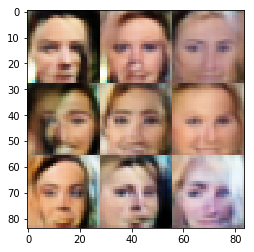

Epoch 1/1-Step 8210... Discriminator Loss: 1.4445... Generator Loss: 0.7623
Epoch 1/1-Step 8220... Discriminator Loss: 1.4200... Generator Loss: 0.7617
Epoch 1/1-Step 8230... Discriminator Loss: 1.1172... Generator Loss: 0.8498
Epoch 1/1-Step 8240... Discriminator Loss: 1.5483... Generator Loss: 0.7358
Epoch 1/1-Step 8250... Discriminator Loss: 1.6734... Generator Loss: 0.7975
Epoch 1/1-Step 8260... Discriminator Loss: 1.4886... Generator Loss: 0.6588
Epoch 1/1-Step 8270... Discriminator Loss: 1.2841... Generator Loss: 0.8001
Epoch 1/1-Step 8280... Discriminator Loss: 1.4488... Generator Loss: 0.8065
Epoch 1/1-Step 8290... Discriminator Loss: 1.5152... Generator Loss: 0.7439
Epoch 1/1-Step 8300... Discriminator Loss: 1.4619... Generator Loss: 0.7942


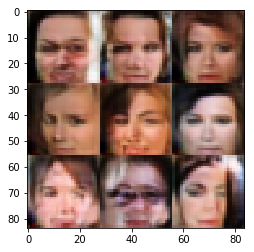

Epoch 1/1-Step 8310... Discriminator Loss: 1.3789... Generator Loss: 0.8775
Epoch 1/1-Step 8320... Discriminator Loss: 1.3144... Generator Loss: 0.9968
Epoch 1/1-Step 8330... Discriminator Loss: 1.6090... Generator Loss: 0.6775
Epoch 1/1-Step 8340... Discriminator Loss: 1.2479... Generator Loss: 0.8178
Epoch 1/1-Step 8350... Discriminator Loss: 1.5151... Generator Loss: 0.8977
Epoch 1/1-Step 8360... Discriminator Loss: 1.3956... Generator Loss: 0.8187
Epoch 1/1-Step 8370... Discriminator Loss: 1.4939... Generator Loss: 0.7903
Epoch 1/1-Step 8380... Discriminator Loss: 1.3979... Generator Loss: 0.6723
Epoch 1/1-Step 8390... Discriminator Loss: 1.3989... Generator Loss: 0.7754
Epoch 1/1-Step 8400... Discriminator Loss: 1.3765... Generator Loss: 0.7052


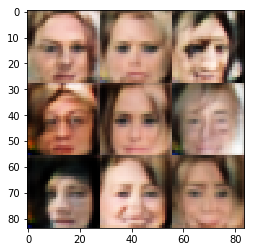

Epoch 1/1-Step 8410... Discriminator Loss: 1.7072... Generator Loss: 0.7592
Epoch 1/1-Step 8420... Discriminator Loss: 1.4405... Generator Loss: 0.7637
Epoch 1/1-Step 8430... Discriminator Loss: 1.3000... Generator Loss: 1.0078
Epoch 1/1-Step 8440... Discriminator Loss: 1.4366... Generator Loss: 0.8232
Epoch 1/1-Step 8450... Discriminator Loss: 1.6770... Generator Loss: 0.6622
Epoch 1/1-Step 8460... Discriminator Loss: 1.3857... Generator Loss: 0.7809
Epoch 1/1-Step 8470... Discriminator Loss: 1.3647... Generator Loss: 0.6839
Epoch 1/1-Step 8480... Discriminator Loss: 1.2338... Generator Loss: 0.8962
Epoch 1/1-Step 8490... Discriminator Loss: 1.4571... Generator Loss: 0.7776
Epoch 1/1-Step 8500... Discriminator Loss: 1.3789... Generator Loss: 1.0501


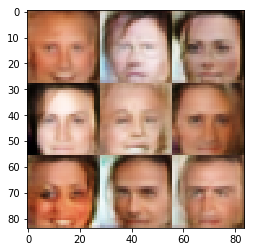

Epoch 1/1-Step 8510... Discriminator Loss: 1.4961... Generator Loss: 0.7628
Epoch 1/1-Step 8520... Discriminator Loss: 1.4442... Generator Loss: 0.7187
Epoch 1/1-Step 8530... Discriminator Loss: 1.4512... Generator Loss: 0.9546
Epoch 1/1-Step 8540... Discriminator Loss: 1.4886... Generator Loss: 0.8847
Epoch 1/1-Step 8550... Discriminator Loss: 1.2711... Generator Loss: 0.9819
Epoch 1/1-Step 8560... Discriminator Loss: 1.4398... Generator Loss: 0.7477
Epoch 1/1-Step 8570... Discriminator Loss: 1.3999... Generator Loss: 0.7235
Epoch 1/1-Step 8580... Discriminator Loss: 1.2959... Generator Loss: 0.8604
Epoch 1/1-Step 8590... Discriminator Loss: 1.4778... Generator Loss: 0.6832
Epoch 1/1-Step 8600... Discriminator Loss: 1.3924... Generator Loss: 0.9010


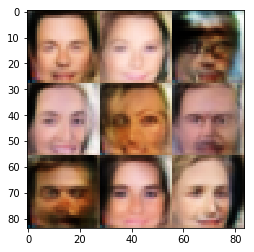

Epoch 1/1-Step 8610... Discriminator Loss: 1.3040... Generator Loss: 0.7070
Epoch 1/1-Step 8620... Discriminator Loss: 1.2790... Generator Loss: 0.8604
Epoch 1/1-Step 8630... Discriminator Loss: 1.2457... Generator Loss: 0.8689
Epoch 1/1-Step 8640... Discriminator Loss: 1.4526... Generator Loss: 0.7422
Epoch 1/1-Step 8650... Discriminator Loss: 1.3948... Generator Loss: 0.8504
Epoch 1/1-Step 8660... Discriminator Loss: 1.3248... Generator Loss: 0.9155
Epoch 1/1-Step 8670... Discriminator Loss: 1.5329... Generator Loss: 0.8403
Epoch 1/1-Step 8680... Discriminator Loss: 1.3771... Generator Loss: 0.7440
Epoch 1/1-Step 8690... Discriminator Loss: 1.3710... Generator Loss: 0.7733
Epoch 1/1-Step 8700... Discriminator Loss: 1.2870... Generator Loss: 1.0761


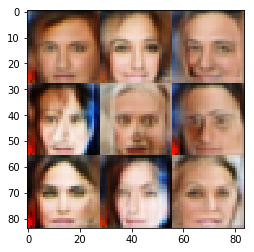

Epoch 1/1-Step 8710... Discriminator Loss: 1.2801... Generator Loss: 0.8817
Epoch 1/1-Step 8720... Discriminator Loss: 1.4866... Generator Loss: 0.4617
Epoch 1/1-Step 8730... Discriminator Loss: 1.4093... Generator Loss: 0.7667
Epoch 1/1-Step 8740... Discriminator Loss: 1.4472... Generator Loss: 0.7394
Epoch 1/1-Step 8750... Discriminator Loss: 1.3565... Generator Loss: 1.0057
Epoch 1/1-Step 8760... Discriminator Loss: 1.5551... Generator Loss: 0.8387
Epoch 1/1-Step 8770... Discriminator Loss: 1.4306... Generator Loss: 0.9035
Epoch 1/1-Step 8780... Discriminator Loss: 1.3470... Generator Loss: 0.7870
Epoch 1/1-Step 8790... Discriminator Loss: 1.1758... Generator Loss: 0.9317
Epoch 1/1-Step 8800... Discriminator Loss: 1.7832... Generator Loss: 0.5622


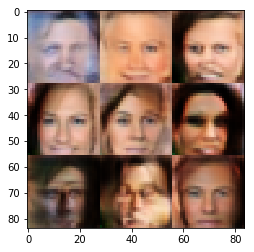

Epoch 1/1-Step 8810... Discriminator Loss: 1.4859... Generator Loss: 0.6879
Epoch 1/1-Step 8820... Discriminator Loss: 1.3202... Generator Loss: 0.9934
Epoch 1/1-Step 8830... Discriminator Loss: 1.3614... Generator Loss: 0.7921
Epoch 1/1-Step 8840... Discriminator Loss: 1.4707... Generator Loss: 0.8216
Epoch 1/1-Step 8850... Discriminator Loss: 1.3681... Generator Loss: 0.8966
Epoch 1/1-Step 8860... Discriminator Loss: 1.4595... Generator Loss: 0.7677
Epoch 1/1-Step 8870... Discriminator Loss: 1.2765... Generator Loss: 0.7567
Epoch 1/1-Step 8880... Discriminator Loss: 1.3029... Generator Loss: 1.0909
Epoch 1/1-Step 8890... Discriminator Loss: 1.4201... Generator Loss: 0.6570
Epoch 1/1-Step 8900... Discriminator Loss: 1.5210... Generator Loss: 0.8050


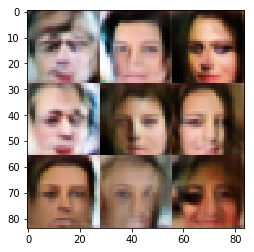

Epoch 1/1-Step 8910... Discriminator Loss: 1.6994... Generator Loss: 0.6114
Epoch 1/1-Step 8920... Discriminator Loss: 1.5626... Generator Loss: 0.6903
Epoch 1/1-Step 8930... Discriminator Loss: 1.6196... Generator Loss: 0.7636
Epoch 1/1-Step 8940... Discriminator Loss: 1.3288... Generator Loss: 1.0120
Epoch 1/1-Step 8950... Discriminator Loss: 1.4728... Generator Loss: 0.7880
Epoch 1/1-Step 8960... Discriminator Loss: 1.5478... Generator Loss: 0.7824
Epoch 1/1-Step 8970... Discriminator Loss: 1.5614... Generator Loss: 0.6430
Epoch 1/1-Step 8980... Discriminator Loss: 1.5400... Generator Loss: 0.8293
Epoch 1/1-Step 8990... Discriminator Loss: 1.4078... Generator Loss: 0.6796
Epoch 1/1-Step 9000... Discriminator Loss: 1.4296... Generator Loss: 0.8616


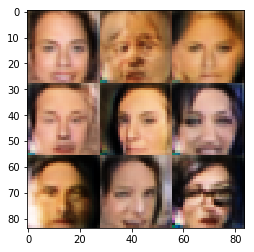

Epoch 1/1-Step 9010... Discriminator Loss: 1.3790... Generator Loss: 0.8356
Epoch 1/1-Step 9020... Discriminator Loss: 1.4117... Generator Loss: 0.7046
Epoch 1/1-Step 9030... Discriminator Loss: 1.2722... Generator Loss: 0.8328
Epoch 1/1-Step 9040... Discriminator Loss: 1.4026... Generator Loss: 0.7923
Epoch 1/1-Step 9050... Discriminator Loss: 1.4994... Generator Loss: 0.7725
Epoch 1/1-Step 9060... Discriminator Loss: 1.3455... Generator Loss: 0.7827
Epoch 1/1-Step 9070... Discriminator Loss: 1.4406... Generator Loss: 0.8783
Epoch 1/1-Step 9080... Discriminator Loss: 1.5039... Generator Loss: 0.5461
Epoch 1/1-Step 9090... Discriminator Loss: 1.4151... Generator Loss: 0.8387
Epoch 1/1-Step 9100... Discriminator Loss: 1.2660... Generator Loss: 0.7873


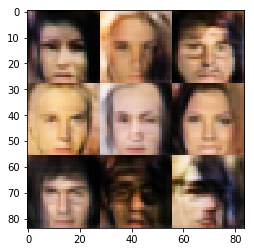

Epoch 1/1-Step 9110... Discriminator Loss: 1.6979... Generator Loss: 0.7636
Epoch 1/1-Step 9120... Discriminator Loss: 1.3256... Generator Loss: 0.8592
Epoch 1/1-Step 9130... Discriminator Loss: 1.3613... Generator Loss: 0.6400
Epoch 1/1-Step 9140... Discriminator Loss: 1.3697... Generator Loss: 0.8042
Epoch 1/1-Step 9150... Discriminator Loss: 1.3631... Generator Loss: 0.7997
Epoch 1/1-Step 9160... Discriminator Loss: 1.3487... Generator Loss: 0.7175
Epoch 1/1-Step 9170... Discriminator Loss: 1.5507... Generator Loss: 0.6901
Epoch 1/1-Step 9180... Discriminator Loss: 1.4207... Generator Loss: 0.8358
Epoch 1/1-Step 9190... Discriminator Loss: 1.3789... Generator Loss: 0.7480
Epoch 1/1-Step 9200... Discriminator Loss: 1.2807... Generator Loss: 0.6159


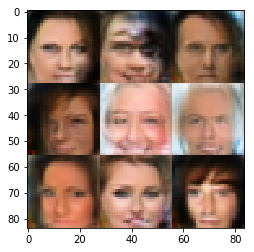

Epoch 1/1-Step 9210... Discriminator Loss: 1.5555... Generator Loss: 0.9003
Epoch 1/1-Step 9220... Discriminator Loss: 1.5975... Generator Loss: 0.8965
Epoch 1/1-Step 9230... Discriminator Loss: 1.3636... Generator Loss: 0.6376
Epoch 1/1-Step 9240... Discriminator Loss: 1.2529... Generator Loss: 0.9186
Epoch 1/1-Step 9250... Discriminator Loss: 1.4379... Generator Loss: 0.8917
Epoch 1/1-Step 9260... Discriminator Loss: 1.6029... Generator Loss: 0.8227
Epoch 1/1-Step 9270... Discriminator Loss: 1.5843... Generator Loss: 0.7934
Epoch 1/1-Step 9280... Discriminator Loss: 1.5361... Generator Loss: 0.5071
Epoch 1/1-Step 9290... Discriminator Loss: 1.3000... Generator Loss: 0.8819
Epoch 1/1-Step 9300... Discriminator Loss: 1.4055... Generator Loss: 0.8635


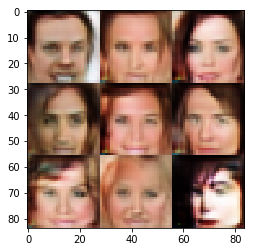

Epoch 1/1-Step 9310... Discriminator Loss: 1.4435... Generator Loss: 0.8696
Epoch 1/1-Step 9320... Discriminator Loss: 1.4161... Generator Loss: 0.8086
Epoch 1/1-Step 9330... Discriminator Loss: 1.2543... Generator Loss: 1.0072
Epoch 1/1-Step 9340... Discriminator Loss: 1.3282... Generator Loss: 0.8115
Epoch 1/1-Step 9350... Discriminator Loss: 1.5271... Generator Loss: 0.6300
Epoch 1/1-Step 9360... Discriminator Loss: 1.4608... Generator Loss: 0.8856
Epoch 1/1-Step 9370... Discriminator Loss: 1.4150... Generator Loss: 0.7733
Epoch 1/1-Step 9380... Discriminator Loss: 1.3764... Generator Loss: 0.6170
Epoch 1/1-Step 9390... Discriminator Loss: 1.4807... Generator Loss: 0.8092
Epoch 1/1-Step 9400... Discriminator Loss: 1.3529... Generator Loss: 0.9089


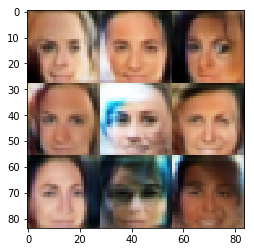

Epoch 1/1-Step 9410... Discriminator Loss: 1.2223... Generator Loss: 0.8422
Epoch 1/1-Step 9420... Discriminator Loss: 1.3734... Generator Loss: 0.9582
Epoch 1/1-Step 9430... Discriminator Loss: 1.3146... Generator Loss: 0.7735
Epoch 1/1-Step 9440... Discriminator Loss: 1.3670... Generator Loss: 0.7866
Epoch 1/1-Step 9450... Discriminator Loss: 1.4191... Generator Loss: 0.8354
Epoch 1/1-Step 9460... Discriminator Loss: 1.3997... Generator Loss: 0.6151
Epoch 1/1-Step 9470... Discriminator Loss: 1.4929... Generator Loss: 0.6021
Epoch 1/1-Step 9480... Discriminator Loss: 1.5720... Generator Loss: 0.8717
Epoch 1/1-Step 9490... Discriminator Loss: 1.4754... Generator Loss: 0.8908
Epoch 1/1-Step 9500... Discriminator Loss: 1.4898... Generator Loss: 0.8116


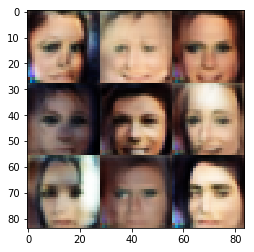

Epoch 1/1-Step 9510... Discriminator Loss: 1.2624... Generator Loss: 0.8489
Epoch 1/1-Step 9520... Discriminator Loss: 1.3049... Generator Loss: 0.6696
Epoch 1/1-Step 9530... Discriminator Loss: 1.3965... Generator Loss: 0.8644
Epoch 1/1-Step 9540... Discriminator Loss: 1.4915... Generator Loss: 0.9424
Epoch 1/1-Step 9550... Discriminator Loss: 1.4157... Generator Loss: 0.7676
Epoch 1/1-Step 9560... Discriminator Loss: 1.4209... Generator Loss: 1.0694
Epoch 1/1-Step 9570... Discriminator Loss: 1.4742... Generator Loss: 0.6127
Epoch 1/1-Step 9580... Discriminator Loss: 1.4572... Generator Loss: 0.7362
Epoch 1/1-Step 9590... Discriminator Loss: 1.4579... Generator Loss: 0.8288
Epoch 1/1-Step 9600... Discriminator Loss: 1.5529... Generator Loss: 0.6160


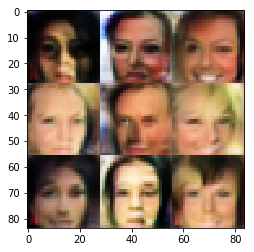

Epoch 1/1-Step 9610... Discriminator Loss: 1.2765... Generator Loss: 0.9334
Epoch 1/1-Step 9620... Discriminator Loss: 1.4019... Generator Loss: 0.8936
Epoch 1/1-Step 9630... Discriminator Loss: 1.3948... Generator Loss: 0.9540
Epoch 1/1-Step 9640... Discriminator Loss: 1.4181... Generator Loss: 0.6897
Epoch 1/1-Step 9650... Discriminator Loss: 1.7385... Generator Loss: 0.6183
Epoch 1/1-Step 9660... Discriminator Loss: 1.3200... Generator Loss: 1.0546
Epoch 1/1-Step 9670... Discriminator Loss: 1.3607... Generator Loss: 0.7846
Epoch 1/1-Step 9680... Discriminator Loss: 1.2170... Generator Loss: 0.8661
Epoch 1/1-Step 9690... Discriminator Loss: 1.3859... Generator Loss: 0.7578
Epoch 1/1-Step 9700... Discriminator Loss: 1.3041... Generator Loss: 0.9085


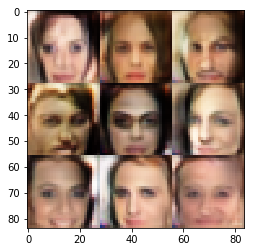

Epoch 1/1-Step 9710... Discriminator Loss: 1.3318... Generator Loss: 0.7355
Epoch 1/1-Step 9720... Discriminator Loss: 1.4124... Generator Loss: 0.7767
Epoch 1/1-Step 9730... Discriminator Loss: 1.5481... Generator Loss: 0.8282
Epoch 1/1-Step 9740... Discriminator Loss: 1.2969... Generator Loss: 0.7407
Epoch 1/1-Step 9750... Discriminator Loss: 1.4520... Generator Loss: 0.8938
Epoch 1/1-Step 9760... Discriminator Loss: 1.8065... Generator Loss: 0.5857
Epoch 1/1-Step 9770... Discriminator Loss: 1.3169... Generator Loss: 0.9921
Epoch 1/1-Step 9780... Discriminator Loss: 1.3492... Generator Loss: 0.7576
Epoch 1/1-Step 9790... Discriminator Loss: 1.4472... Generator Loss: 0.6129
Epoch 1/1-Step 9800... Discriminator Loss: 1.3531... Generator Loss: 0.9124


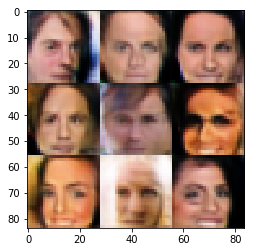

Epoch 1/1-Step 9810... Discriminator Loss: 1.4782... Generator Loss: 0.6006
Epoch 1/1-Step 9820... Discriminator Loss: 1.2930... Generator Loss: 0.8293
Epoch 1/1-Step 9830... Discriminator Loss: 1.6044... Generator Loss: 0.6507
Epoch 1/1-Step 9840... Discriminator Loss: 1.3829... Generator Loss: 0.7335
Epoch 1/1-Step 9850... Discriminator Loss: 1.3934... Generator Loss: 0.6768
Epoch 1/1-Step 9860... Discriminator Loss: 1.3801... Generator Loss: 0.7877
Epoch 1/1-Step 9870... Discriminator Loss: 1.3987... Generator Loss: 0.7471
Epoch 1/1-Step 9880... Discriminator Loss: 1.2617... Generator Loss: 1.0574
Epoch 1/1-Step 9890... Discriminator Loss: 1.5471... Generator Loss: 0.8093
Epoch 1/1-Step 9900... Discriminator Loss: 1.6048... Generator Loss: 0.9721


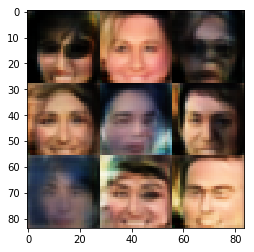

Epoch 1/1-Step 9910... Discriminator Loss: 1.3679... Generator Loss: 0.8096
Epoch 1/1-Step 9920... Discriminator Loss: 1.4799... Generator Loss: 0.8523
Epoch 1/1-Step 9930... Discriminator Loss: 1.5154... Generator Loss: 0.7592
Epoch 1/1-Step 9940... Discriminator Loss: 1.2642... Generator Loss: 0.8838
Epoch 1/1-Step 9950... Discriminator Loss: 1.4755... Generator Loss: 0.8207
Epoch 1/1-Step 9960... Discriminator Loss: 1.3311... Generator Loss: 1.1212
Epoch 1/1-Step 9970... Discriminator Loss: 1.2920... Generator Loss: 0.8989
Epoch 1/1-Step 9980... Discriminator Loss: 1.4537... Generator Loss: 0.8655
Epoch 1/1-Step 9990... Discriminator Loss: 1.5272... Generator Loss: 0.7564
Epoch 1/1-Step 10000... Discriminator Loss: 1.4175... Generator Loss: 0.6625


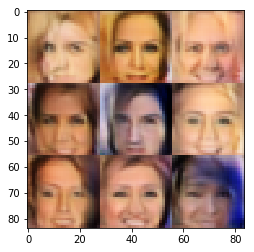

Epoch 1/1-Step 10010... Discriminator Loss: 1.4935... Generator Loss: 0.8439
Epoch 1/1-Step 10020... Discriminator Loss: 1.2484... Generator Loss: 0.8695
Epoch 1/1-Step 10030... Discriminator Loss: 1.3282... Generator Loss: 0.8563
Epoch 1/1-Step 10040... Discriminator Loss: 1.2869... Generator Loss: 0.9696
Epoch 1/1-Step 10050... Discriminator Loss: 1.3332... Generator Loss: 0.9056
Epoch 1/1-Step 10060... Discriminator Loss: 1.3607... Generator Loss: 0.8038
Epoch 1/1-Step 10070... Discriminator Loss: 1.2698... Generator Loss: 0.8784
Epoch 1/1-Step 10080... Discriminator Loss: 1.5117... Generator Loss: 0.8056
Epoch 1/1-Step 10090... Discriminator Loss: 1.4906... Generator Loss: 0.5707
Epoch 1/1-Step 10100... Discriminator Loss: 1.2585... Generator Loss: 0.9396


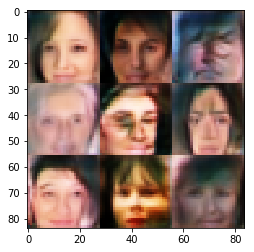

Epoch 1/1-Step 10110... Discriminator Loss: 1.4391... Generator Loss: 0.9607
Epoch 1/1-Step 10120... Discriminator Loss: 1.4613... Generator Loss: 0.8471
Epoch 1/1-Step 10130... Discriminator Loss: 1.4135... Generator Loss: 0.8948
Epoch 1/1-Step 10140... Discriminator Loss: 1.3844... Generator Loss: 0.8816
Epoch 1/1-Step 10150... Discriminator Loss: 1.3477... Generator Loss: 0.7196
Epoch 1/1-Step 10160... Discriminator Loss: 1.2777... Generator Loss: 0.9514
Epoch 1/1-Step 10170... Discriminator Loss: 1.3293... Generator Loss: 0.8516
Epoch 1/1-Step 10180... Discriminator Loss: 1.4020... Generator Loss: 0.5783
Epoch 1/1-Step 10190... Discriminator Loss: 1.2682... Generator Loss: 0.8802
Epoch 1/1-Step 10200... Discriminator Loss: 1.4533... Generator Loss: 0.8726


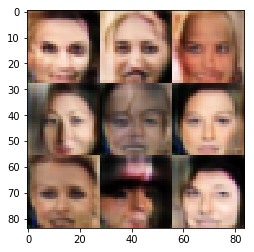

Epoch 1/1-Step 10210... Discriminator Loss: 1.4546... Generator Loss: 1.1139
Epoch 1/1-Step 10220... Discriminator Loss: 1.6298... Generator Loss: 0.7489
Epoch 1/1-Step 10230... Discriminator Loss: 1.2910... Generator Loss: 0.8509
Epoch 1/1-Step 10240... Discriminator Loss: 1.4758... Generator Loss: 0.6658
Epoch 1/1-Step 10250... Discriminator Loss: 1.2535... Generator Loss: 0.8536
Epoch 1/1-Step 10260... Discriminator Loss: 1.4520... Generator Loss: 0.8541
Epoch 1/1-Step 10270... Discriminator Loss: 1.5810... Generator Loss: 0.7749
Epoch 1/1-Step 10280... Discriminator Loss: 1.2750... Generator Loss: 0.9727
Epoch 1/1-Step 10290... Discriminator Loss: 1.2823... Generator Loss: 0.9044
Epoch 1/1-Step 10300... Discriminator Loss: 1.2948... Generator Loss: 0.8789


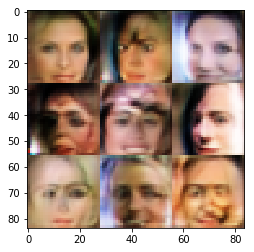

Epoch 1/1-Step 10310... Discriminator Loss: 1.3948... Generator Loss: 0.7093
Epoch 1/1-Step 10320... Discriminator Loss: 1.2347... Generator Loss: 0.6795
Epoch 1/1-Step 10330... Discriminator Loss: 1.3978... Generator Loss: 0.8835
Epoch 1/1-Step 10340... Discriminator Loss: 1.3607... Generator Loss: 0.7265
Epoch 1/1-Step 10350... Discriminator Loss: 1.3404... Generator Loss: 0.7620
Epoch 1/1-Step 10360... Discriminator Loss: 1.3495... Generator Loss: 0.9613
Epoch 1/1-Step 10370... Discriminator Loss: 1.2985... Generator Loss: 0.8333
Epoch 1/1-Step 10380... Discriminator Loss: 1.3280... Generator Loss: 0.9454
Epoch 1/1-Step 10390... Discriminator Loss: 1.4848... Generator Loss: 0.8489
Epoch 1/1-Step 10400... Discriminator Loss: 1.3480... Generator Loss: 1.1267


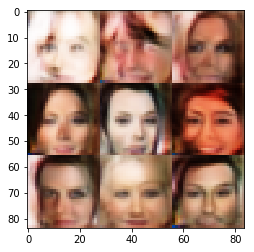

Epoch 1/1-Step 10410... Discriminator Loss: 1.2695... Generator Loss: 0.8037
Epoch 1/1-Step 10420... Discriminator Loss: 1.2881... Generator Loss: 0.8146
Epoch 1/1-Step 10430... Discriminator Loss: 1.4841... Generator Loss: 0.7443
Epoch 1/1-Step 10440... Discriminator Loss: 1.1279... Generator Loss: 0.7864
Epoch 1/1-Step 10450... Discriminator Loss: 1.4649... Generator Loss: 0.9297
Epoch 1/1-Step 10460... Discriminator Loss: 1.3983... Generator Loss: 0.7493
Epoch 1/1-Step 10470... Discriminator Loss: 1.3025... Generator Loss: 0.8726
Epoch 1/1-Step 10480... Discriminator Loss: 1.3413... Generator Loss: 0.6361
Epoch 1/1-Step 10490... Discriminator Loss: 1.4095... Generator Loss: 0.6189
Epoch 1/1-Step 10500... Discriminator Loss: 1.3131... Generator Loss: 0.6618


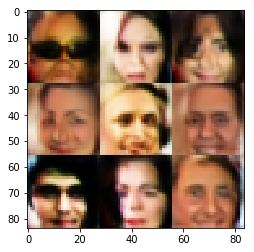

Epoch 1/1-Step 10510... Discriminator Loss: 1.3210... Generator Loss: 0.8413
Epoch 1/1-Step 10520... Discriminator Loss: 1.2047... Generator Loss: 0.5878
Epoch 1/1-Step 10530... Discriminator Loss: 1.4400... Generator Loss: 1.0525
Epoch 1/1-Step 10540... Discriminator Loss: 1.4856... Generator Loss: 0.7272
Epoch 1/1-Step 10550... Discriminator Loss: 1.4373... Generator Loss: 0.6747
Epoch 1/1-Step 10560... Discriminator Loss: 1.4687... Generator Loss: 0.7741
Epoch 1/1-Step 10570... Discriminator Loss: 1.2590... Generator Loss: 0.7342
Epoch 1/1-Step 10580... Discriminator Loss: 1.3178... Generator Loss: 0.8569
Epoch 1/1-Step 10590... Discriminator Loss: 1.2052... Generator Loss: 0.7949
Epoch 1/1-Step 10600... Discriminator Loss: 1.1968... Generator Loss: 0.9305


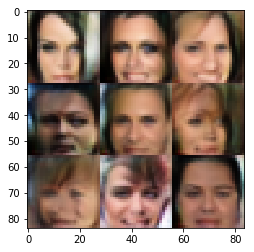

Epoch 1/1-Step 10610... Discriminator Loss: 1.5676... Generator Loss: 0.6585
Epoch 1/1-Step 10620... Discriminator Loss: 1.4860... Generator Loss: 0.9136
Epoch 1/1-Step 10630... Discriminator Loss: 1.2400... Generator Loss: 1.0616
Epoch 1/1-Step 10640... Discriminator Loss: 1.3501... Generator Loss: 0.6219
Epoch 1/1-Step 10650... Discriminator Loss: 1.5369... Generator Loss: 0.8147
Epoch 1/1-Step 10660... Discriminator Loss: 1.4280... Generator Loss: 0.6745
Epoch 1/1-Step 10670... Discriminator Loss: 1.3291... Generator Loss: 0.8705
Epoch 1/1-Step 10680... Discriminator Loss: 1.6188... Generator Loss: 0.8199
Epoch 1/1-Step 10690... Discriminator Loss: 1.4133... Generator Loss: 0.6562
Epoch 1/1-Step 10700... Discriminator Loss: 1.3344... Generator Loss: 0.7071


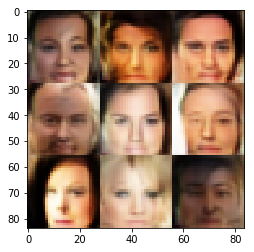

Epoch 1/1-Step 10710... Discriminator Loss: 1.3191... Generator Loss: 0.9704
Epoch 1/1-Step 10720... Discriminator Loss: 1.4205... Generator Loss: 0.7190
Epoch 1/1-Step 10730... Discriminator Loss: 1.3806... Generator Loss: 0.8748
Epoch 1/1-Step 10740... Discriminator Loss: 1.2956... Generator Loss: 0.8417
Epoch 1/1-Step 10750... Discriminator Loss: 1.2877... Generator Loss: 0.9098
Epoch 1/1-Step 10760... Discriminator Loss: 1.4572... Generator Loss: 0.7460
Epoch 1/1-Step 10770... Discriminator Loss: 1.3599... Generator Loss: 0.7880
Epoch 1/1-Step 10780... Discriminator Loss: 1.4582... Generator Loss: 0.8497
Epoch 1/1-Step 10790... Discriminator Loss: 1.5790... Generator Loss: 0.5692
Epoch 1/1-Step 10800... Discriminator Loss: 1.2783... Generator Loss: 0.7312


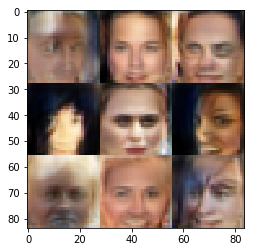

Epoch 1/1-Step 10810... Discriminator Loss: 1.4244... Generator Loss: 0.7810
Epoch 1/1-Step 10820... Discriminator Loss: 1.3106... Generator Loss: 1.0429
Epoch 1/1-Step 10830... Discriminator Loss: 1.3927... Generator Loss: 0.8113
Epoch 1/1-Step 10840... Discriminator Loss: 1.3475... Generator Loss: 0.7938
Epoch 1/1-Step 10850... Discriminator Loss: 1.4264... Generator Loss: 0.6428
Epoch 1/1-Step 10860... Discriminator Loss: 1.5916... Generator Loss: 0.4819
Epoch 1/1-Step 10870... Discriminator Loss: 1.3360... Generator Loss: 0.7638
Epoch 1/1-Step 10880... Discriminator Loss: 1.4117... Generator Loss: 1.1296
Epoch 1/1-Step 10890... Discriminator Loss: 1.3386... Generator Loss: 0.8863
Epoch 1/1-Step 10900... Discriminator Loss: 1.2954... Generator Loss: 0.6318


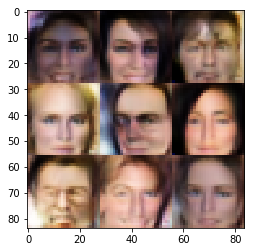

Epoch 1/1-Step 10910... Discriminator Loss: 1.3890... Generator Loss: 0.6359
Epoch 1/1-Step 10920... Discriminator Loss: 1.3991... Generator Loss: 0.7678
Epoch 1/1-Step 10930... Discriminator Loss: 1.2430... Generator Loss: 1.0111
Epoch 1/1-Step 10940... Discriminator Loss: 1.4026... Generator Loss: 0.8312
Epoch 1/1-Step 10950... Discriminator Loss: 1.4150... Generator Loss: 0.7696
Epoch 1/1-Step 10960... Discriminator Loss: 1.4728... Generator Loss: 0.5662
Epoch 1/1-Step 10970... Discriminator Loss: 1.4131... Generator Loss: 0.8603
Epoch 1/1-Step 10980... Discriminator Loss: 1.3735... Generator Loss: 0.7989
Epoch 1/1-Step 10990... Discriminator Loss: 1.4215... Generator Loss: 0.7640
Epoch 1/1-Step 11000... Discriminator Loss: 1.3377... Generator Loss: 0.8408


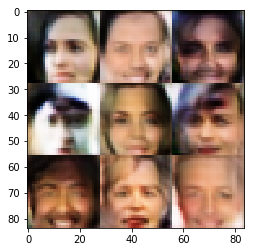

Epoch 1/1-Step 11010... Discriminator Loss: 1.4131... Generator Loss: 0.8705
Epoch 1/1-Step 11020... Discriminator Loss: 1.6240... Generator Loss: 0.8889
Epoch 1/1-Step 11030... Discriminator Loss: 1.2515... Generator Loss: 0.8264
Epoch 1/1-Step 11040... Discriminator Loss: 1.3354... Generator Loss: 0.6601
Epoch 1/1-Step 11050... Discriminator Loss: 1.3464... Generator Loss: 0.8474
Epoch 1/1-Step 11060... Discriminator Loss: 1.2523... Generator Loss: 0.9518
Epoch 1/1-Step 11070... Discriminator Loss: 1.2608... Generator Loss: 0.6950
Epoch 1/1-Step 11080... Discriminator Loss: 1.2128... Generator Loss: 0.8864
Epoch 1/1-Step 11090... Discriminator Loss: 1.3931... Generator Loss: 0.9828
Epoch 1/1-Step 11100... Discriminator Loss: 1.3821... Generator Loss: 0.8715


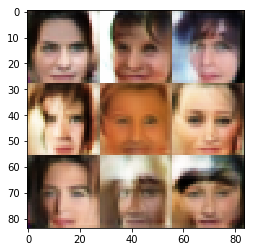

Epoch 1/1-Step 11110... Discriminator Loss: 1.4582... Generator Loss: 1.0099
Epoch 1/1-Step 11120... Discriminator Loss: 1.4083... Generator Loss: 0.7510
Epoch 1/1-Step 11130... Discriminator Loss: 1.4243... Generator Loss: 0.9778
Epoch 1/1-Step 11140... Discriminator Loss: 1.3653... Generator Loss: 0.8567
Epoch 1/1-Step 11150... Discriminator Loss: 1.2807... Generator Loss: 0.9424
Epoch 1/1-Step 11160... Discriminator Loss: 1.5374... Generator Loss: 0.9249
Epoch 1/1-Step 11170... Discriminator Loss: 1.2315... Generator Loss: 0.7423
Epoch 1/1-Step 11180... Discriminator Loss: 1.5830... Generator Loss: 0.7148
Epoch 1/1-Step 11190... Discriminator Loss: 1.3675... Generator Loss: 0.9009
Epoch 1/1-Step 11200... Discriminator Loss: 1.3814... Generator Loss: 0.6984


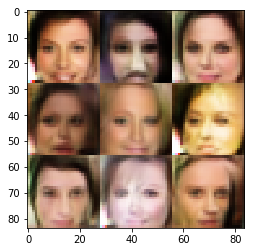

Epoch 1/1-Step 11210... Discriminator Loss: 1.3557... Generator Loss: 0.8923
Epoch 1/1-Step 11220... Discriminator Loss: 1.5899... Generator Loss: 0.7487
Epoch 1/1-Step 11230... Discriminator Loss: 1.2507... Generator Loss: 0.9168
Epoch 1/1-Step 11240... Discriminator Loss: 1.3095... Generator Loss: 0.8921
Epoch 1/1-Step 11250... Discriminator Loss: 1.5450... Generator Loss: 0.6646
Epoch 1/1-Step 11260... Discriminator Loss: 1.4563... Generator Loss: 0.9997
Epoch 1/1-Step 11270... Discriminator Loss: 1.3845... Generator Loss: 0.8956
Epoch 1/1-Step 11280... Discriminator Loss: 1.4630... Generator Loss: 0.8149
Epoch 1/1-Step 11290... Discriminator Loss: 1.2505... Generator Loss: 0.7907
Epoch 1/1-Step 11300... Discriminator Loss: 1.3488... Generator Loss: 1.0223


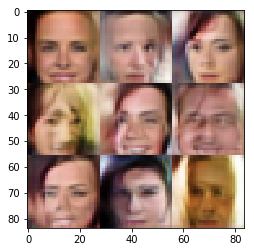

Epoch 1/1-Step 11310... Discriminator Loss: 1.4269... Generator Loss: 0.7955
Epoch 1/1-Step 11320... Discriminator Loss: 1.5527... Generator Loss: 0.6192
Epoch 1/1-Step 11330... Discriminator Loss: 1.4390... Generator Loss: 0.9324
Epoch 1/1-Step 11340... Discriminator Loss: 1.4394... Generator Loss: 0.6186
Epoch 1/1-Step 11350... Discriminator Loss: 1.2852... Generator Loss: 0.7538
Epoch 1/1-Step 11360... Discriminator Loss: 1.2607... Generator Loss: 1.0253
Epoch 1/1-Step 11370... Discriminator Loss: 1.3005... Generator Loss: 0.8196
Epoch 1/1-Step 11380... Discriminator Loss: 1.5029... Generator Loss: 0.8377
Epoch 1/1-Step 11390... Discriminator Loss: 1.4446... Generator Loss: 0.8927
Epoch 1/1-Step 11400... Discriminator Loss: 1.2528... Generator Loss: 0.7855


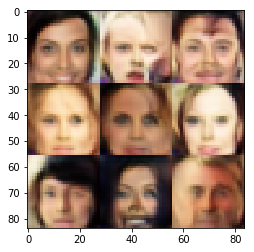

Epoch 1/1-Step 11410... Discriminator Loss: 1.5148... Generator Loss: 0.8904
Epoch 1/1-Step 11420... Discriminator Loss: 1.3747... Generator Loss: 0.7251
Epoch 1/1-Step 11430... Discriminator Loss: 1.2497... Generator Loss: 1.0771
Epoch 1/1-Step 11440... Discriminator Loss: 1.5128... Generator Loss: 0.7344
Epoch 1/1-Step 11450... Discriminator Loss: 1.2396... Generator Loss: 0.7375
Epoch 1/1-Step 11460... Discriminator Loss: 1.4684... Generator Loss: 0.9293
Epoch 1/1-Step 11470... Discriminator Loss: 1.4544... Generator Loss: 0.8491
Epoch 1/1-Step 11480... Discriminator Loss: 1.4127... Generator Loss: 0.7527
Epoch 1/1-Step 11490... Discriminator Loss: 1.2788... Generator Loss: 1.1250
Epoch 1/1-Step 11500... Discriminator Loss: 1.3754... Generator Loss: 0.7059


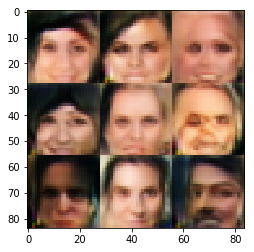

Epoch 1/1-Step 11510... Discriminator Loss: 1.2868... Generator Loss: 0.8759
Epoch 1/1-Step 11520... Discriminator Loss: 1.5955... Generator Loss: 0.7895
Epoch 1/1-Step 11530... Discriminator Loss: 1.4522... Generator Loss: 0.9598
Epoch 1/1-Step 11540... Discriminator Loss: 1.1838... Generator Loss: 0.8858
Epoch 1/1-Step 11550... Discriminator Loss: 1.2494... Generator Loss: 0.9102
Epoch 1/1-Step 11560... Discriminator Loss: 1.3684... Generator Loss: 1.0006
Epoch 1/1-Step 11570... Discriminator Loss: 1.2447... Generator Loss: 0.8008
Epoch 1/1-Step 11580... Discriminator Loss: 1.6734... Generator Loss: 0.6938
Epoch 1/1-Step 11590... Discriminator Loss: 1.2360... Generator Loss: 0.7650
Epoch 1/1-Step 11600... Discriminator Loss: 1.2692... Generator Loss: 0.8925


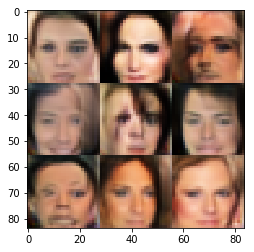

Epoch 1/1-Step 11610... Discriminator Loss: 1.3321... Generator Loss: 0.7206
Epoch 1/1-Step 11620... Discriminator Loss: 1.3030... Generator Loss: 0.9384
Epoch 1/1-Step 11630... Discriminator Loss: 1.4545... Generator Loss: 0.7635
Epoch 1/1-Step 11640... Discriminator Loss: 1.3959... Generator Loss: 0.9490
Epoch 1/1-Step 11650... Discriminator Loss: 1.4048... Generator Loss: 0.7957
Epoch 1/1-Step 11660... Discriminator Loss: 1.5312... Generator Loss: 0.8739
Epoch 1/1-Step 11670... Discriminator Loss: 1.4612... Generator Loss: 0.6763
Epoch 1/1-Step 11680... Discriminator Loss: 1.1386... Generator Loss: 0.8367
Epoch 1/1-Step 11690... Discriminator Loss: 1.6632... Generator Loss: 0.7885
Epoch 1/1-Step 11700... Discriminator Loss: 1.2312... Generator Loss: 0.8279


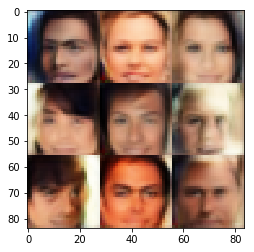

Epoch 1/1-Step 11710... Discriminator Loss: 1.4111... Generator Loss: 0.8266
Epoch 1/1-Step 11720... Discriminator Loss: 1.3457... Generator Loss: 0.8164
Epoch 1/1-Step 11730... Discriminator Loss: 1.3250... Generator Loss: 0.7632
Epoch 1/1-Step 11740... Discriminator Loss: 1.4381... Generator Loss: 0.8089
Epoch 1/1-Step 11750... Discriminator Loss: 1.4645... Generator Loss: 0.8010
Epoch 1/1-Step 11760... Discriminator Loss: 1.3394... Generator Loss: 0.8888
Epoch 1/1-Step 11770... Discriminator Loss: 1.2586... Generator Loss: 0.8806
Epoch 1/1-Step 11780... Discriminator Loss: 1.2871... Generator Loss: 0.8592
Epoch 1/1-Step 11790... Discriminator Loss: 1.4190... Generator Loss: 0.7568
Epoch 1/1-Step 11800... Discriminator Loss: 1.3011... Generator Loss: 0.8448


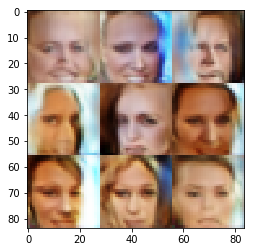

Epoch 1/1-Step 11810... Discriminator Loss: 1.5680... Generator Loss: 0.8663
Epoch 1/1-Step 11820... Discriminator Loss: 1.4439... Generator Loss: 0.7407
Epoch 1/1-Step 11830... Discriminator Loss: 1.2312... Generator Loss: 0.9643
Epoch 1/1-Step 11840... Discriminator Loss: 1.5059... Generator Loss: 0.8405
Epoch 1/1-Step 11850... Discriminator Loss: 1.2742... Generator Loss: 0.7685
Epoch 1/1-Step 11860... Discriminator Loss: 1.3000... Generator Loss: 0.8343
Epoch 1/1-Step 11870... Discriminator Loss: 1.5035... Generator Loss: 0.8467
Epoch 1/1-Step 11880... Discriminator Loss: 1.3962... Generator Loss: 0.8547
Epoch 1/1-Step 11890... Discriminator Loss: 1.3165... Generator Loss: 0.8841
Epoch 1/1-Step 11900... Discriminator Loss: 1.2998... Generator Loss: 0.7774


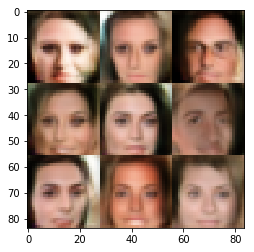

Epoch 1/1-Step 11910... Discriminator Loss: 1.3885... Generator Loss: 0.7595
Epoch 1/1-Step 11920... Discriminator Loss: 1.3611... Generator Loss: 0.8702
Epoch 1/1-Step 11930... Discriminator Loss: 1.2886... Generator Loss: 0.7828
Epoch 1/1-Step 11940... Discriminator Loss: 1.2814... Generator Loss: 0.8035
Epoch 1/1-Step 11950... Discriminator Loss: 1.3590... Generator Loss: 0.8102
Epoch 1/1-Step 11960... Discriminator Loss: 1.3776... Generator Loss: 0.6348
Epoch 1/1-Step 11970... Discriminator Loss: 1.2823... Generator Loss: 0.9209
Epoch 1/1-Step 11980... Discriminator Loss: 1.5918... Generator Loss: 0.7585
Epoch 1/1-Step 11990... Discriminator Loss: 1.2999... Generator Loss: 0.9440
Epoch 1/1-Step 12000... Discriminator Loss: 1.2886... Generator Loss: 0.9465


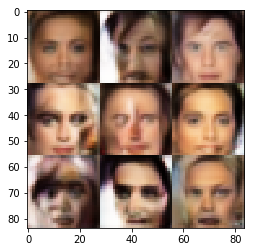

Epoch 1/1-Step 12010... Discriminator Loss: 1.3893... Generator Loss: 1.0843
Epoch 1/1-Step 12020... Discriminator Loss: 1.3826... Generator Loss: 0.8926
Epoch 1/1-Step 12030... Discriminator Loss: 1.5257... Generator Loss: 0.7666
Epoch 1/1-Step 12040... Discriminator Loss: 1.3441... Generator Loss: 0.8539
Epoch 1/1-Step 12050... Discriminator Loss: 1.3652... Generator Loss: 0.9032
Epoch 1/1-Step 12060... Discriminator Loss: 1.4243... Generator Loss: 1.0420
Epoch 1/1-Step 12070... Discriminator Loss: 1.1094... Generator Loss: 1.1120
Epoch 1/1-Step 12080... Discriminator Loss: 1.3395... Generator Loss: 0.9102
Epoch 1/1-Step 12090... Discriminator Loss: 1.3288... Generator Loss: 0.8957
Epoch 1/1-Step 12100... Discriminator Loss: 1.3541... Generator Loss: 0.7103


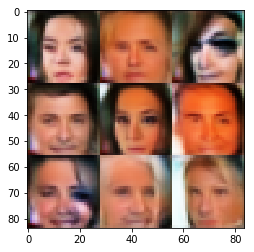

Epoch 1/1-Step 12110... Discriminator Loss: 1.3892... Generator Loss: 0.8427
Epoch 1/1-Step 12120... Discriminator Loss: 1.3067... Generator Loss: 0.9743
Epoch 1/1-Step 12130... Discriminator Loss: 1.2540... Generator Loss: 0.8069
Epoch 1/1-Step 12140... Discriminator Loss: 1.1483... Generator Loss: 0.9029
Epoch 1/1-Step 12150... Discriminator Loss: 1.4093... Generator Loss: 0.9016
Epoch 1/1-Step 12160... Discriminator Loss: 1.4080... Generator Loss: 0.7713
Epoch 1/1-Step 12170... Discriminator Loss: 1.5690... Generator Loss: 0.7068
Epoch 1/1-Step 12180... Discriminator Loss: 1.3836... Generator Loss: 0.7119
Epoch 1/1-Step 12190... Discriminator Loss: 1.4461... Generator Loss: 0.5718
Epoch 1/1-Step 12200... Discriminator Loss: 1.3887... Generator Loss: 1.0066


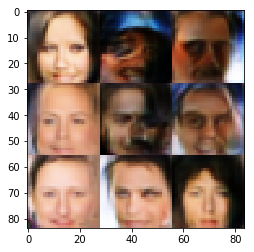

Epoch 1/1-Step 12210... Discriminator Loss: 1.4476... Generator Loss: 1.0213
Epoch 1/1-Step 12220... Discriminator Loss: 1.1862... Generator Loss: 0.8651
Epoch 1/1-Step 12230... Discriminator Loss: 1.4644... Generator Loss: 0.7877
Epoch 1/1-Step 12240... Discriminator Loss: 1.3565... Generator Loss: 0.9463
Epoch 1/1-Step 12250... Discriminator Loss: 1.2269... Generator Loss: 0.8404
Epoch 1/1-Step 12260... Discriminator Loss: 1.2739... Generator Loss: 0.8159
Epoch 1/1-Step 12270... Discriminator Loss: 1.4365... Generator Loss: 0.6559
Epoch 1/1-Step 12280... Discriminator Loss: 1.4702... Generator Loss: 1.1371
Epoch 1/1-Step 12290... Discriminator Loss: 1.3055... Generator Loss: 1.1993
Epoch 1/1-Step 12300... Discriminator Loss: 1.2517... Generator Loss: 0.7576


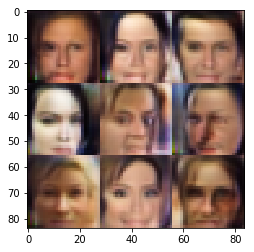

Epoch 1/1-Step 12310... Discriminator Loss: 1.6214... Generator Loss: 0.8081
Epoch 1/1-Step 12320... Discriminator Loss: 1.2923... Generator Loss: 1.3314
Epoch 1/1-Step 12330... Discriminator Loss: 1.1905... Generator Loss: 0.8463
Epoch 1/1-Step 12340... Discriminator Loss: 1.6069... Generator Loss: 0.6199
Epoch 1/1-Step 12350... Discriminator Loss: 1.4185... Generator Loss: 0.7690
Epoch 1/1-Step 12360... Discriminator Loss: 1.2614... Generator Loss: 0.6309
Epoch 1/1-Step 12370... Discriminator Loss: 1.2238... Generator Loss: 0.7949
Epoch 1/1-Step 12380... Discriminator Loss: 1.3518... Generator Loss: 0.9461
Epoch 1/1-Step 12390... Discriminator Loss: 1.3218... Generator Loss: 0.7197
Epoch 1/1-Step 12400... Discriminator Loss: 1.3029... Generator Loss: 0.8115


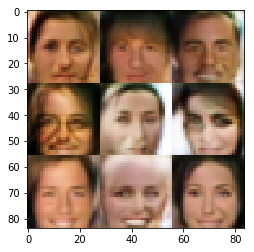

Epoch 1/1-Step 12410... Discriminator Loss: 1.3318... Generator Loss: 0.6683
Epoch 1/1-Step 12420... Discriminator Loss: 1.4617... Generator Loss: 0.9376
Epoch 1/1-Step 12430... Discriminator Loss: 1.4149... Generator Loss: 0.7557
Epoch 1/1-Step 12440... Discriminator Loss: 1.3193... Generator Loss: 0.6324
Epoch 1/1-Step 12450... Discriminator Loss: 1.2309... Generator Loss: 1.0568
Epoch 1/1-Step 12460... Discriminator Loss: 1.4777... Generator Loss: 0.8648
Epoch 1/1-Step 12470... Discriminator Loss: 1.3108... Generator Loss: 1.0013
Epoch 1/1-Step 12480... Discriminator Loss: 1.2289... Generator Loss: 0.7481
Epoch 1/1-Step 12490... Discriminator Loss: 1.5573... Generator Loss: 0.8947
Epoch 1/1-Step 12500... Discriminator Loss: 1.5264... Generator Loss: 0.9437


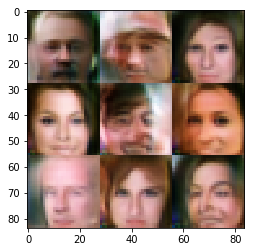

Epoch 1/1-Step 12510... Discriminator Loss: 1.2938... Generator Loss: 0.7327
Epoch 1/1-Step 12520... Discriminator Loss: 1.4593... Generator Loss: 0.9380
Epoch 1/1-Step 12530... Discriminator Loss: 1.4106... Generator Loss: 0.7292
Epoch 1/1-Step 12540... Discriminator Loss: 1.3427... Generator Loss: 0.8795
Epoch 1/1-Step 12550... Discriminator Loss: 1.2490... Generator Loss: 0.7984
Epoch 1/1-Step 12560... Discriminator Loss: 1.3427... Generator Loss: 0.7317
Epoch 1/1-Step 12570... Discriminator Loss: 1.5050... Generator Loss: 0.9468
Epoch 1/1-Step 12580... Discriminator Loss: 1.2578... Generator Loss: 0.9158
Epoch 1/1-Step 12590... Discriminator Loss: 1.2107... Generator Loss: 0.7373
Epoch 1/1-Step 12600... Discriminator Loss: 1.2843... Generator Loss: 0.8304


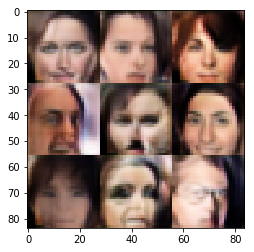

Epoch 1/1-Step 12610... Discriminator Loss: 1.5333... Generator Loss: 0.8049
Epoch 1/1-Step 12620... Discriminator Loss: 1.6096... Generator Loss: 0.7886
Epoch 1/1-Step 12630... Discriminator Loss: 1.4343... Generator Loss: 0.9134
Epoch 1/1-Step 12640... Discriminator Loss: 1.6045... Generator Loss: 0.5781
Epoch 1/1-Step 12650... Discriminator Loss: 1.3478... Generator Loss: 0.8706
Epoch 1/1-Step 12660... Discriminator Loss: 1.5313... Generator Loss: 0.9332


In [18]:
batch_size = 16
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.